In [2]:
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm


In [3]:
def update_excel_intensities(filename,df,sheet,mode='a'):
    if mode=='a':
        with pd.ExcelWriter(filename,mode=mode, if_sheet_exists='replace') as writer:  
            df.to_excel(writer, sheet_name=sheet)
    else:
        with pd.ExcelWriter(filename,mode=mode) as writer:  
            df.to_excel(writer, sheet_name=sheet)
    
def read_excel_sheet(file,sheetname):
    customers = pd.read_excel(file,
        sheet_name=sheetname,
        header=0,
        index_col=0,
        keep_default_na=True
        )
    return customers

def read_csv(file,sheetname):
    customers = pd.read_csv(file,
        header=0,
        sep=';',
        index_col=0,
        keep_default_na=True
        )
    
    customers.fillna(0,inplace=True)
    
    return customers

def div100(x):
    return x/100.0

def logistic(x):
    return np.log(x/(1-x))

def invlogistic(x):
    return np.exp(x)/(1+np.exp(x))

def onex(x):
    return x/(1-x)

def invonex(x):
    return x/(1+x)

def onex2(x):
    return x*x/(1-x*x)

def invonex2(x):
    return np.sqrt(x/(1+x))


def mul100(x):
    return x*100.0

def predict_ewma1(df,year):
    ind=data2.index.values==year+1
    nn=np.arange(ind.shape[0])
    n=np.max(nn[ind])
    
    logit=df.apply(div100).apply(logistic)
    ewmadiff=logit.diff().ewm(alpha=0.2).mean()
    #n=34
    nmax=logit.shape[0]

    for k in range(n,nmax):
        logit.iloc[k,:]=logit.iloc[k-1,:]+ewmadiff.iloc[n,:]

    ret=logit.apply(invlogistic).apply(mul100)    
    return ret

def predict_ewma2(df,year):
    ind=df.index.values==year+1
    nn=np.arange(ind.shape[0])
    n=np.max(nn[ind])
    
    logit=df.apply(div100).apply(logistic)
    ewmadiff=logit.ewm(alpha=0.2,adjust=True).mean()
    #n=34
    nmax=logit.shape[0]
    
    alpha=0.5
    
    y=logit.iloc[n-2,:]

    for k in range(n,nmax):
        #logit.iloc[k,:]=logit.iloc[k-1,:]+ewmadiff.iloc[n,:]
        
        y=(1-alpha)*y+alpha*logit.iloc[k-1,:]
        logit.iloc[k,:]=y
        print(y)
        

    ret=logit.apply(invlogistic).apply(mul100)    
    return ret

def check_acf(df,year):
    for col in df.columns:
        print(f'forecasting {col}')
        first=df.index[0]
        deftrain=df.loc[:year,col].copy()
        f=plt.figure()
        ax1=f.add_subplot(121)
        ax1.plot(df.diff().dropna())
        ax2=f.add_subplot(122)
        plot_acf(df.loc[:,col].diff().dropna(),ax=ax2)
        f.show()
        f=plt.figure()
        ax1=f.add_subplot(121)
        ax1.plot(df.diff().diff().dropna())
        ax2=f.add_subplot(122)
        plot_acf(df.loc[:,col].diff().dropna(),ax=ax2)
        f.show()

def return_diff(df,trans=True):  
    df2=df.copy()
    if trans:
        return df2.apply(div100).apply(onex2).diff()
    else:
        return df2.apply(div100).apply(logistic).diff()

def return_diffdiff(df,trans=True):  
    df2=df.copy()
    if trans:
        return df2.apply(div100).apply(onex2).diff().diff()
    else:
        return df2.apply(div100).apply(logistic).diff().diff()


def return_firstvalue(df,trans=True):
    if trans:
        first_value=df.apply(div100).apply(onex2).iloc[0]
    else:
        first_value=df.apply(div100).apply(logistic).iloc[0]
    return first_value
    
def get_diffdiff(df,year,debug=True,trans=True,n_periods=0):
    first=df.index[0]
    deftrain=df.loc[:year].copy()
    logit=return_diffdiff(deftrain,trans=trans)
    dftest=df.copy()

    if debug:
        print('deftrain',deftrain)
        print(return_diff(deftrain,trans=True))
        print(logit.shape)
        print(logit)
    logit=logit.iloc[2:]
    plt.plot(df.loc[first:year])
    if debug:
        plot_corr(df.loc[first:year])

    plt.hist(logit.values)
    plt.show()

    auto_arima = pm.auto_arima(logit, start_p = 1, start_q = 1, max_p = 5, max_q = 5, max_d = 5, stepwise=False, seasonal=False,information_criterion='aic')
    print(auto_arima.summary())

    forecast_test_auto = auto_arima.predict(n_periods=n_periods)
    display('forecast_test_auto',forecast_test_auto)

    first_diff=return_diff(dftest,trans=trans)
    if debug:
        print('first_diff',first_diff.iloc[1],first_diff)
        
    z0 = list([first_diff.iloc[1]]) + list(logit) + list(forecast_test_auto)
    z = pd.DataFrame(z0)
    x = z.cumsum()
    if debug:
        print('x shape',x.shape)
    first_value=return_firstvalue(deftrain,trans=trans) #df.apply(div100).apply(onex2).iloc[0]
    if debug:
        print('first_value',first_value)
    y = pd.DataFrame(list([first_value]) + list(x.values[:,0]),index=range(1989,2035),columns=['val'])
    if debug:
        print('y shape',y.shape)
        print('y',y)
    dftest['forecast_auto'] = y.cumsum()
    if debug:
        print('forecast cumsum',dftest['forecast_auto'])
    if trans:
        dftest['forecast_auto']=dftest['forecast_auto'].apply(invonex2).apply(mul100)
    else:
        dftest['forecast_auto']=dftest['forecast_auto'].apply(invlogistic).apply(mul100)
    if debug:
        print('forecast',dftest['forecast_auto'])

    dftest['forecast_auto'].plot()
    plt.show()
        
    return dftest['forecast_auto'].values

def plot_corr(df):
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    plt.figure()
    plt.subplot(211)
    plot_acf(df, ax = plt.gca())
    plt.subplot(212)
    plot_pacf(df, ax = plt.gca())
    plt.show()    

def get_diff(df,year,debug=True,trans=True,n_periods=0):
    first=df.index[0]
    deftrain=df.loc[:year].copy()
    logit=return_diff(deftrain,trans=trans)

    dftest=df.copy()
    if debug:
        print('deftrain',deftrain)
        print(return_diff(deftrain,trans=trans))
        print(logit.shape)
        print(logit)
    logit=logit.iloc[1:]
    plt.plot(df.loc[first:year])
    if debug:
        plot_corr(df.loc[first:year])

    plt.hist(logit.values)
    plt.show()

    auto_arima = pm.auto_arima(logit, start_p = 1, start_q = 1, max_p = 5, max_q = 5, max_d = 5, stepwise=False, seasonal=False,information_criterion='bic')
    print(auto_arima.summary())

    forecast_test_auto = auto_arima.predict(n_periods=n_periods)
    display('forecast_test_auto',forecast_test_auto)

    first_value=return_firstvalue(df,trans=trans)    
    if debug:
        print('first_value',first_value)
    z = pd.DataFrame(list([first_value]) + list(logit) + list(forecast_test_auto),index=range(1989,2035),columns=['val'])
    dftest['forecast_auto'] = z.cumsum()
    if debug:
        print('forecast cumsum',dftest['forecast_auto'])
    if trans:
        dftest['forecast_auto']=dftest['forecast_auto'].apply(invonex2).apply(mul100)
    else:
        dftest['forecast_auto']=dftest['forecast_auto'].apply(invlogistic).apply(mul100)
    if debug:
        print('forecast',dftest['forecast_auto'])

    dftest['forecast_auto'].plot()
    plt.show()
            
    return dftest['forecast_auto'].values
    
def predict_arima(df,year,debug=True):
    ind=df.index.values==year+1
    nn=np.arange(ind.shape[0])
    n=np.max(nn[ind])
    
    n_periods=2034-year
    dftest=df.copy()
    
    log_trans=['alypuhelin','some_25_34','some_35_44','sisempikaupunki','ulompikaupunki','kehyskaupunki','maaseudulla']
    first_diff=['avioituvuus_30_34']
    
    if debug:
        cols = df.columns #list(['alypuhelin'])
    else:
        cols = df.columns
    
    for col in cols:
        print(f'forecasting {col}')

        if col in log_trans:
            trans=True
        else:
            trans=False
        
        if col in first_diff:
            dftest.loc[:,col]=get_diff(df.loc[:year,col],year,debug=debug,trans=trans,n_periods=n_periods)
        else:
            dftest.loc[:,col]=get_diffdiff(df.loc[:year,col],year,debug=debug,trans=trans,n_periods=n_periods)
      
    return dftest

In [4]:
data = read_excel_sheet('data/predictions_backtesting_2023.xlsx','2022')

In [5]:
data

alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989          0.0    0.000000    0.000000          88.300000   
1990          0.0    0.000000    0.000000          87.500000   
1991          0.0    0.000000    0.000000          86.000000   
1992          0.0    0.000000    0.000000          81.100000   
1993          0.0    0.000000    0.000000          84.800000   
1994          0.0    0.000000    0.000000          84.100000   
1995          0.0    0.000000    0.000000          78.500000   
1996          0.0    0.000000    0.000000          78.500000   
1997          0.0    0.000000    0.000000          75.500000   
1998          0.0    0.000000    0.000000          74.800000   
1999          0.0    0.000000    0.000000          74.400000   
2000          0.0    0.100625    0.056875          76.900000   
2001          0.0    0.201250    0.113750          72.700000   
2002          0.0    0.402500    0.227500          79.400000   
2003          0.0    0.805000    0.455000          75.600000   
2004          0.0    1.610000    0.910000          81.100000   
2005          0.6    3.220000    1.820000          80.500000   
2006          1.6    5.060000    2.860000          77.000000   
2007          3.6    8.280000    4.680000          78.800000   
2008          6.6   11.500000    6.500000          80.500000   
2009         11.6   17.480000    9.880000          76.500000   
2010         18.6   21.160000   11.960000          75.900000   
2011         28.6   23.000000   13.000000          68.900000   
2012         38.6   21.000000   13.000000          69.600000   
2013         51.5   26.000000   18.000000          59.700000   
2014         61.5   33.000000   19.000000          56.700000   
2015         68.4   44.000000   27.000000          54.700000   
2016         74.9   55.000000   41.000000          52.600000   
2017         79.1   57.000000   41.000000          48.700000   
2018         80.0   53.000000   47.000000          45.300000   
2019         83.0   74.000000   73.000000          39.300000   
2020         87.0   85.000000   79.000000          36.300000   
2021         88.0   81.000000   72.000000          35.000000   
2022         88.0   80.000000   76.000000          36.500000   
2023         88.0   80.000000   76.000000          36.008054   
2024         88.0   80.000000   76.000000          35.519029   
2025         88.0   80.000000   76.000000          35.033009   
2026         88.0   80.000000   76.000000          34.550077   
2027         88.0   80.000000   76.000000          34.070311   
2028         88.0   80.000000   76.000000          33.593787   
2029         88.0   80.000000   76.000000          33.120580   
2030         88.0   80.000000   76.000000          32.650761   
2031         88.0   80.000000   76.000000          32.184400   
2032         88.0   80.000000   76.000000          31.721562   
2033         88.0   80.000000   76.000000          31.262312   
2034         88.0   80.000000   76.000000          30.806711   

       avioituvuus_30_34  synnyttajien_keskiika  sisempikaupunki  \
vuosi                                                              
1989           49.600000              29.080000            32.50   
1990           51.400000              29.160071            32.50   
1991           50.500000              29.170250            32.50   
1992           49.500000              29.273838            32.30   
1993           53.600000              29.360658            32.40   
1994           54.200000              29.504384            32.60   
1995           52.600000              29.687610            33.00   
1996           55.400000              29.755130            33.20   
1997           51.100000              29.852071            33.50   
1998           52.700000              29.938362            33.70   
1999           53.000000              29.948293            33.90   
2000           59.100000              29.930651   

In [5]:
#check_acf(data,2022)

forecasting alypuhelin
deftrain vuosi
1989     0.0
1990     0.0
1991     0.0
1992     0.0
1993     0.0
1994     0.0
1995     0.0
1996     0.0
1997     0.0
1998     0.0
1999     0.0
2000     0.0
2001     0.0
2002     0.0
2003     0.0
2004     0.0
2005     0.6
2006     1.6
2007     3.6
2008     6.6
2009    11.6
2010    18.6
2011    28.6
2012    38.6
2013    51.5
2014    61.5
2015    68.4
2016    74.9
2017    79.1
2018    80.0
2019    83.0
2020    87.0
2021    88.0
2022    88.0
Name: alypuhelin, dtype: float64
vuosi
1989         NaN
1990    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.000000
1998    0.000000
1999    0.000000
2000    0.000000
2001    0.000000
2002    0.000000
2003    0.000000
2004    0.000000
2005    0.000036
2006    0.000220
2007    0.001042
2008    0.003077
2009    0.009264
2010    0.022196
2011    0.053247
2012    0.086000
2013    0.185878
2014    0.247338
2015    0.270892
2016    0.398719
2017 

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


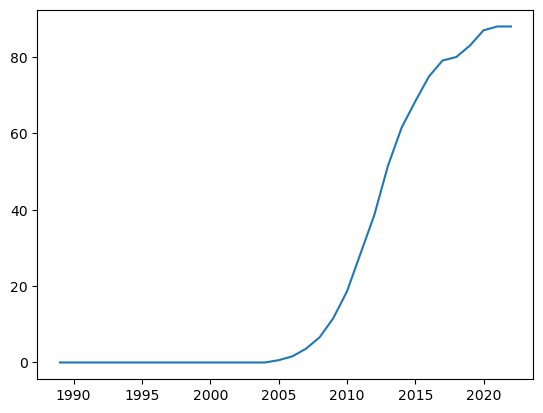

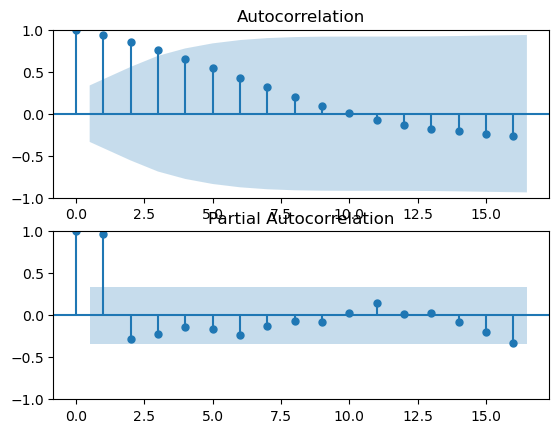

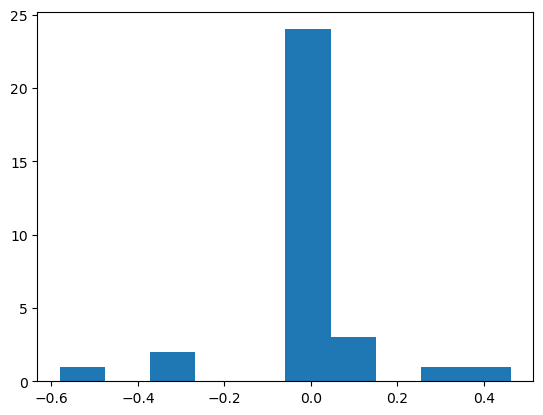

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(5, 0, 0)   Log Likelihood                  38.040
Date:                Sat, 02 Sep 2023   AIC                            -64.081
Time:                        12:47:35   BIC                            -55.286
Sample:                             0   HQIC                           -61.166
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2077      0.145      1.430      0.153      -0.077       0.492
ar.L2         -1.3196      0.166     -7.960      0.000      -1.644      -0.995
ar.L3          1.0430      0.294      3.549      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.866788
33    0.091109
34   -0.935760
35    0.266502
36    0.877271
37   -0.540604
38   -0.628856
39    0.729166
40    0.334316
41   -0.735982
42   -0.029498
43    0.622958
dtype: float64

first_diff 0.0 vuosi
1989         NaN
1990    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.000000
1998    0.000000
1999    0.000000
2000    0.000000
2001    0.000000
2002    0.000000
2003    0.000000
2004    0.000000
2005    0.000036
2006    0.000220
2007    0.001042
2008    0.003077
2009    0.009264
2010    0.022196
2011    0.053247
2012    0.086000
2013    0.185878
2014    0.247338
2015    0.270892
2016    0.398719
2017    0.393609
2018    0.106260
2019    0.436623
2020    0.899133
2021    0.319091
2022    0.000000
Name: alypuhelin, dtype: float64
x shape (45, 1)
first_value 0.0
y shape (46, 1)
y            val
1989  0.000000
1990  0.000000
1991  0.000000
1992  0.000000
1993  0.000000
1994  0.000000
1995  0.000000
1996  0.000000
1997  0.000000
1998  0.000000
1999  0.000000
2000  0.000000
2001  0.000000
2002  0.000000
2003  0.000000
2004  0.000000
2005  0.000036
2006  0.000220
2007  0.001042
2008  0.003077
200

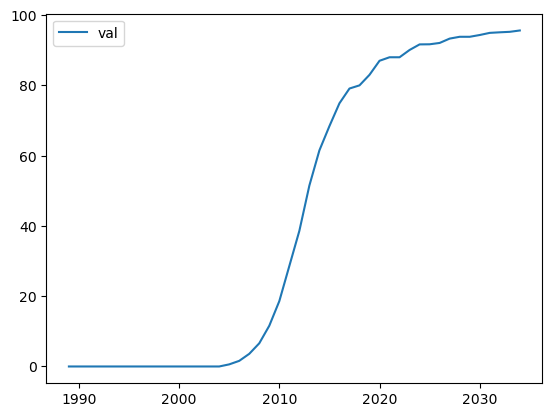

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


forecasting some_25_34
deftrain vuosi
1989     0.000000
1990     0.000000
1991     0.000000
1992     0.000000
1993     0.000000
1994     0.000000
1995     0.000000
1996     0.000000
1997     0.000000
1998     0.000000
1999     0.000000
2000     0.100625
2001     0.201250
2002     0.402500
2003     0.805000
2004     1.610000
2005     3.220000
2006     5.060000
2007     8.280000
2008    11.500000
2009    17.480000
2010    21.160000
2011    23.000000
2012    21.000000
2013    26.000000
2014    33.000000
2015    44.000000
2016    55.000000
2017    57.000000
2018    53.000000
2019    74.000000
2020    85.000000
2021    81.000000
2022    80.000000
Name: some_25_34, dtype: float64
vuosi
1989         NaN
1990    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.000000
1998    0.000000
1999    0.000000
2000    0.000001
2001    0.000003
2002    0.000012
2003    0.000049
2004    0.000194
2005    0.000779
2006    0.001529
2007 

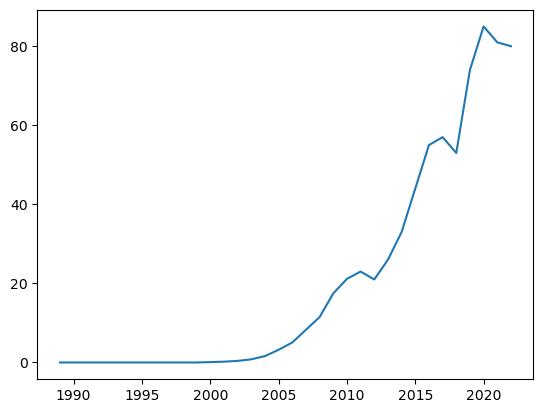

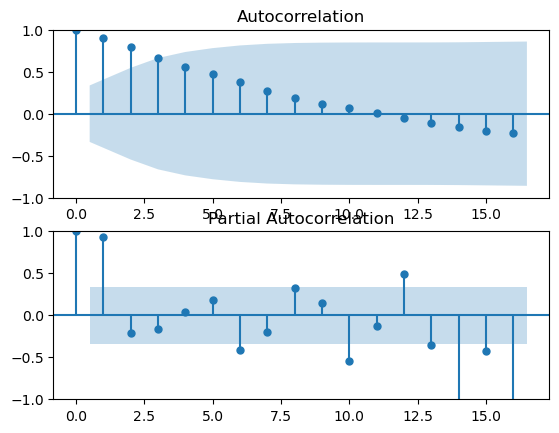

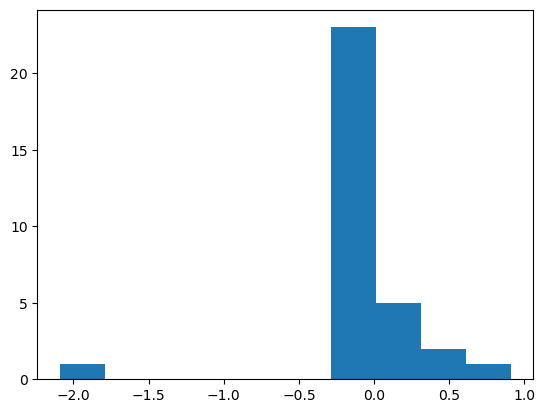

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(4, 0, 0)   Log Likelihood                  -1.510
Date:                Sat, 02 Sep 2023   AIC                             13.021
Time:                        12:47:37   BIC                             20.350
Sample:                             0   HQIC                            15.450
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7298      0.187     -3.897      0.000      -1.097      -0.363
ar.L2         -1.5282      0.248     -6.173      0.000      -2.013      -1.043
ar.L3         -0.4991      0.481     -1.038      0.2

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    2.012883
33   -1.593351
34   -1.093493
35    1.929760
36   -0.003953
37   -1.559691
38    0.757998
39    0.814154
40   -0.971937
41   -0.090324
42    0.744928
43   -0.350024
dtype: float64

first_diff 0.0 vuosi
1989         NaN
1990    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.000000
1998    0.000000
1999    0.000000
2000    0.000001
2001    0.000003
2002    0.000012
2003    0.000049
2004    0.000194
2005    0.000779
2006    0.001529
2007    0.004336
2008    0.006499
2009    0.018116
2010    0.015355
2011    0.008981
2012   -0.009720
2013    0.026367
2014    0.049707
2015    0.117871
2016    0.193612
2017    0.047570
2018   -0.090635
2019    0.819806
2020    1.393170
2021   -0.695782
2022   -0.130044
Name: some_25_34, dtype: float64
x shape (45, 1)
first_value 0.0
y shape (46, 1)
y            val
1989  0.000000
1990  0.000000
1991  0.000000
1992  0.000000
1993  0.000000
1994  0.000000
1995  0.000000
1996  0.000000
1997  0.000000
1998  0.000000
1999  0.000000
2000  0.000001
2001  0.000003
2002  0.000012
2003  0.000049
2004  0.000194
2005  0.000779
2006  0.001529
2007  0.004336
2008  0.006499
200

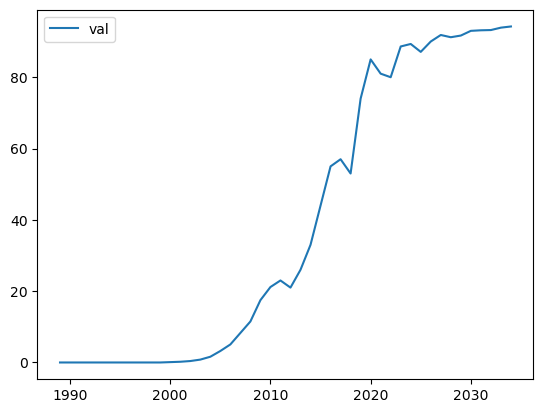

forecasting some_35_44
deftrain vuosi
1989     0.000000
1990     0.000000
1991     0.000000
1992     0.000000
1993     0.000000
1994     0.000000
1995     0.000000
1996     0.000000
1997     0.000000
1998     0.000000
1999     0.000000
2000     0.056875
2001     0.113750
2002     0.227500
2003     0.455000
2004     0.910000
2005     1.820000
2006     2.860000
2007     4.680000
2008     6.500000
2009     9.880000
2010    11.960000
2011    13.000000
2012    13.000000
2013    18.000000
2014    19.000000
2015    27.000000
2016    41.000000
2017    41.000000
2018    47.000000
2019    73.000000
2020    79.000000
2021    72.000000
2022    76.000000
Name: some_35_44, dtype: float64
vuosi
1989             NaN
1990    0.000000e+00
1991    0.000000e+00
1992    0.000000e+00
1993    0.000000e+00
1994    0.000000e+00
1995    0.000000e+00
1996    0.000000e+00
1997    0.000000e+00
1998    0.000000e+00
1999    0.000000e+00
2000    3.234767e-07
2001    9.704313e-07
2002    3.881744e-06
2003    1.552728e

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


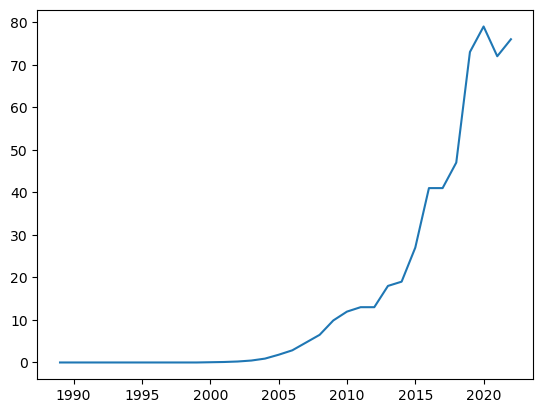

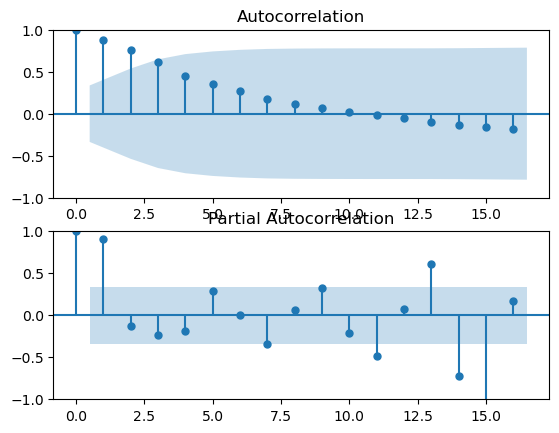

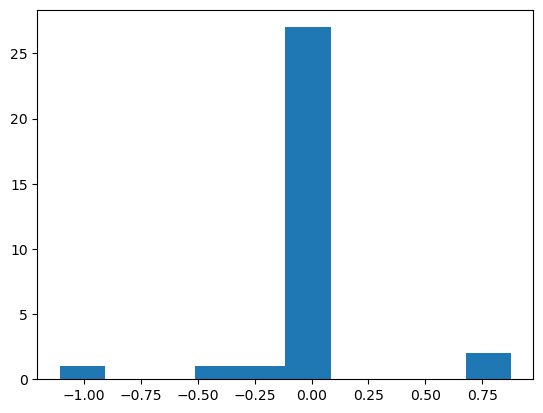

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(4, 0, 1)   Log Likelihood                  21.892
Date:                Sat, 02 Sep 2023   AIC                            -31.784
Time:                        12:47:39   BIC                            -22.990
Sample:                             0   HQIC                           -28.869
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6933      1.126     -0.616      0.538      -2.901       1.514
ar.L2         -1.6461      1.179     -1.397      0.163      -3.956       0.664
ar.L3         -0.5335      2.531     -0.211      0.8

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.907527
33   -1.265842
34   -0.380993
35    1.307129
36   -0.181268
37   -1.017386
38    0.548898
39    0.559208
40   -0.633215
41   -0.126992
42    0.482851
43   -0.143742
dtype: float64

first_diff 0.0 vuosi
1989             NaN
1990    0.000000e+00
1991    0.000000e+00
1992    0.000000e+00
1993    0.000000e+00
1994    0.000000e+00
1995    0.000000e+00
1996    0.000000e+00
1997    0.000000e+00
1998    0.000000e+00
1999    0.000000e+00
2000    3.234767e-07
2001    9.704313e-07
2002    3.881744e-06
2003    1.552728e-05
2004    6.211393e-05
2005    2.485329e-04
2006    4.872798e-04
2007    1.376418e-03
2008    2.047879e-03
2009    5.614739e-03
2010    4.654073e-03
2011    2.678782e-03
2012    0.000000e+00
2013    1.629439e-02
2014    3.967107e-03
2015    4.118028e-02
2016    1.234353e-01
2017    0.000000e+00
2018    8.146472e-02
2019    8.573369e-01
2020    5.194128e-01
2021   -5.838700e-01
2022    2.910123e-01
Name: some_35_44, dtype: float64
x shape (45, 1)
first_value 0.0
y shape (46, 1)
y                val
1989  0.000000e+00
1990  0.000000e+00
1991  0.000000e+00
1992  0.000000e+00
1993  0.000000e+00
1994  0.000000e+00
1995  0.000000e+00
1996  0.000000e+00
1997  0.000

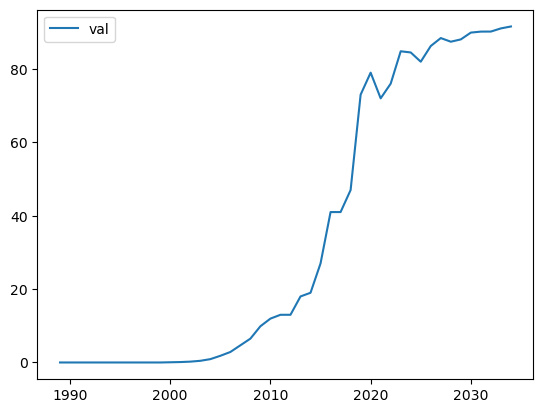

forecasting avioituvuus_25_29
deftrain vuosi
1989    88.3
1990    87.5
1991    86.0
1992    81.1
1993    84.8
1994    84.1
1995    78.5
1996    78.5
1997    75.5
1998    74.8
1999    74.4
2000    76.9
2001    72.7
2002    79.4
2003    75.6
2004    81.1
2005    80.5
2006    77.0
2007    78.8
2008    80.5
2009    76.5
2010    75.9
2011    68.9
2012    69.6
2013    59.7
2014    56.7
2015    54.7
2016    52.6
2017    48.7
2018    45.3
2019    39.3
2020    36.3
2021    35.0
2022    36.5
Name: avioituvuus_25_29, dtype: float64
vuosi
1989         NaN
1990   -0.272371
1991   -0.426421
1992   -0.918653
1993    0.638443
1994   -0.143791
1995   -0.810552
1996    0.000000
1997   -0.279977
1998   -0.055548
1999   -0.030346
2000    0.207325
2001   -0.326126
2002    0.584870
2003   -0.371973
2004    0.587675
2005   -0.080482
2006   -0.384712
2007    0.181734
2008    0.202978
2009   -0.430165
2010   -0.052004
2011   -0.455191
2012    0.035798
2013   -0.385766
2014   -0.079966
2015   -0.046856
2016   -

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


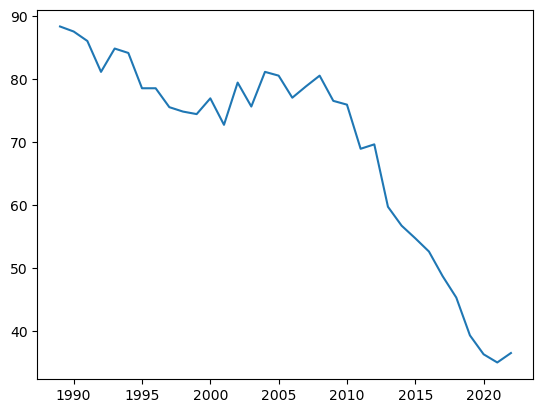

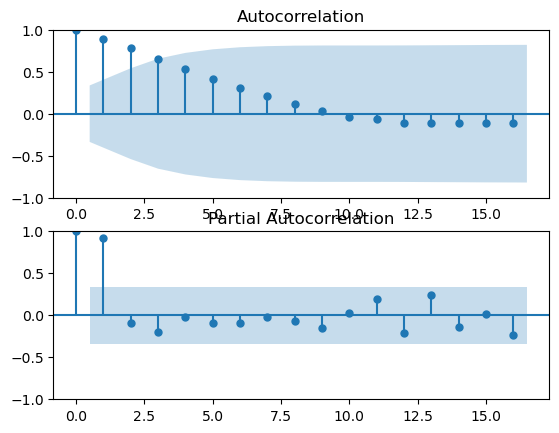

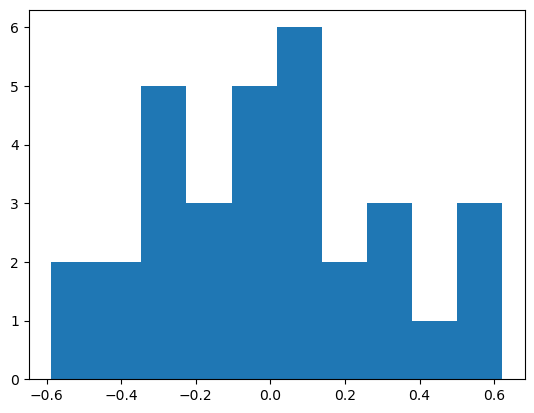

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   8.679
Date:                Sat, 02 Sep 2023   AIC                            -11.357
Time:                        12:47:40   BIC                             -6.960
Sample:                             0   HQIC                            -9.900
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2176      0.220     -5.533      0.000      -1.649      -0.786
ma.L2          0.5351      0.189      2.835      0.005       0.165       0.905
sigma2         0.0323      0.011      3.073      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32   -0.257109
33    0.131065
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

first_diff -0.07524111675089062 vuosi
1989         NaN
1990   -0.075241
1991   -0.130620
1992   -0.358769
1993    0.262479
1994   -0.053313
1995   -0.370642
1996    0.000000
1997   -0.169586
1998   -0.037486
1999   -0.021110
2000    0.135810
2001   -0.223219
2002    0.369753
2003   -0.218334
2004    0.325648
2005   -0.038678
2006   -0.209532
2007    0.104601
2008    0.104931
2009   -0.237552
2010   -0.033085
2011   -0.351756
2012    0.032874
2013   -0.435341
2014   -0.123359
2015   -0.081065
2016   -0.084463
2017   -0.156106
2018   -0.136545
2019   -0.246163
2020   -0.127648
2021   -0.056672
2022    0.065312
Name: avioituvuus_25_29, dtype: float64
x shape (45, 1)
first_value 2.021151265806204
y shape (46, 1)
y            val
1989  2.021151
1990 -0.075241
1991 -0.130620
1992 -0.358769
1993  0.262479
1994 -0.053313
1995 -0.370642
1996  0.000000
1997 -0.169586
1998 -0.037486
1999 -0.021110
2000  0.135810
2001 -0.223219
2002  0.369753
2003 -0.218334
2004  0.325648
2005 -0.038678
2006 -0.20

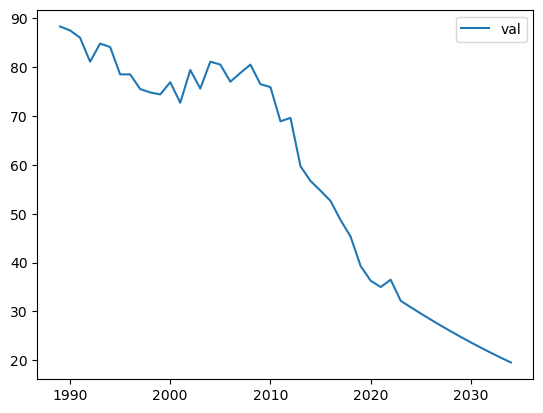

forecasting avioituvuus_30_34
deftrain vuosi
1989    49.6
1990    51.4
1991    50.5
1992    49.5
1993    53.6
1994    54.2
1995    52.6
1996    55.4
1997    51.1
1998    52.7
1999    53.0
2000    59.1
2001    55.2
2002    59.7
2003    59.8
2004    69.1
2005    71.8
2006    69.1
2007    73.3
2008    75.1
2009    72.7
2010    73.6
2011    70.2
2012    66.4
2013    59.8
2014    57.6
2015    56.0
2016    53.8
2017    51.1
2018    46.6
2019    42.9
2020    42.5
2021    40.7
2022    43.2
Name: avioituvuus_30_34, dtype: float64
vuosi
1989         NaN
1990    0.072015
1991   -0.036014
1992   -0.040001
1993    0.164250
1994    0.024147
1995   -0.064303
1996    0.112752
1997   -0.172839
1998    0.064098
1999    0.012039
2000    0.247957
2001   -0.159346
2002    0.184226
2003    0.004158
2004    0.407660
2005    0.129764
2006   -0.129764
2007    0.205098
2008    0.094056
2009   -0.124498
2010    0.045826
2011   -0.168441
2012   -0.175669
2013   -0.284032
2014   -0.090764
2015   -0.065212
2016   -

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


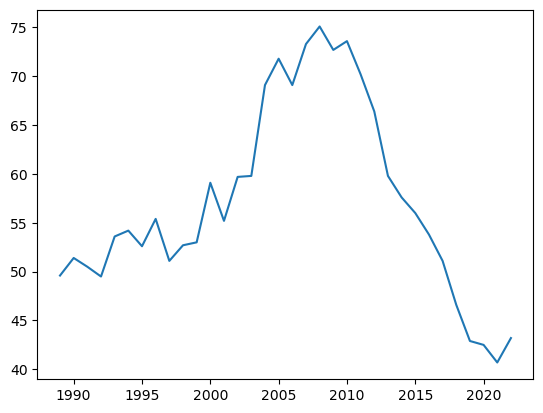

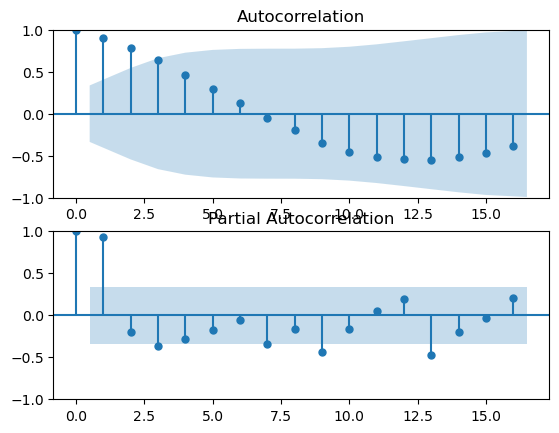

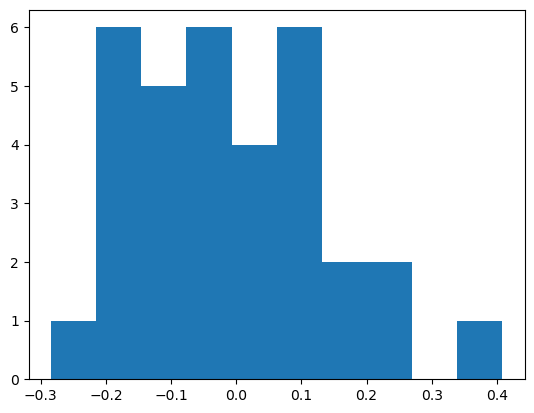

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:                        SARIMAX   Log Likelihood                  16.310
Date:                Sat, 02 Sep 2023   AIC                            -30.619
Time:                        12:47:41   BIC                            -29.123
Sample:                             0   HQIC                           -30.116
                                 - 33                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0218      0.005      4.123      0.000       0.011       0.032
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.59   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

first_value -0.0160003413464413
forecast cumsum            val
1989 -0.016000
1990  0.056015
1991  0.020001
1992 -0.020001
1993  0.144250
1994  0.168397
1995  0.104094
1996  0.216846
1997  0.044007
1998  0.108105
1999  0.120144
2000  0.368101
2001  0.208755
2002  0.392981
2003  0.397139
2004  0.804799
2005  0.934562
2006  0.804799
2007  1.009897
2008  1.103953
2009  0.979455
2010  1.025281
2011  0.856840
2012  0.681171
2013  0.397139
2014  0.306374
2015  0.241162
2016  0.152294
2017  0.044007
2018 -0.136210
2019 -0.285932
2020 -0.302281
2021 -0.376381
2022 -0.273696
2023 -0.273696
2024 -0.273696
2025 -0.273696
2026 -0.273696
2027 -0.273696
2028 -0.273696
2029 -0.273696
2030 -0.273696
2031 -0.273696
2032 -0.273696
2033 -0.273696
2034 -0.273696
forecast        val
1989  49.6
1990  51.4
1991  50.5
1992  49.5
1993  53.6
1994  54.2
1995  52.6
1996  55.4
1997  51.1
1998  52.7
1999  53.0
2000  59.1
2001  55.2
2002  59.7
2003  59.8
2004  69.1
2005  71.8
2006  69.1
2007  73.3
2008  75.1
2009  7

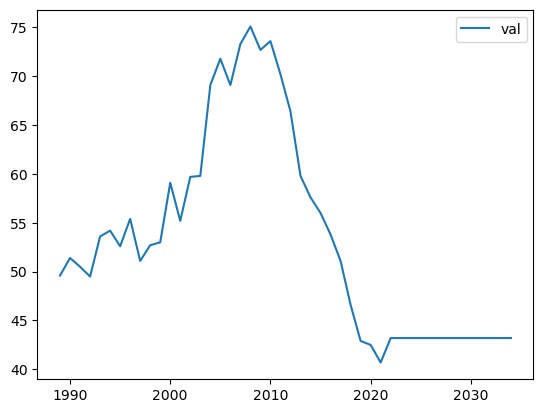

forecasting synnyttajien_keskiika
deftrain vuosi
1989    29.080000
1990    29.160071
1991    29.170250
1992    29.273838
1993    29.360658
1994    29.504384
1995    29.687610
1996    29.755130
1997    29.852071
1998    29.938362
1999    29.948293
2000    29.930651
2001    29.937986
2002    29.948762
2003    29.999488
2004    29.998615
2005    29.983955
2006    30.016630
2007    30.037350
2008    30.083874
2009    30.079639
2010    30.140161
2011    30.256492
2012    30.332535
2013    30.435631
2014    30.471048
2015    30.599564
2016    30.799523
2017    30.900000
2018    31.000000
2019    31.200000
2020    31.300000
2021    31.600000
2022    31.700000
Name: synnyttajien_keskiika, dtype: float64
vuosi
1989         NaN
1990    0.000557
1991    0.000071
1992    0.000724
1993    0.000609
1994    0.001014
1995    0.001303
1996    0.000483
1997    0.000696
1998    0.000622
1999    0.000072
2000   -0.000127
2001    0.000053
2002    0.000078
2003    0.000367
2004   -0.000006
2005   -0.000106


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


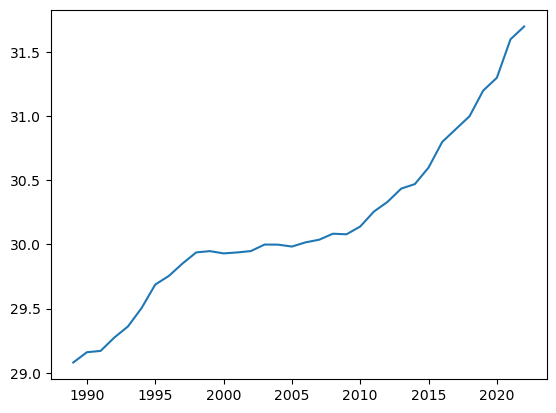

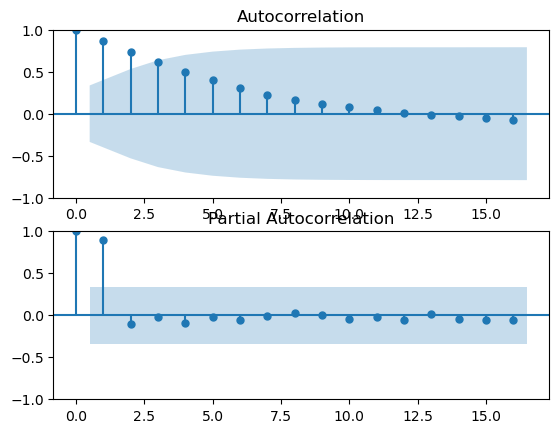

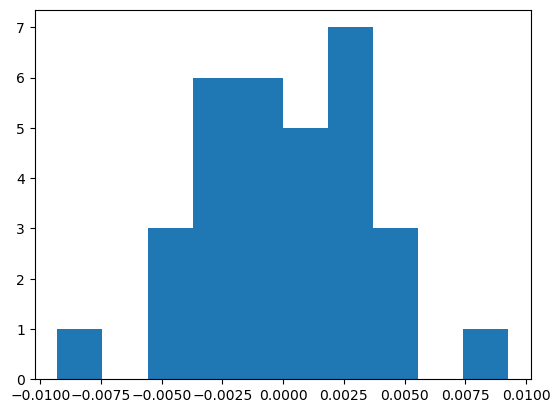

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 141.268
Date:                Sat, 02 Sep 2023   AIC                           -278.535
Time:                        12:47:42   BIC                           -275.604
Sample:                             0   HQIC                          -277.564
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6553      0.136     -4.805      0.000      -0.923      -0.388
sigma2      8.405e-06   2.54e-06      3.313      0.001    3.43e-06    1.34e-05
Ljung-Box (L1) (Q):                   0.60   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.006090
33   -0.003991
34    0.002615
35   -0.001714
36    0.001123
37   -0.000736
38    0.000482
39   -0.000316
40    0.000207
41   -0.000136
42    0.000089
43   -0.000058
dtype: float64

first_diff 0.00387936431159408 vuosi
1989         NaN
1990    0.003879
1991    0.000493
1992    0.005008
1993    0.004190
1994    0.006920
1995    0.008793
1996    0.003233
1997    0.004634
1998    0.004117
1999    0.000473
2000   -0.000841
2001    0.000350
2002    0.000514
2003    0.002417
2004   -0.000042
2005   -0.000698
2006    0.001556
2007    0.000986
2008    0.002213
2009   -0.000201
2010    0.002876
2011    0.005519
2012    0.003601
2013    0.004874
2014    0.001672
2015    0.006059
2016    0.009399
2017    0.004710
2018    0.004679
2019    0.009334
2020    0.004655
2021    0.013915
2022    0.004623
Name: synnyttajien_keskiika, dtype: float64
x shape (45, 1)
first_value -0.8915018285406885
y shape (46, 1)
y            val
1989 -0.891502
1990  0.003879
1991  0.000493
1992  0.005008
1993  0.004190
1994  0.006920
1995  0.008793
1996  0.003233
1997  0.004634
1998  0.004117
1999  0.000473
2000 -0.000841
2001  0.000350
2002  0.000514
2003  0.002417
2004 -0.000042
2005 -0.000698
2006 

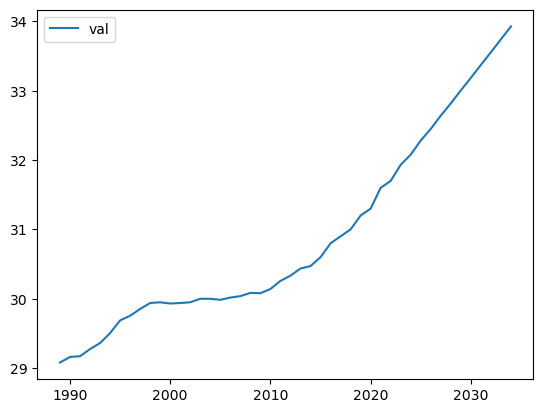

forecasting sisempikaupunki
deftrain vuosi
1989    32.50
1990    32.50
1991    32.50
1992    32.30
1993    32.40
1994    32.60
1995    33.00
1996    33.20
1997    33.50
1998    33.70
1999    33.90
2000    34.10
2001    34.30
2002    34.40
2003    34.40
2004    34.40
2005    34.40
2006    34.40
2007    34.40
2008    34.50
2009    34.70
2010    34.80
2011    34.90
2012    35.10
2013    35.40
2014    35.70
2015    35.90
2016    36.20
2017    36.50
2018    36.80
2019    37.10
2020    37.40
2021    37.50
2022    37.76
Name: sisempikaupunki, dtype: float64
vuosi
1989         NaN
1990    0.000000
1991    0.000000
1992   -0.001618
1993    0.000807
1994    0.001625
1995    0.003295
1996    0.001670
1997    0.002533
1998    0.001708
1999    0.001723
2000    0.001739
2001    0.001754
2002    0.000883
2003    0.000000
2004    0.000000
2005    0.000000
2006    0.000000
2007    0.000000
2008    0.000887
2009    0.001786
2010    0.000899
2011    0.000903
2012    0.001818
2013    0.002758
2014    0.00

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


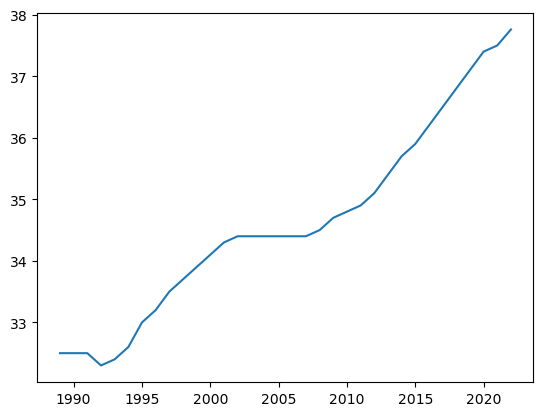

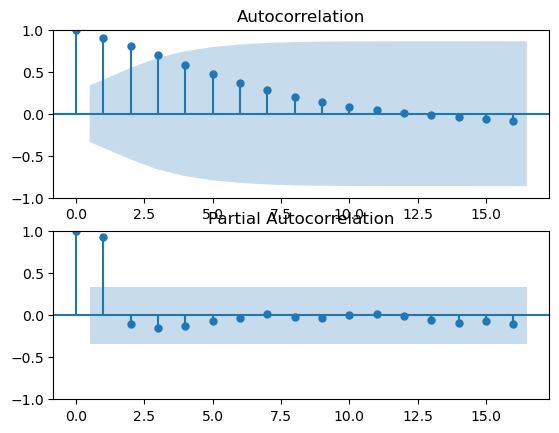

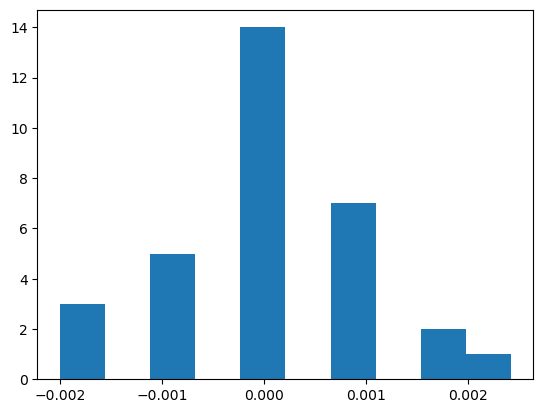

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 177.843
Date:                Sat, 02 Sep 2023   AIC                           -351.686
Time:                        12:47:44   BIC                           -348.754
Sample:                             0   HQIC                          -350.714
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2917      0.138     -2.111      0.035      -0.563      -0.021
sigma2      8.656e-07   2.28e-07      3.795      0.000    4.19e-07    1.31e-06
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32   -4.790122e-04
33    1.397145e-04
34   -4.075083e-05
35    1.188588e-05
36   -3.466781e-06
37    1.011163e-06
38   -2.949282e-07
39    8.602234e-08
40   -2.509032e-08
41    7.318148e-09
42   -2.134500e-09
43    6.225741e-10
dtype: float64

first_diff 0.0 vuosi
1989         NaN
1990    0.000000
1991    0.000000
1992   -0.001618
1993    0.000807
1994    0.001625
1995    0.003295
1996    0.001670
1997    0.002533
1998    0.001708
1999    0.001723
2000    0.001739
2001    0.001754
2002    0.000883
2003    0.000000
2004    0.000000
2005    0.000000
2006    0.000000
2007    0.000000
2008    0.000887
2009    0.001786
2010    0.000899
2011    0.000903
2012    0.001818
2013    0.002758
2014    0.002795
2015    0.001884
2016    0.002857
2017    0.002896
2018    0.002934
2019    0.002974
2020    0.003013
2021    0.001013
2022    0.002656
Name: sisempikaupunki, dtype: float64
x shape (45, 1)
first_value 0.11809923130677849
y shape (46, 1)
y            val
1989  0.118099
1990  0.000000
1991  0.000000
1992 -0.001618
1993  0.000807
1994  0.001625
1995  0.003295
1996  0.001670
1997  0.002533
1998  0.001708
1999  0.001723
2000  0.001739
2001  0.001754
2002  0.000883
2003  0.000000
2004  0.000000
2005  0.000000
2006  0.000000
2007  0.0000

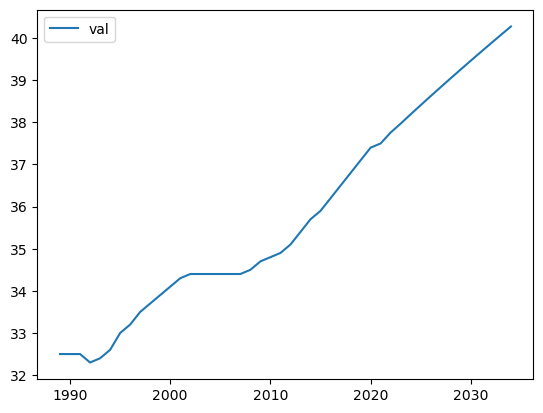

forecasting ulompikaupunki
deftrain vuosi
1989    20.5
1990    20.5
1991    20.8
1992    21.1
1993    21.3
1994    21.4
1995    21.4
1996    21.5
1997    21.5
1998    21.6
1999    21.7
2000    21.8
2001    21.9
2002    22.1
2003    22.2
2004    22.4
2005    22.5
2006    22.7
2007    22.8
2008    22.9
2009    23.0
2010    23.1
2011    23.2
2012    23.3
2013    23.3
2014    23.4
2015    23.5
2016    23.6
2017    23.6
2018    23.7
2019    23.8
2020    23.9
2021    24.1
2022    24.2
Name: ulompikaupunki, dtype: float64
vuosi
1989         NaN
1990    0.000000
1991    0.001352
1992    0.001375
1993    0.000930
1994    0.000469
1995    0.000000
1996    0.000471
1997    0.000000
1998    0.000474
1999    0.000477
2000    0.000479
2001    0.000482
2002    0.000972
2003    0.000490
2004    0.000988
2005    0.000498
2006    0.001004
2007    0.000506
2008    0.000509
2009    0.000511
2010    0.000514
2011    0.000517
2012    0.000520
2013    0.000000
2014    0.000522
2015    0.000525
2016    0.0005

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


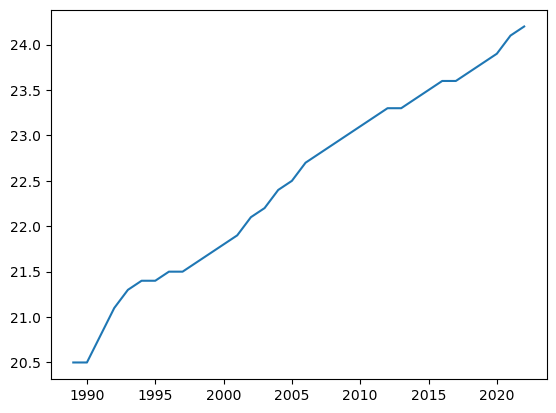

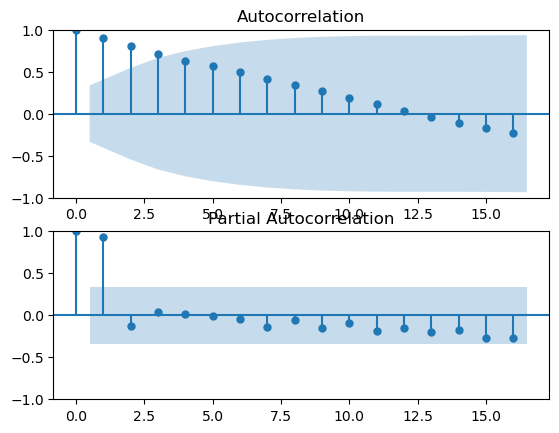

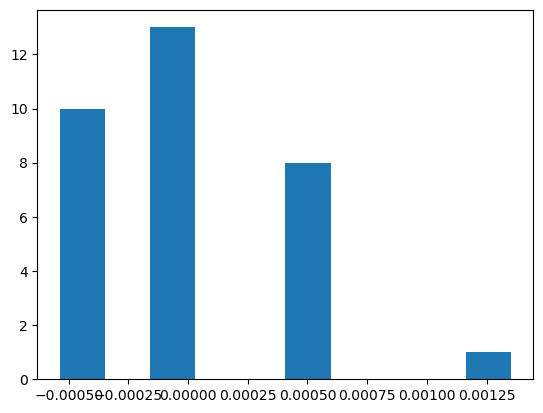

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 205.748
Date:                Sat, 02 Sep 2023   AIC                           -407.496
Time:                        12:47:45   BIC                           -404.565
Sample:                             0   HQIC                          -406.525
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5120      0.195     -2.628      0.009      -0.894      -0.130
sigma2      1.508e-07   3.19e-08      4.733      0.000    8.83e-08    2.13e-07
Ljung-Box (L1) (Q):                   0.04   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.000121
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

first_diff 0.0 vuosi
1989         NaN
1990    0.000000
1991    0.001352
1992    0.001375
1993    0.000930
1994    0.000469
1995    0.000000
1996    0.000471
1997    0.000000
1998    0.000474
1999    0.000477
2000    0.000479
2001    0.000482
2002    0.000972
2003    0.000490
2004    0.000988
2005    0.000498
2006    0.001004
2007    0.000506
2008    0.000509
2009    0.000511
2010    0.000514
2011    0.000517
2012    0.000520
2013    0.000000
2014    0.000522
2015    0.000525
2016    0.000528
2017    0.000000
2018    0.000531
2019    0.000533
2020    0.000536
2021    0.001081
2022    0.000545
Name: ulompikaupunki, dtype: float64
x shape (45, 1)
first_value 0.04386857694616247
y shape (46, 1)
y            val
1989  0.043869
1990  0.000000
1991  0.001352
1992  0.001375
1993  0.000930
1994  0.000469
1995  0.000000
1996  0.000471
1997  0.000000
1998  0.000474
1999  0.000477
2000  0.000479
2001  0.000482
2002  0.000972
2003  0.000490
2004  0.000988
2005  0.000498
2006  0.001004
2007  0.00050

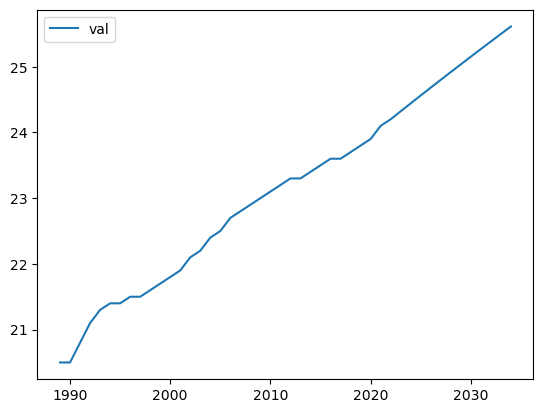

forecasting kehyskaupunki
deftrain vuosi
1989     9.90
1990     9.90
1991    10.00
1992    10.00
1993    10.00
1994    10.00
1995    10.00
1996    10.00
1997    10.00
1998    10.10
1999    10.10
2000    10.20
2001    10.30
2002    10.30
2003    10.40
2004    10.50
2005    10.60
2006    10.70
2007    10.80
2008    10.90
2009    10.90
2010    10.90
2011    11.00
2012    11.00
2013    11.00
2014    10.90
2015    10.90
2016    10.90
2017    10.90
2018    10.80
2019    10.80
2020    10.80
2021    10.80
2022    10.78
Name: kehyskaupunki, dtype: float64
vuosi
1989         NaN
1990    0.000000
1991    0.000203
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.000000
1998    0.000205
1999    0.000000
2000    0.000207
2001    0.000209
2002    0.000000
2003    0.000212
2004    0.000214
2005    0.000216
2006    0.000218
2007    0.000220
2008    0.000222
2009    0.000000
2010    0.000000
2011    0.000224
2012    0.000000
2013    0.000000
2014   -0.000224

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


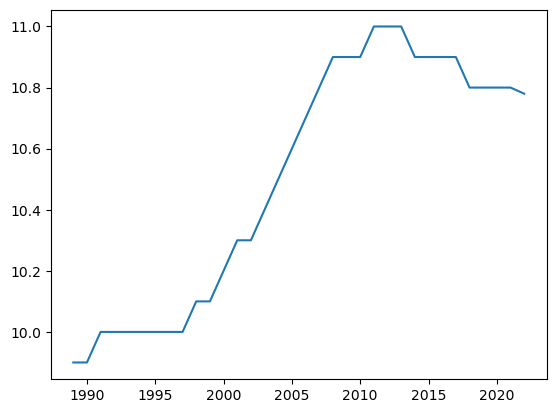

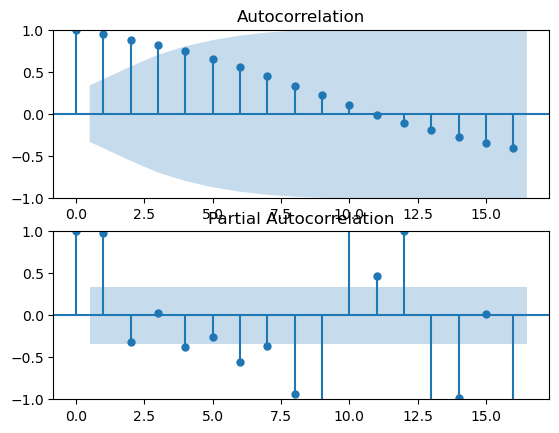

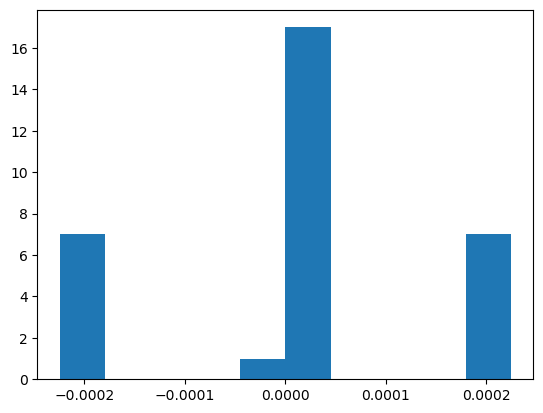

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 244.686
Date:                Sat, 02 Sep 2023   AIC                           -485.372
Time:                        12:47:46   BIC                           -482.440
Sample:                             0   HQIC                          -484.400
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7331   7.45e-18  -9.85e+16      0.000      -0.733      -0.733
sigma2       1.26e-08   3.27e-09      3.851      0.000    6.19e-09     1.9e-08
Ljung-Box (L1) (Q):                   0.04   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.000014
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

first_diff 0.0 vuosi
1989         NaN
1990    0.000000
1991    0.000203
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.000000
1998    0.000205
1999    0.000000
2000    0.000207
2001    0.000209
2002    0.000000
2003    0.000212
2004    0.000214
2005    0.000216
2006    0.000218
2007    0.000220
2008    0.000222
2009    0.000000
2010    0.000000
2011    0.000224
2012    0.000000
2013    0.000000
2014   -0.000224
2015    0.000000
2016    0.000000
2017    0.000000
2018   -0.000222
2019    0.000000
2020    0.000000
2021    0.000000
2022   -0.000044
Name: kehyskaupunki, dtype: float64
x shape (45, 1)
first_value 0.009898010399929711
y shape (46, 1)
y            val
1989  0.009898
1990  0.000000
1991  0.000203
1992  0.000000
1993  0.000000
1994  0.000000
1995  0.000000
1996  0.000000
1997  0.000000
1998  0.000205
1999  0.000000
2000  0.000207
2001  0.000209
2002  0.000000
2003  0.000212
2004  0.000214
2005  0.000216
2006  0.000218
2007  0.00022

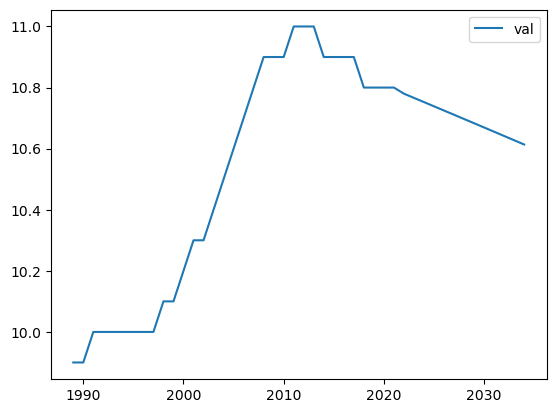

forecasting maaseudulla
deftrain vuosi
1989    35.70
1990    35.70
1991    35.60
1992    35.40
1993    35.20
1994    34.90
1995    34.50
1996    34.10
1997    33.70
1998    33.40
1999    33.20
2000    32.80
2001    32.40
2002    32.20
2003    31.90
2004    31.70
2005    31.50
2006    31.20
2007    31.00
2008    30.70
2009    30.40
2010    30.10
2011    29.80
2012    29.50
2013    29.20
2014    28.90
2015    28.50
2016    28.10
2017    27.80
2018    27.40
2019    27.00
2020    26.70
2021    26.50
2022    26.18
Name: maaseudulla, dtype: float64
vuosi
1989         NaN
1990    0.000000
1991   -0.000936
1992   -0.001859
1993   -0.001843
1994   -0.002733
1995   -0.003588
1996   -0.003525
1997   -0.003462
1998   -0.002556
1999   -0.001685
2000   -0.003325
2001   -0.003265
2002   -0.001611
2003   -0.002389
2004   -0.001574
2005   -0.001560
2006   -0.002313
2007   -0.001525
2008   -0.002261
2009   -0.002230
2010   -0.002199
2011   -0.002169
2012   -0.002138
2013   -0.002109
2014   -0.002079
201

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


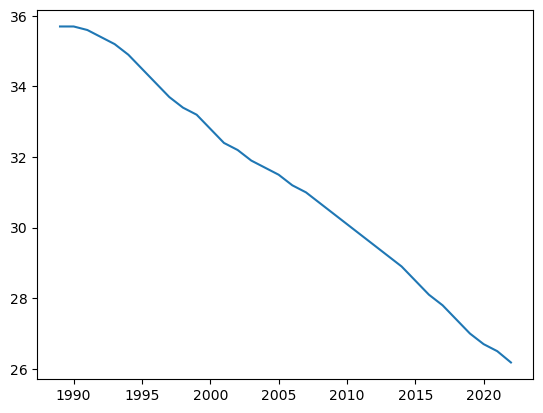

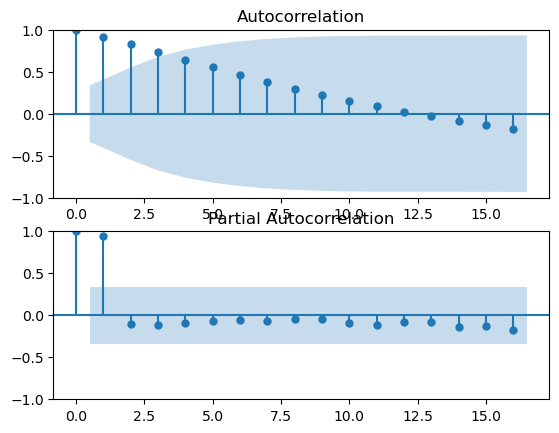

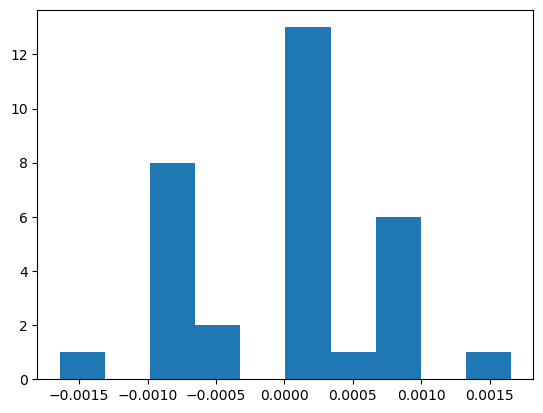

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                        SARIMAX   Log Likelihood                 186.800
Date:                Sat, 02 Sep 2023   AIC                           -371.600
Time:                        12:47:48   BIC                           -370.134
Sample:                             0   HQIC                          -371.114
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.979e-07   1.34e-07      3.716      0.000    2.35e-07    7.61e-07
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.32   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

first_diff 0.0 vuosi
1989         NaN
1990    0.000000
1991   -0.000936
1992   -0.001859
1993   -0.001843
1994   -0.002733
1995   -0.003588
1996   -0.003525
1997   -0.003462
1998   -0.002556
1999   -0.001685
2000   -0.003325
2001   -0.003265
2002   -0.001611
2003   -0.002389
2004   -0.001574
2005   -0.001560
2006   -0.002313
2007   -0.001525
2008   -0.002261
2009   -0.002230
2010   -0.002199
2011   -0.002169
2012   -0.002138
2013   -0.002109
2014   -0.002079
2015   -0.002727
2016   -0.002675
2017   -0.001973
2018   -0.002587
2019   -0.002538
2020   -0.001871
2021   -0.001232
2022   -0.001946
Name: maaseudulla, dtype: float64
x shape (45, 1)
first_value 0.14606481454952208
y shape (46, 1)
y            val
1989  0.146065
1990  0.000000
1991 -0.000936
1992 -0.001859
1993 -0.001843
1994 -0.002733
1995 -0.003588
1996 -0.003525
1997 -0.003462
1998 -0.002556
1999 -0.001685
2000 -0.003325
2001 -0.003265
2002 -0.001611
2003 -0.002389
2004 -0.001574
2005 -0.001560
2006 -0.002313
2007 -0.001525
2

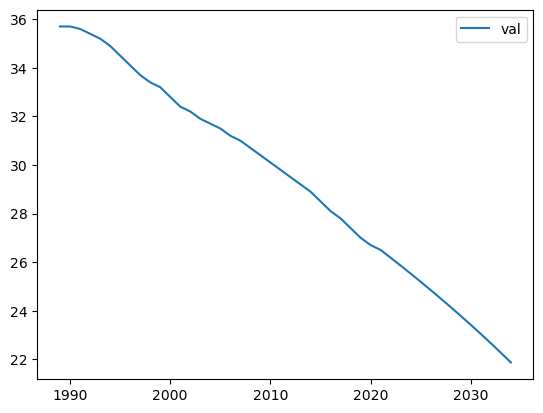

In [6]:

data2=predict_arima(data,2022)

forecasting alypuhelin


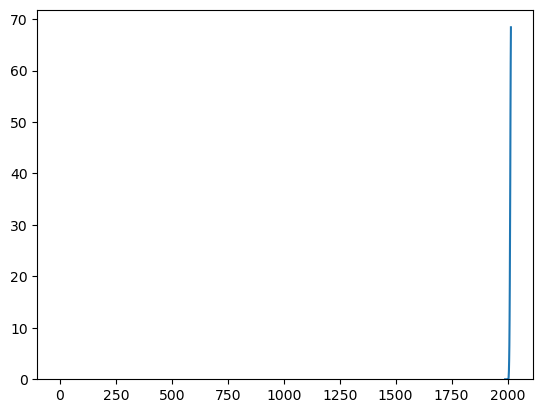

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  62.339
Date:                Sat, 02 Sep 2023   AIC                           -120.678
Time:                        12:47:50   BIC                           -118.322
Sample:                             0   HQIC                          -120.053
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.004      0.241      0.809      -0.007       0.009
sigma2         0.0003   5.04e-05      6.439      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.35   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25    0.024535
26    0.025517
27    0.026498
28    0.027479
29    0.028461
30    0.029442
31    0.030424
32    0.031405
33    0.032386
34    0.033368
35    0.034349
36    0.035331
37    0.036312
38    0.037294
39    0.038275
40    0.039256
41    0.040238
42    0.041219
43    0.042201
dtype: float64

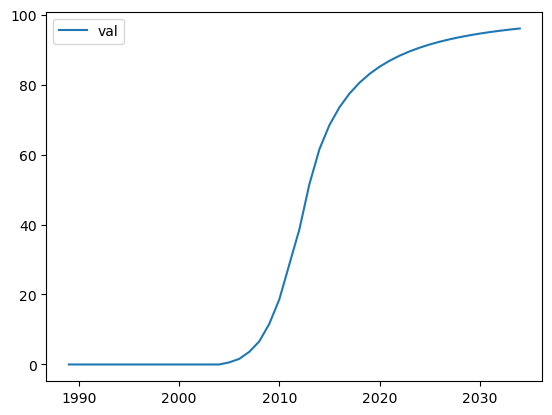

forecasting some_25_34


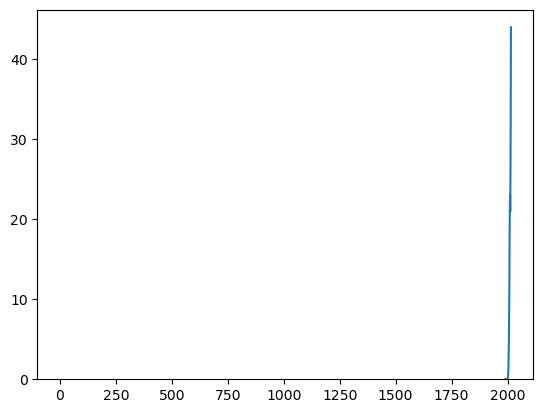

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(2, 0, 2)   Log Likelihood                  77.390
Date:                Sat, 02 Sep 2023   AIC                           -144.781
Time:                        12:47:51   BIC                           -138.686
Sample:                             0   HQIC                          -143.090
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3469      0.536     -0.647      0.518      -1.398       0.705
ar.L2          0.5795      0.571      1.015      0.310      -0.539       1.698
ma.L1          1.0793      0.692      1.560      0.1

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25    0.012194
26    0.051323
27   -0.010735
28    0.033466
29   -0.017829
30    0.025579
31   -0.019204
32    0.021485
33   -0.018582
34    0.018896
35   -0.017323
36    0.016959
37   -0.015921
38    0.015351
39   -0.014551
40    0.013943
41   -0.013269
42    0.012683
43   -0.012089
dtype: float64

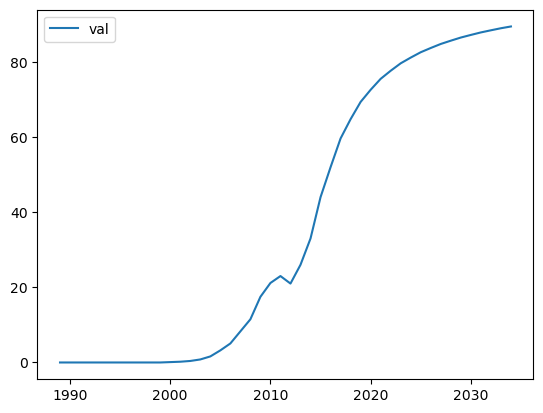

forecasting some_35_44


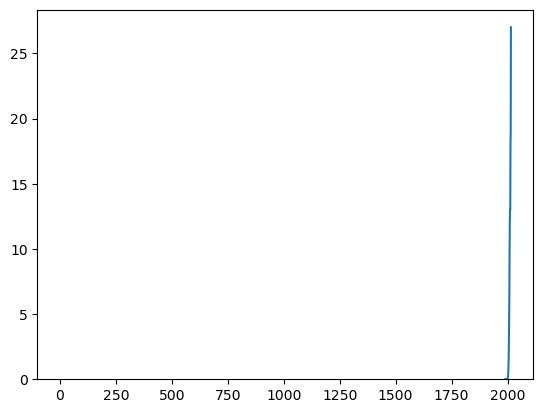

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(1, 0, 2)   Log Likelihood                  96.606
Date:                Sat, 02 Sep 2023   AIC                           -185.212
Time:                        12:47:52   BIC                           -180.336
Sample:                             0   HQIC                          -183.859
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8706      0.306     -2.841      0.004      -1.471      -0.270
ma.L1          0.2257      0.732      0.308      0.758      -1.209       1.660
ma.L2          0.8981      0.250      3.590      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25   -0.029858
26    0.033879
27   -0.029495
28    0.025678
29   -0.022355
30    0.019462
31   -0.016944
32    0.014751
33   -0.012842
34    0.011180
35   -0.009733
36    0.008474
37   -0.007377
38    0.006423
39   -0.005592
40    0.004868
41   -0.004238
42    0.003690
43   -0.003212
dtype: float64

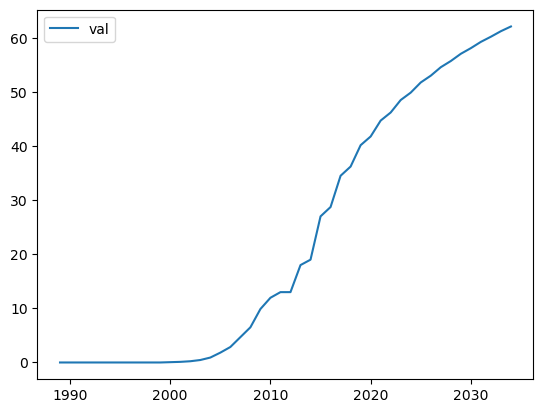

forecasting avioituvuus_25_29


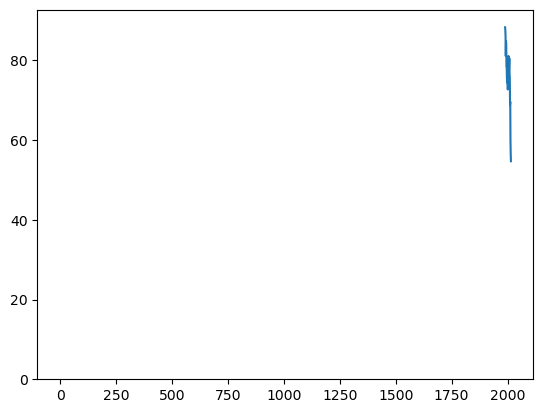

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(1, 0, 2)   Log Likelihood                   5.567
Date:                Sat, 02 Sep 2023   AIC                             -3.134
Time:                        12:47:53   BIC                              1.742
Sample:                             0   HQIC                            -1.782
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0331      0.344     -0.096      0.923      -0.707       0.641
ma.L1         -1.3019      0.275     -4.740      0.000      -1.840      -0.764
ma.L2          0.6844      0.262      2.614      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25   -2.505384e-01
26    1.358260e-01
27   -4.502367e-03
28    1.492447e-04
29   -4.947172e-06
30    1.639891e-07
31   -5.435921e-09
32    1.801902e-10
33   -5.972956e-12
34    1.979919e-13
35   -6.563046e-15
36    2.175522e-16
37   -7.211433e-18
38    2.390450e-19
39   -7.923877e-21
40    2.626611e-22
41   -8.706706e-24
42    2.886104e-25
43   -9.566873e-27
dtype: float64

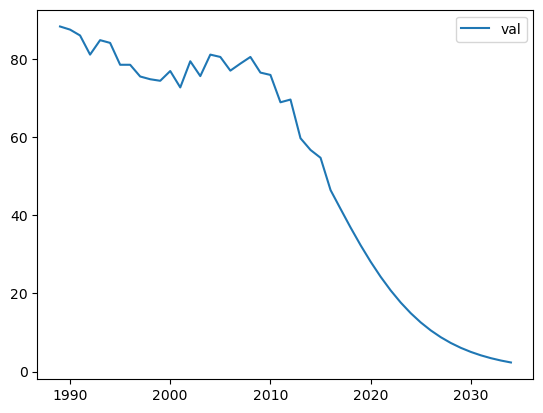

forecasting avioituvuus_30_34


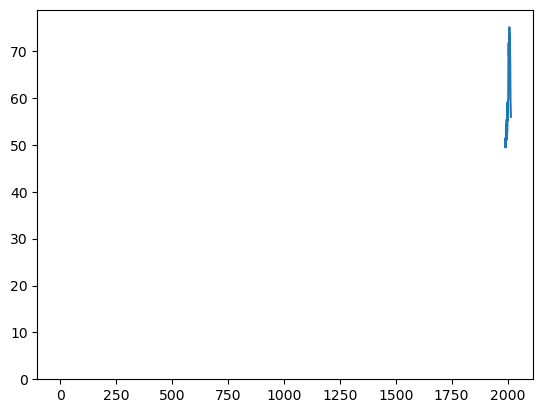

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:                        SARIMAX   Log Likelihood                  11.506
Date:                Sat, 02 Sep 2023   AIC                            -21.012
Time:                        12:47:54   BIC                            -19.754
Sample:                             0   HQIC                           -20.650
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0242      0.007      3.636      0.000       0.011       0.037
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.78
Prob(Q):                              0.96   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

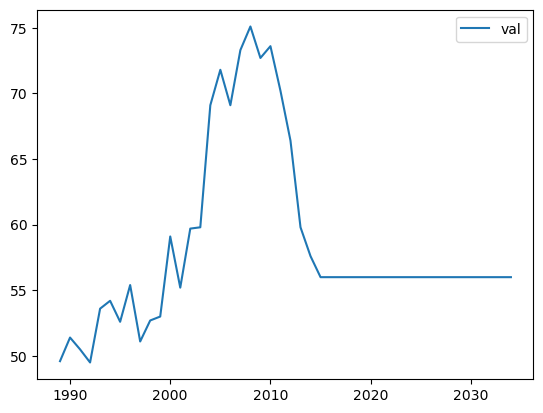

forecasting synnyttajien_keskiika


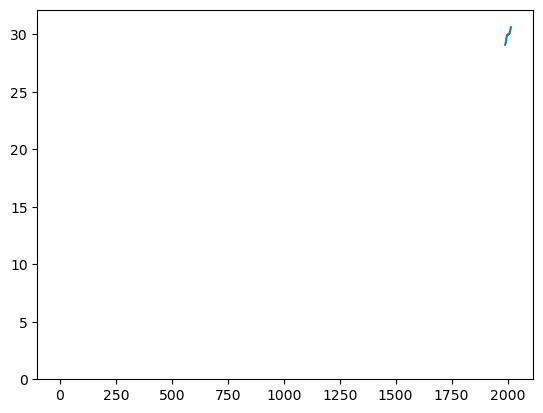

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 115.950
Date:                Sat, 02 Sep 2023   AIC                           -227.899
Time:                        12:47:55   BIC                           -225.462
Sample:                             0   HQIC                          -227.223
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4190      0.182     -2.304      0.021      -0.775      -0.063
sigma2      5.431e-06   2.27e-06      2.393      0.017    9.83e-07    9.88e-06
Ljung-Box (L1) (Q):                   0.14   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25   -0.001357
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

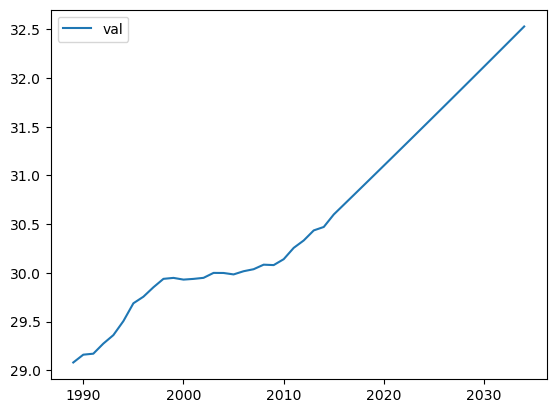

forecasting sisempikaupunki


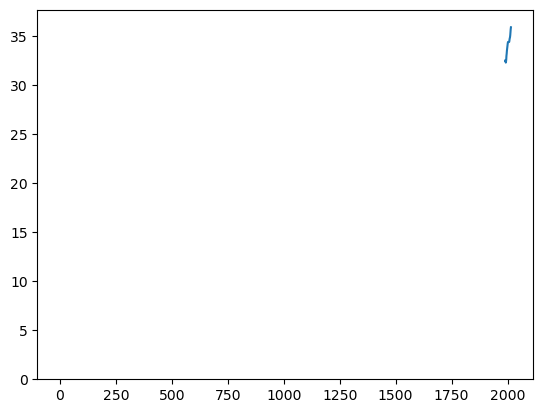

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:                        SARIMAX   Log Likelihood                 138.540
Date:                Sat, 02 Sep 2023   AIC                           -275.081
Time:                        12:47:56   BIC                           -273.862
Sample:                             0   HQIC                          -274.743
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.998e-07   2.48e-07      3.629      0.000    4.14e-07    1.39e-06
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.34   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

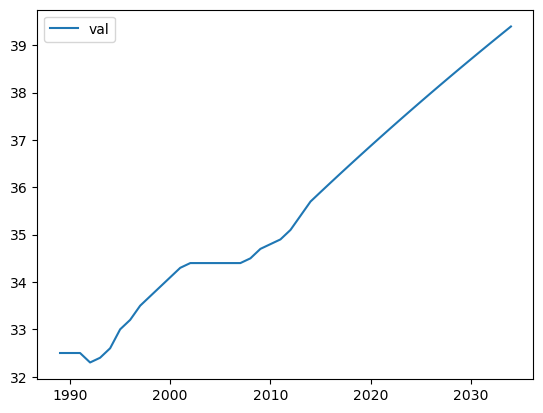

forecasting ulompikaupunki


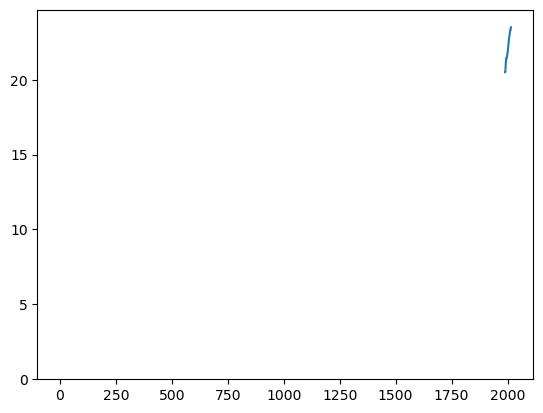

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 159.466
Date:                Sat, 02 Sep 2023   AIC                           -314.932
Time:                        12:47:57   BIC                           -312.494
Sample:                             0   HQIC                          -314.256
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4417      0.214     -2.063      0.039      -0.861      -0.022
sigma2      1.638e-07   3.79e-08      4.323      0.000    8.95e-08    2.38e-07
Ljung-Box (L1) (Q):                   0.06   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25   -0.000058
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

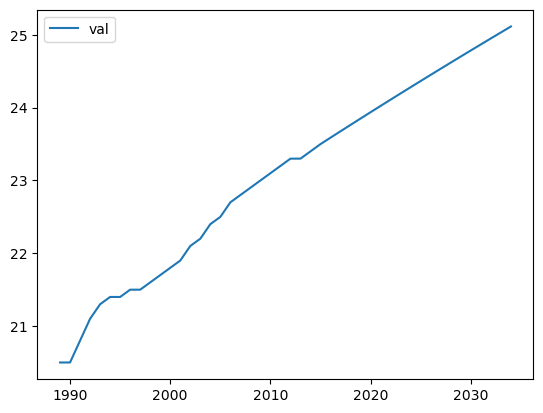

forecasting kehyskaupunki


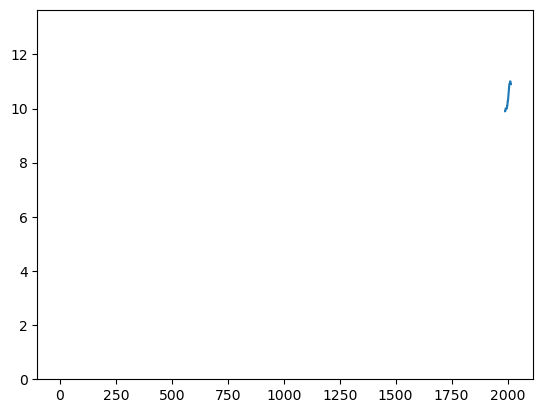

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 189.856
Date:                Sat, 02 Sep 2023   AIC                           -375.713
Time:                        12:47:58   BIC                           -373.275
Sample:                             0   HQIC                          -375.036
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7063   9.02e-18  -7.83e+16      0.000      -0.706      -0.706
sigma2      1.398e-08   4.48e-09      3.123      0.002    5.21e-09    2.28e-08
Ljung-Box (L1) (Q):                   0.02   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25   -0.000019
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

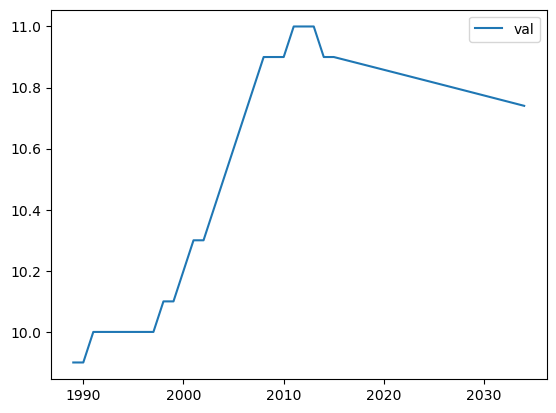

forecasting maaseudulla


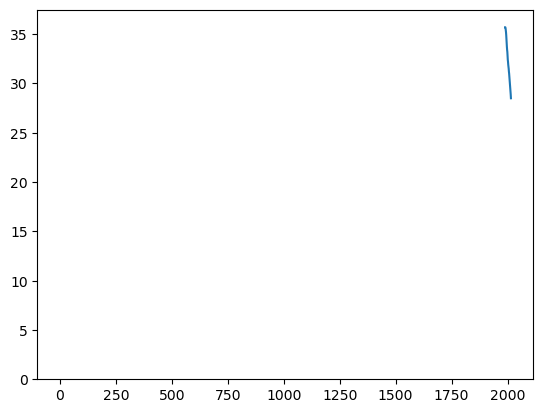

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:                        SARIMAX   Log Likelihood                 144.743
Date:                Sat, 02 Sep 2023   AIC                           -287.487
Time:                        12:47:59   BIC                           -286.268
Sample:                             0   HQIC                          -287.149
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.478e-07   1.66e-07      3.305      0.001    2.23e-07    8.73e-07
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.36   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

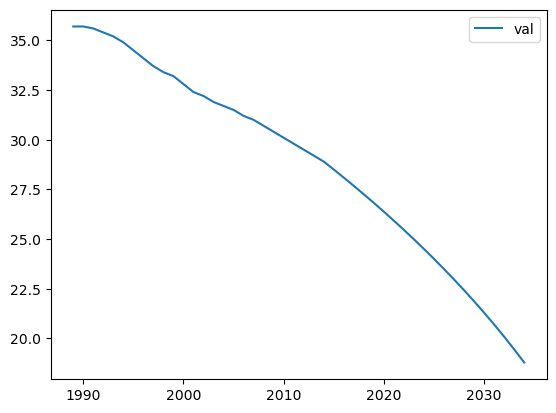

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

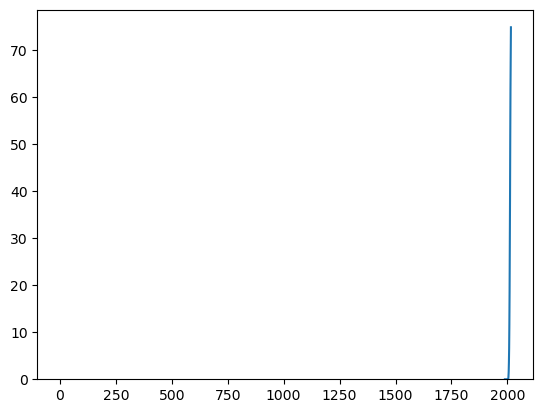

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 1, 3)   Log Likelihood                  64.480
Date:                Sat, 02 Sep 2023   AIC                           -118.959
Time:                        12:48:01   BIC                           -112.865
Sample:                             0   HQIC                          -117.269
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.011      0.355      0.723      -0.018       0.026
ma.L1         -0.4494      0.263     -1.707      0.088      -0.965       0.067
ma.L2         -0.4746      0.272     -1.743      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.116361
27    0.089811
28    0.109491
29    0.113455
30    0.117420
31    0.121384
32    0.125349
33    0.129313
34    0.133278
35    0.137243
36    0.141207
37    0.145172
38    0.149136
39    0.153101
40    0.157065
41    0.161030
42    0.164994
43    0.168959
dtype: float64

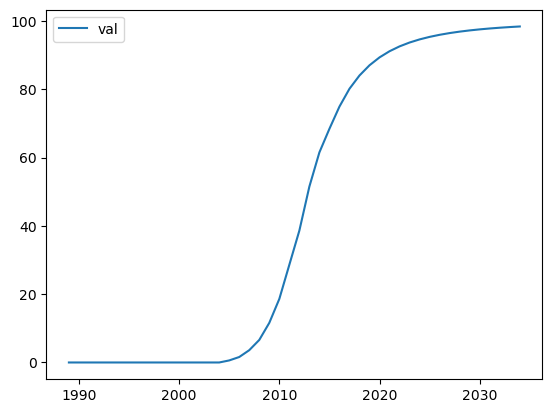

forecasting some_25_34


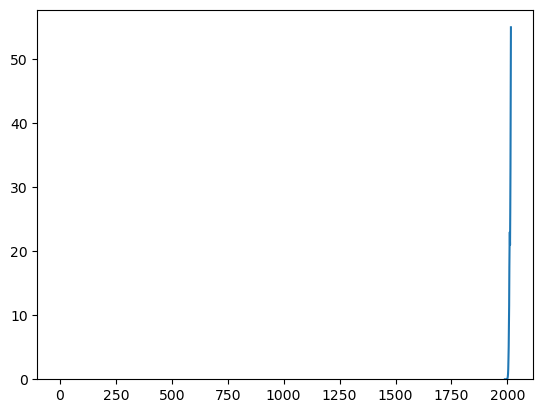

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(3, 0, 0)   Log Likelihood                  75.330
Date:                Sat, 02 Sep 2023   AIC                           -142.660
Time:                        12:48:03   BIC                           -137.628
Sample:                             0   HQIC                          -141.211
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8780      0.307      2.864      0.004       0.277       1.479
ar.L2          0.5823      0.357      1.630      0.103      -0.118       1.282
ar.L3         -0.5618      0.355     -1.581      0.1

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.093079
27    0.087533
28    0.088501
29    0.076381
30    0.069419
31    0.055706
32    0.046420
33    0.034194
34    0.025756
35    0.016445
36    0.010226
37    0.004084
38    0.000301
39   -0.003102
40   -0.004843
41   -0.006228
42   -0.006545
43   -0.006652
dtype: float64

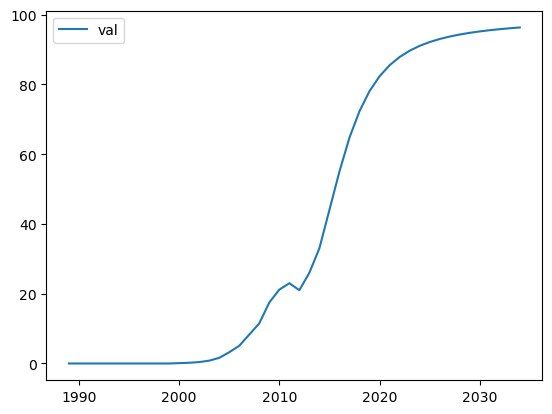

forecasting some_35_44


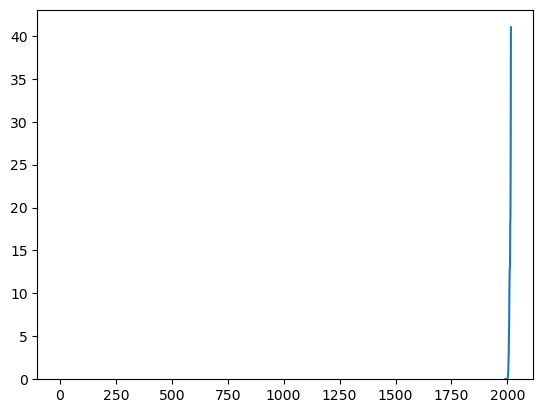

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 0, 1)   Log Likelihood                  71.803
Date:                Sat, 02 Sep 2023   AIC                           -139.605
Time:                        12:48:04   BIC                           -137.089
Sample:                             0   HQIC                          -138.881
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7360      0.052     14.154      0.000       0.634       0.838
sigma2         0.0002   2.99e-05      7.585      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.030006
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

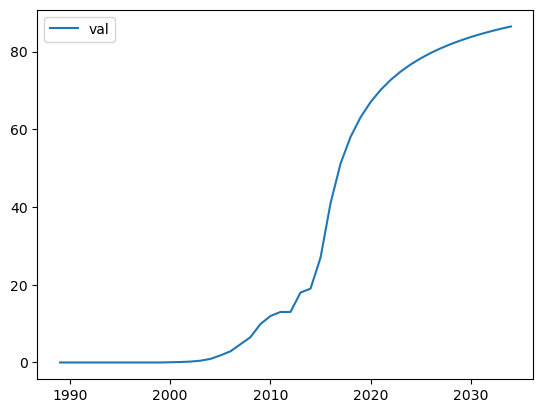

forecasting avioituvuus_25_29


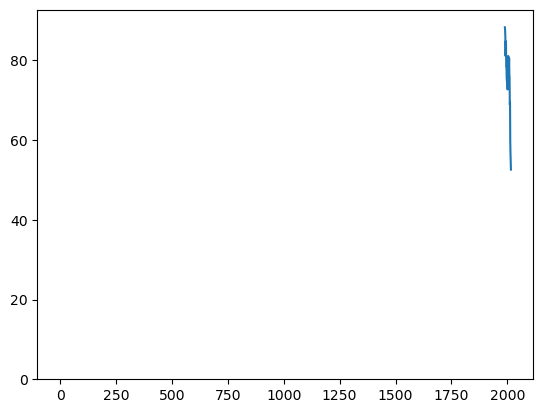

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   5.531
Date:                Sat, 02 Sep 2023   AIC                             -5.063
Time:                        12:48:05   BIC                             -1.288
Sample:                             0   HQIC                            -3.976
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2466      0.228     -5.462      0.000      -1.694      -0.799
ma.L2          0.6122      0.200      3.060      0.002       0.220       1.004
sigma2         0.0356      0.014      2.573      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26   -0.164286
27    0.134974
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

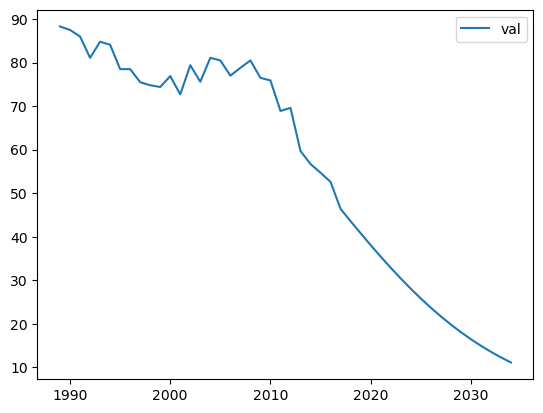

forecasting avioituvuus_30_34


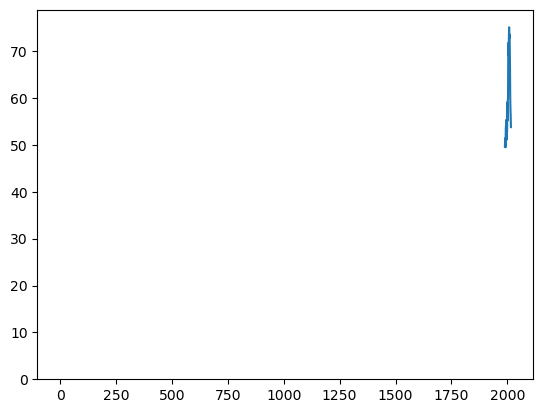

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:                        SARIMAX   Log Likelihood                  12.289
Date:                Sat, 02 Sep 2023   AIC                            -22.579
Time:                        12:48:06   BIC                            -21.283
Sample:                             0   HQIC                           -22.194
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0236      0.006      3.744      0.000       0.011       0.036
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.91   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

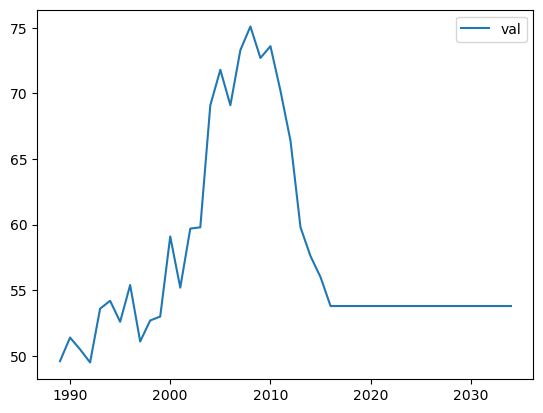

forecasting synnyttajien_keskiika


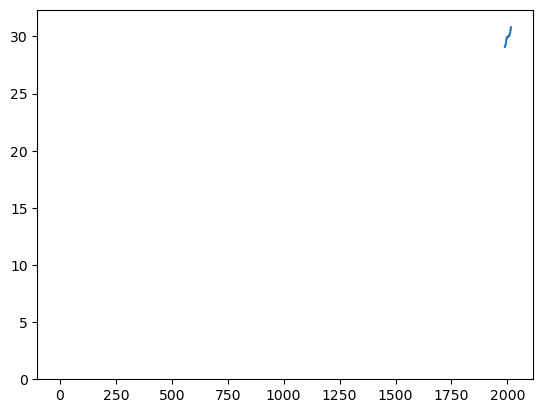

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 118.972
Date:                Sat, 02 Sep 2023   AIC                           -233.945
Time:                        12:48:07   BIC                           -231.429
Sample:                             0   HQIC                          -233.220
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2616      0.209     -1.254      0.210      -0.670       0.147
sigma2      6.191e-06   2.46e-06      2.520      0.012    1.38e-06     1.1e-05
Ljung-Box (L1) (Q):                   0.25   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26   -0.001121
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

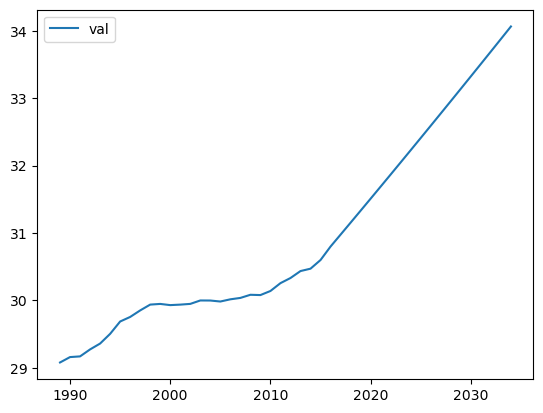

forecasting sisempikaupunki


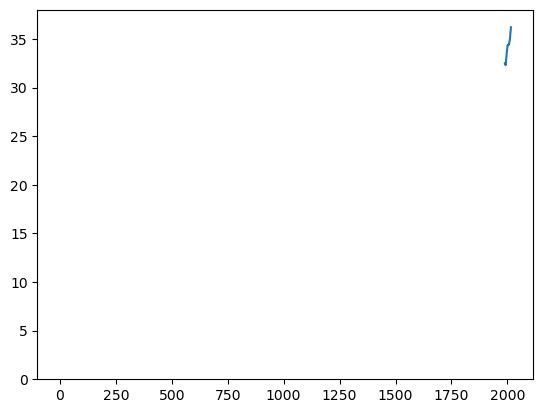

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:                        SARIMAX   Log Likelihood                 144.055
Date:                Sat, 02 Sep 2023   AIC                           -286.111
Time:                        12:48:08   BIC                           -284.853
Sample:                             0   HQIC                          -285.749
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.016e-07   2.49e-07      3.621      0.000    4.14e-07    1.39e-06
Ljung-Box (L1) (Q):                   1.31   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.25   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

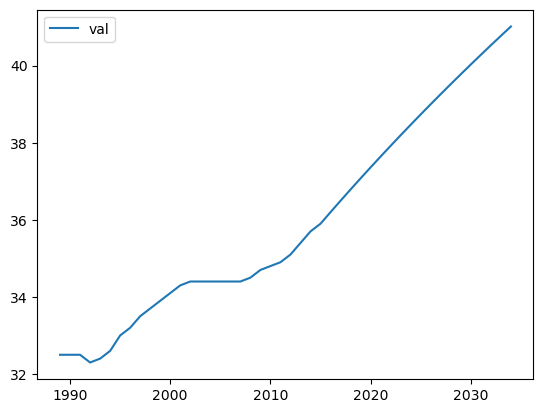

forecasting ulompikaupunki


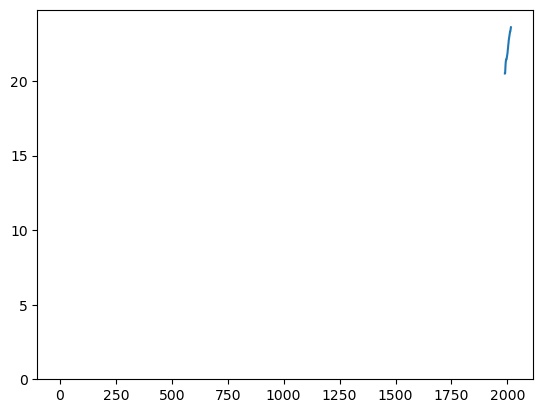

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 0, 3)   Log Likelihood                 168.481
Date:                Sat, 02 Sep 2023   AIC                           -328.963
Time:                        12:48:09   BIC                           -323.930
Sample:                             0   HQIC                          -327.514
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8247      0.548     -1.504      0.133      -1.899       0.250
ma.L2          0.2819      0.178      1.586      0.113      -0.067       0.630
ma.L3         -0.3549      0.322     -1.104      0.2

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.000070
27   -0.000083
28    0.000017
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

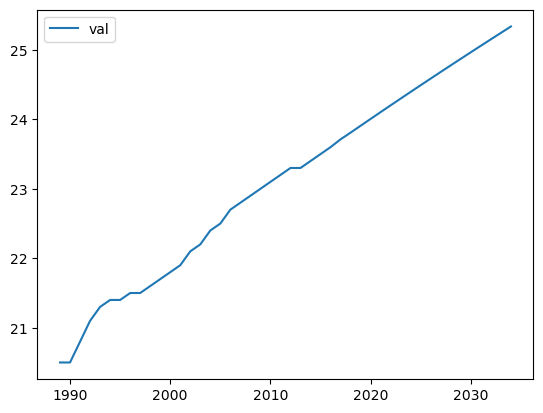

forecasting kehyskaupunki


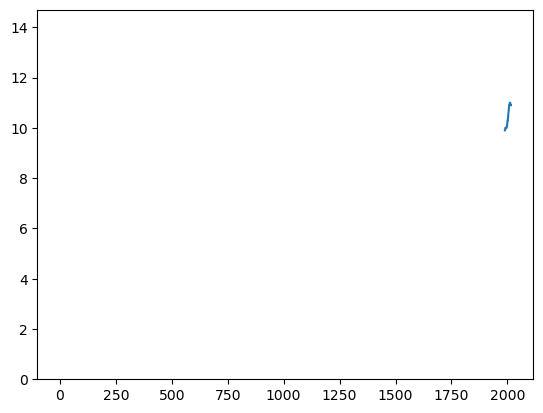

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 197.986
Date:                Sat, 02 Sep 2023   AIC                           -391.971
Time:                        12:48:10   BIC                           -389.455
Sample:                             0   HQIC                          -391.247
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6892   9.89e-18  -6.97e+16      0.000      -0.689      -0.689
sigma2      1.351e-08   4.15e-09      3.259      0.001    5.38e-09    2.16e-08
Ljung-Box (L1) (Q):                   0.05   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26   -0.000015
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

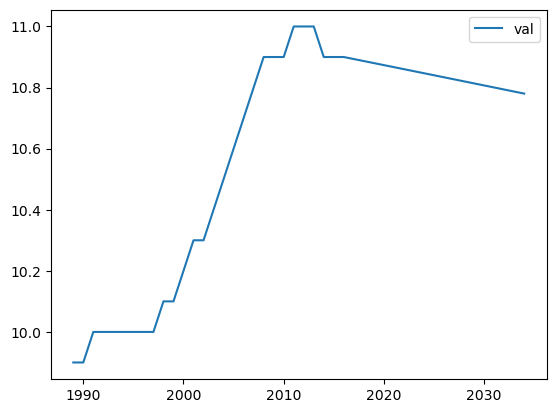

forecasting maaseudulla


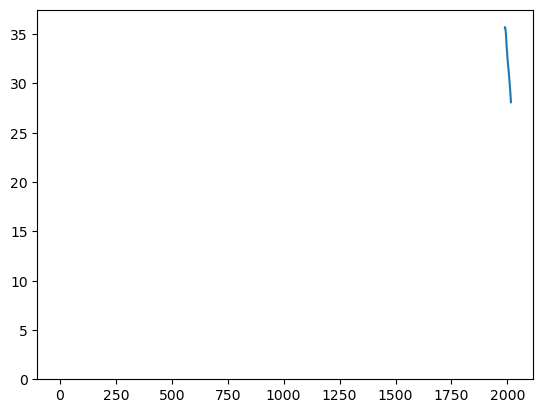

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:                        SARIMAX   Log Likelihood                 151.041
Date:                Sat, 02 Sep 2023   AIC                           -300.081
Time:                        12:48:11   BIC                           -298.823
Sample:                             0   HQIC                          -299.719
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.268e-07   1.52e-07      3.474      0.001     2.3e-07    8.24e-07
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.34   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

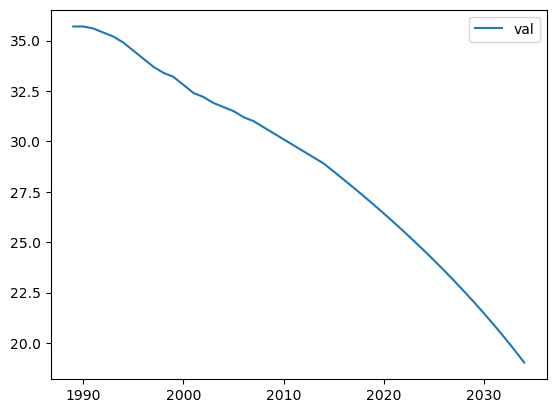

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

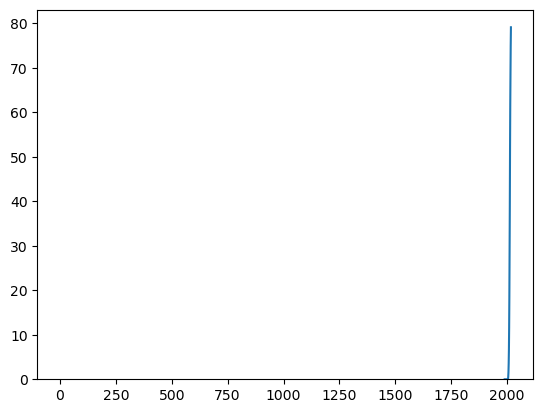

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(2, 1, 3)   Log Likelihood                  64.903
Date:                Sat, 02 Sep 2023   AIC                           -115.806
Time:                        12:48:13   BIC                           -106.999
Sample:                             0   HQIC                          -113.270
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.037      0.110      0.912      -0.069       0.077
ar.L1         -1.1930      1.066     -1.119      0.263      -3.282       0.896
ar.L2         -0.8496      0.317     -2.677      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.026131
28    0.105655
29   -0.031142
30    0.068580
31    0.069904
32   -0.012319
33    0.088730
34    0.042107
35    0.015960
36    0.090842
37    0.027796
38    0.043473
39    0.082410
40    0.026715
41    0.064160
42    0.070881
43    0.035128
dtype: float64

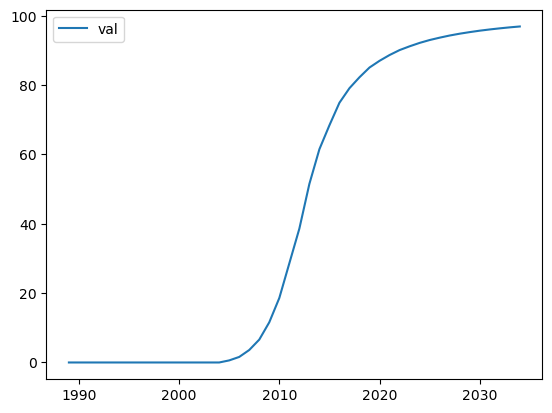

forecasting some_25_34


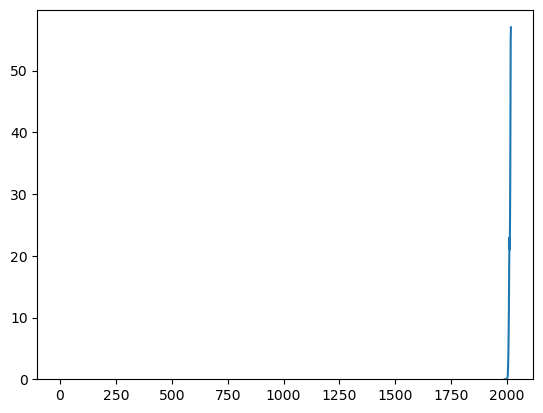

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(2, 0, 2)   Log Likelihood                  56.614
Date:                Sat, 02 Sep 2023   AIC                           -103.229
Time:                        12:48:15   BIC                            -96.749
Sample:                             0   HQIC                          -101.302
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0903      1.495      0.060      0.952      -2.840       3.020
ar.L2         -0.1610      1.682     -0.096      0.924      -3.458       3.136
ma.L1          0.1687      3.113      0.054      0.9

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27   -7.617053e-02
28    6.723747e-02
29    1.833389e-02
30   -9.166319e-03
31   -3.778994e-03
32    1.134036e-03
33    7.106990e-04
34   -1.183347e-04
35   -1.250822e-04
36    7.748185e-06
37    2.083293e-05
38    6.347186e-07
39   -3.295899e-06
40   -3.998843e-07
41    4.943807e-07
42    1.090225e-07
43   -6.972663e-08
dtype: float64

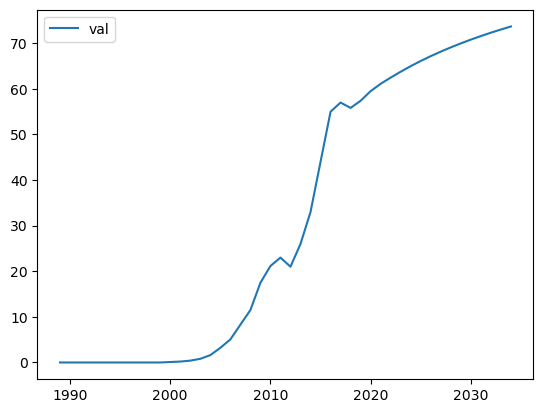

forecasting some_35_44


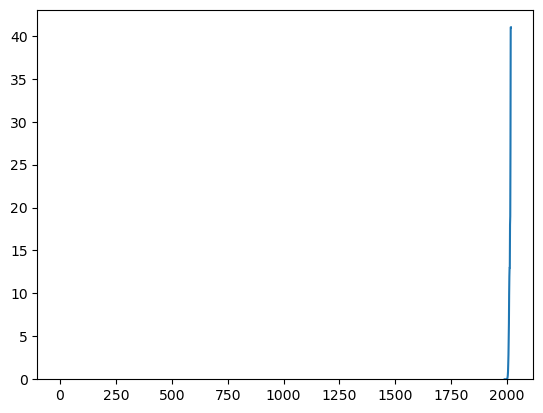

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(2, 0, 2)   Log Likelihood                  66.309
Date:                Sat, 02 Sep 2023   AIC                           -122.618
Time:                        12:48:16   BIC                           -116.139
Sample:                             0   HQIC                          -120.691
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3398      1.701     -0.200      0.842      -3.675       2.995
ar.L2         -0.7342      0.522     -1.406      0.160      -1.758       0.289
ma.L1          0.1929      1.997      0.097      0.9

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27   -0.072458
28    0.140846
29    0.005335
30   -0.105224
31    0.031843
32    0.066436
33   -0.045957
34   -0.033160
35    0.045012
36    0.009050
37   -0.036124
38    0.005632
39    0.024609
40   -0.012498
41   -0.013821
42    0.013873
43    0.005433
dtype: float64

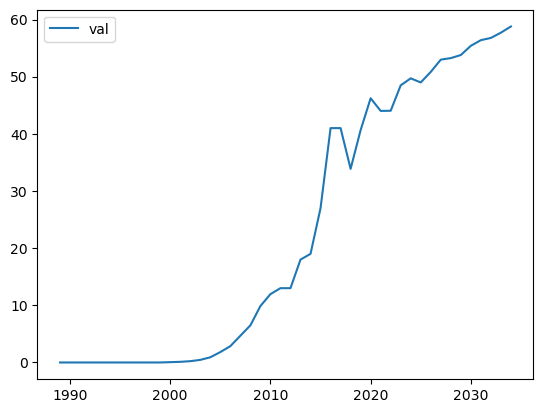

forecasting avioituvuus_25_29


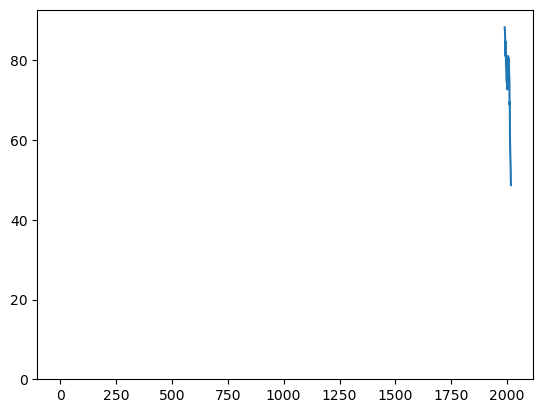

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   6.181
Date:                Sat, 02 Sep 2023   AIC                             -6.361
Time:                        12:48:17   BIC                             -2.474
Sample:                             0   HQIC                            -5.205
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2149      0.218     -5.572      0.000      -1.642      -0.788
ma.L2          0.5850      0.196      2.987      0.003       0.201       0.969
sigma2         0.0347      0.013      2.683      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.026320
28    0.046944
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

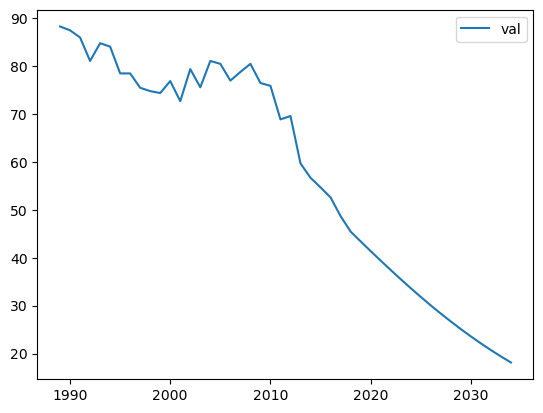

forecasting avioituvuus_30_34


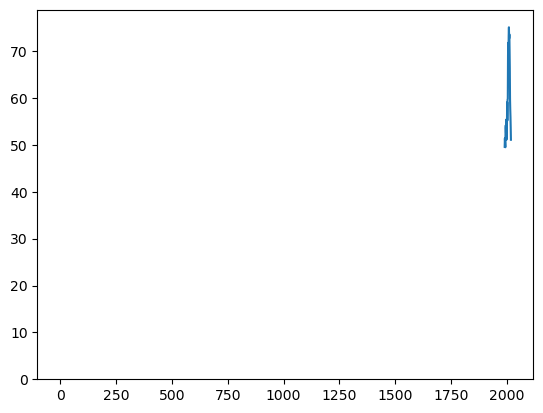

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:                        SARIMAX   Log Likelihood                  12.998
Date:                Sat, 02 Sep 2023   AIC                            -23.996
Time:                        12:48:18   BIC                            -22.664
Sample:                             0   HQIC                           -23.589
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0231      0.006      3.821      0.000       0.011       0.035
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.83   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

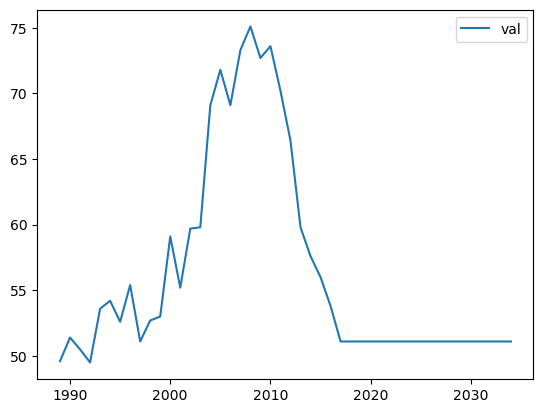

forecasting synnyttajien_keskiika


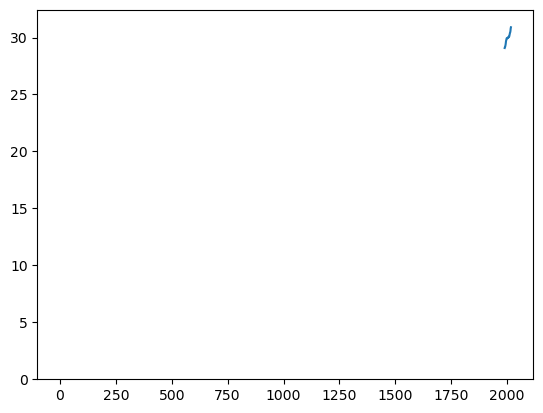

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 123.484
Date:                Sat, 02 Sep 2023   AIC                           -242.968
Time:                        12:48:19   BIC                           -240.376
Sample:                             0   HQIC                          -242.197
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3649      0.176     -2.076      0.038      -0.709      -0.020
sigma2       6.19e-06   2.47e-06      2.507      0.012    1.35e-06     1.1e-05
Ljung-Box (L1) (Q):                   0.28   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.001103
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

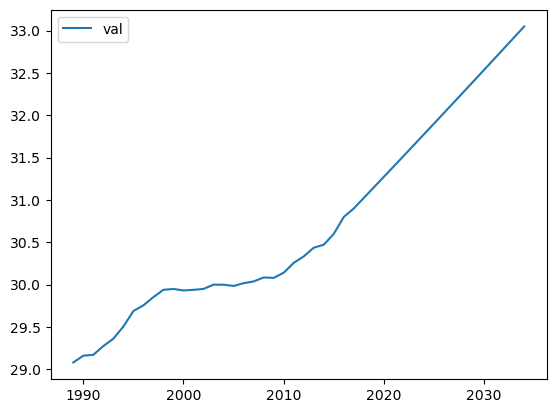

forecasting sisempikaupunki


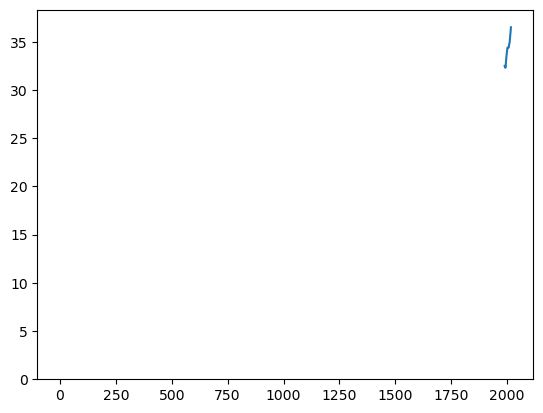

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:                        SARIMAX   Log Likelihood                 150.105
Date:                Sat, 02 Sep 2023   AIC                           -298.209
Time:                        12:48:20   BIC                           -296.914
Sample:                             0   HQIC                          -297.824
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.683e-07   2.29e-07      3.795      0.000     4.2e-07    1.32e-06
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.24   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

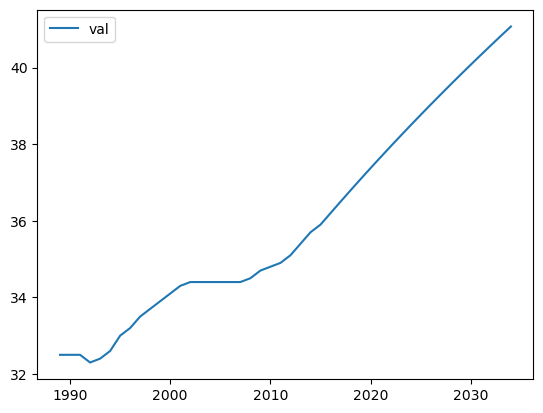

forecasting ulompikaupunki


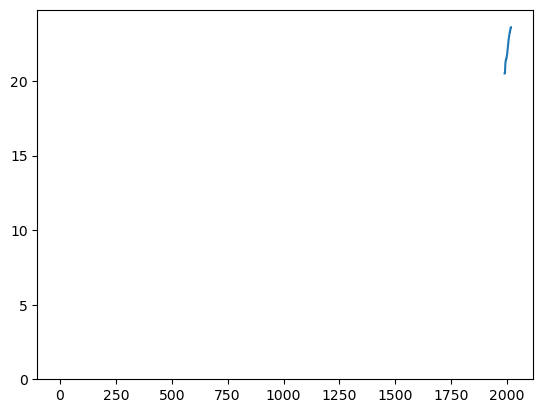

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 172.425
Date:                Sat, 02 Sep 2023   AIC                           -340.849
Time:                        12:48:21   BIC                           -338.258
Sample:                             0   HQIC                          -340.079
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4306      0.208     -2.065      0.039      -0.839      -0.022
sigma2       1.61e-07   3.62e-08      4.446      0.000       9e-08    2.32e-07
Ljung-Box (L1) (Q):                   0.02   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.000216
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

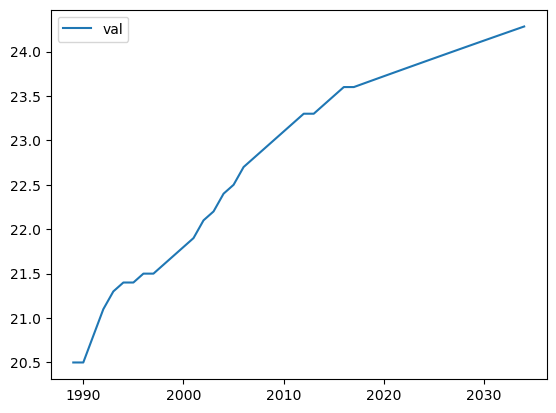

forecasting kehyskaupunki


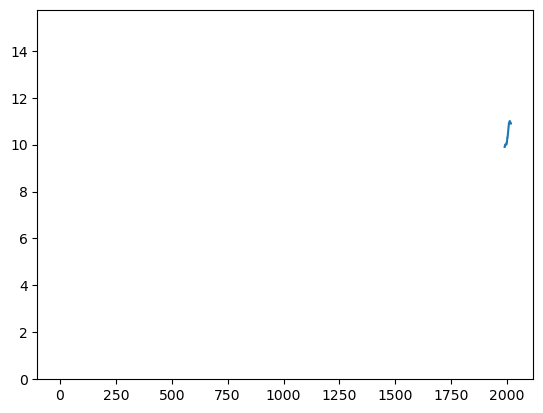

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 206.118
Date:                Sat, 02 Sep 2023   AIC                           -408.236
Time:                        12:48:22   BIC                           -405.644
Sample:                             0   HQIC                          -407.465
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6835   8.96e-18  -7.63e+16      0.000      -0.684      -0.684
sigma2        1.3e-08   3.81e-09      3.416      0.001    5.54e-09    2.05e-08
Ljung-Box (L1) (Q):                   0.05   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27   -0.00001
28    0.00000
29    0.00000
30    0.00000
31    0.00000
32    0.00000
33    0.00000
34    0.00000
35    0.00000
36    0.00000
37    0.00000
38    0.00000
39    0.00000
40    0.00000
41    0.00000
42    0.00000
43    0.00000
dtype: float64

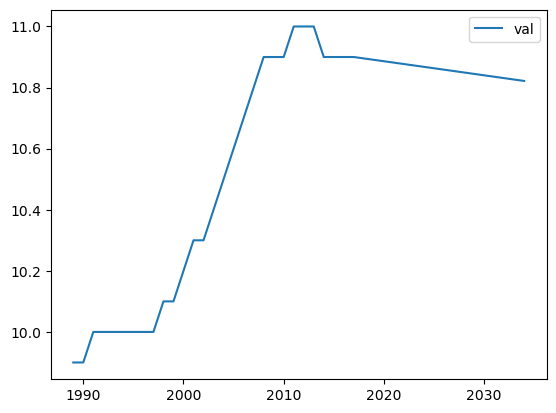

forecasting maaseudulla


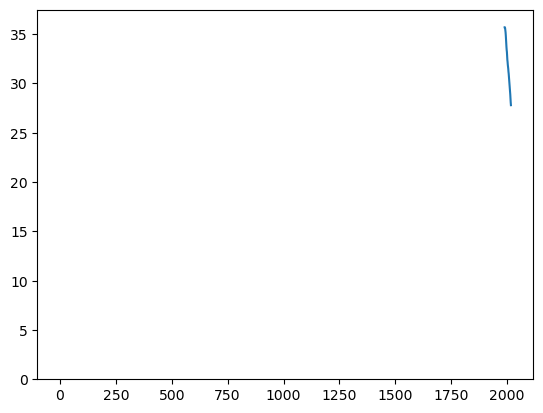

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:                        SARIMAX   Log Likelihood                 156.882
Date:                Sat, 02 Sep 2023   AIC                           -311.764
Time:                        12:48:23   BIC                           -310.468
Sample:                             0   HQIC                          -311.379
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.256e-07   1.51e-07      3.483      0.000     2.3e-07    8.21e-07
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.37   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

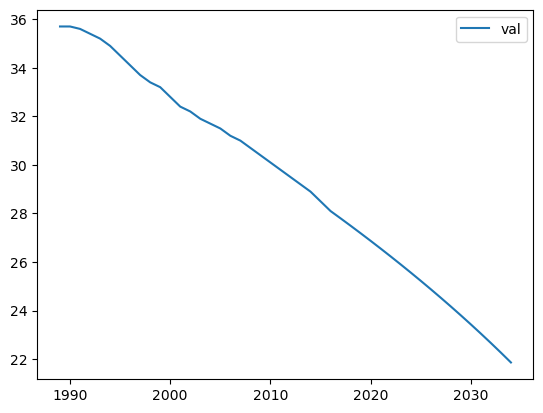

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

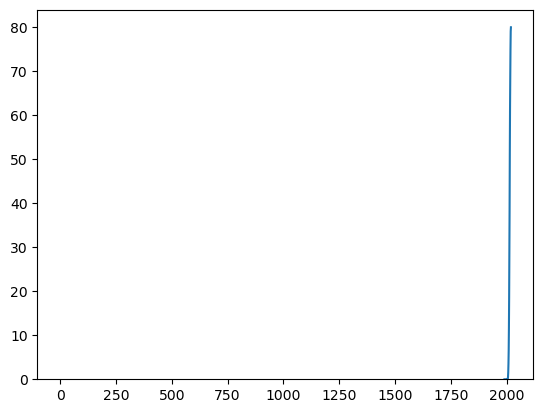

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(1, 0, 3)   Log Likelihood                  48.831
Date:                Sat, 02 Sep 2023   AIC                            -87.661
Time:                        12:48:25   BIC                            -81.000
Sample:                             0   HQIC                           -85.625
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5096      1.233      0.413      0.679      -1.907       2.926
ma.L1          0.7353      2.537      0.290      0.772      -4.237       5.708
ma.L2         -0.8591      3.711     -0.232      0.8

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28   -0.209935
29    0.011694
30    0.066774
31    0.034026
32    0.017339
33    0.008835
34    0.004502
35    0.002294
36    0.001169
37    0.000596
38    0.000304
39    0.000155
40    0.000079
41    0.000040
42    0.000020
43    0.000010
dtype: float64

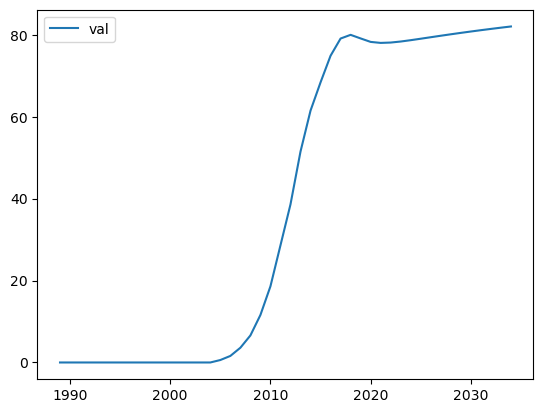

forecasting some_25_34


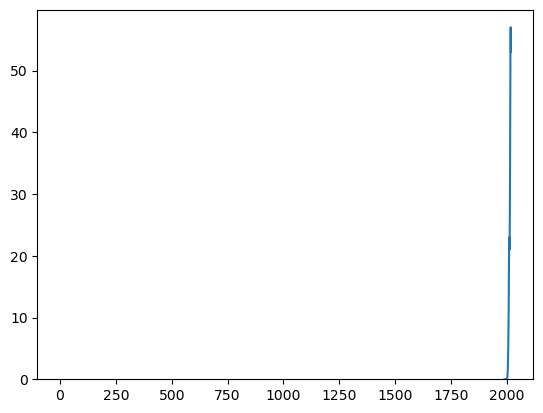

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(2, 0, 2)   Log Likelihood                  58.729
Date:                Sat, 02 Sep 2023   AIC                           -107.459
Time:                        12:48:26   BIC                           -100.797
Sample:                             0   HQIC                          -105.422
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4038      0.564      0.716      0.474      -0.702       1.510
ar.L2         -0.4205      0.872     -0.482      0.630      -2.131       1.290
ma.L1         -0.0293      0.476     -0.062      0.9

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    0.053991
29    0.087893
30    0.012785
31   -0.031798
32   -0.018216
33    0.006017
34    0.010090
35    0.001544
36   -0.003619
37   -0.002111
38    0.000670
39    0.001158
40    0.000186
41   -0.000412
42   -0.000245
43    0.000074
dtype: float64

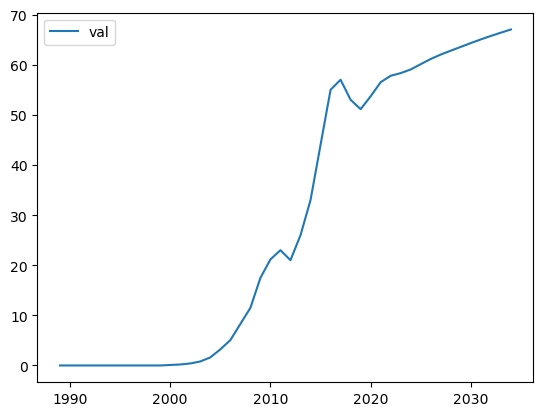

forecasting some_35_44


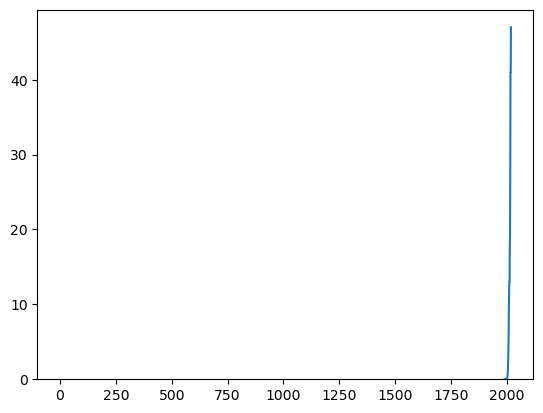

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  65.720
Date:                Sat, 02 Sep 2023   AIC                           -125.441
Time:                        12:48:27   BIC                           -121.444
Sample:                             0   HQIC                          -124.219
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9188      0.168     -5.459      0.000      -1.249      -0.589
ar.L2         -0.5584      0.303     -1.842      0.065      -1.153       0.036
sigma2         0.0005   8.12e-05      6.325      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28   -0.005919
29   -0.040055
30    0.040108
31   -0.014483
32   -0.009091
33    0.016441
34   -0.010029
35    0.000034
36    0.005570
37   -0.005136
38    0.001609
39    0.001390
40   -0.002176
41    0.001223
42    0.000091
43   -0.000767
dtype: float64

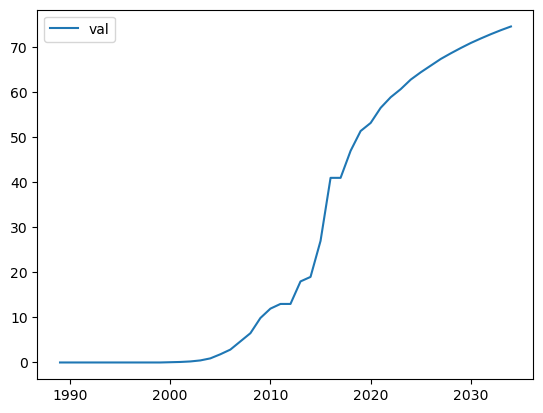

forecasting avioituvuus_25_29


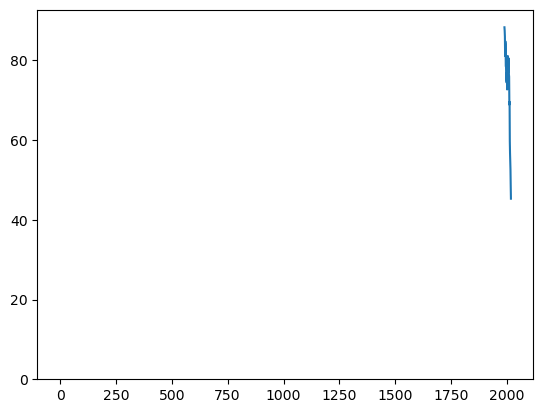

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   6.950
Date:                Sat, 02 Sep 2023   AIC                             -7.900
Time:                        12:48:28   BIC                             -3.904
Sample:                             0   HQIC                            -6.678
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2181      0.210     -5.798      0.000      -1.630      -0.806
ma.L2          0.5873      0.188      3.117      0.002       0.218       0.957
sigma2         0.0335      0.012      2.829      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    0.055077
29   -0.003475
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

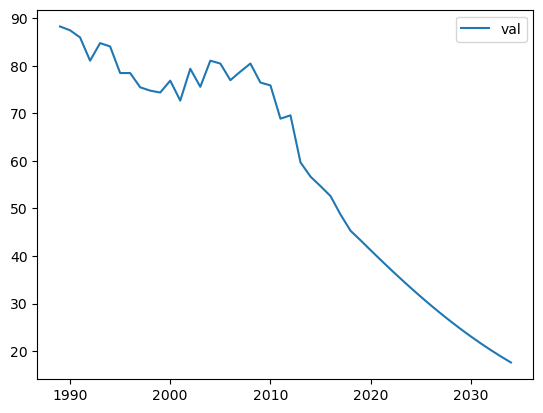

forecasting avioituvuus_30_34


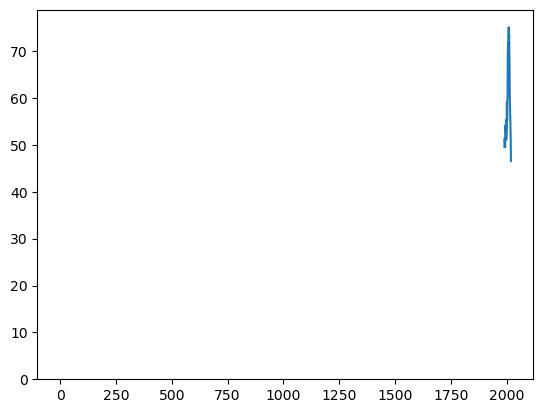

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:                        SARIMAX   Log Likelihood                  13.262
Date:                Sat, 02 Sep 2023   AIC                            -24.524
Time:                        12:48:29   BIC                            -23.156
Sample:                             0   HQIC                           -24.095
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0235      0.006      3.774      0.000       0.011       0.036
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.71   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

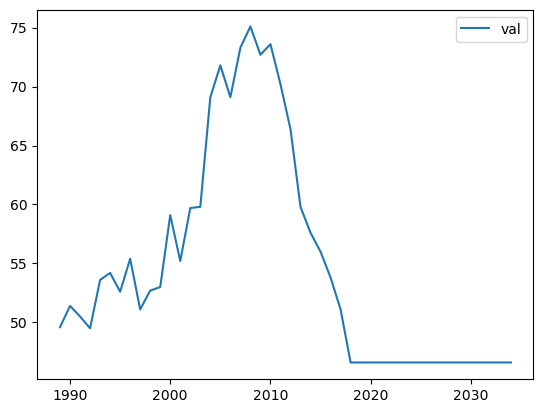

forecasting synnyttajien_keskiika


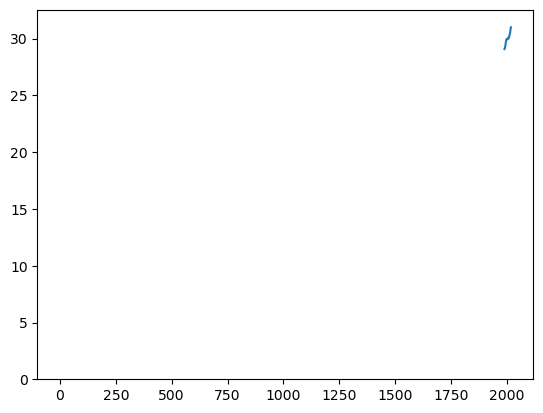

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 130.992
Date:                Sat, 02 Sep 2023   AIC                           -253.984
Time:                        12:48:30   BIC                           -248.655
Sample:                             0   HQIC                          -252.355
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5103      0.404     -1.264      0.206      -1.302       0.281
ma.L1          0.3204      0.650      0.493      0.622      -0.954       1.595
ma.L2         -0.6077      0.336     -1.808      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    5.415589e-04
29    2.448164e-05
30   -1.249258e-05
31    6.374761e-06
32   -3.252936e-06
33    1.659920e-06
34   -8.470303e-07
35    4.322257e-07
36   -2.205577e-07
37    1.125470e-07
38   -5.743091e-08
39    2.930606e-08
40   -1.495440e-08
41    7.630988e-09
42   -3.893969e-09
43    1.987029e-09
dtype: float64

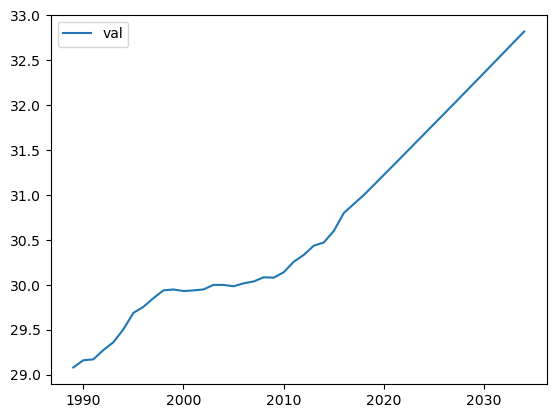

forecasting sisempikaupunki


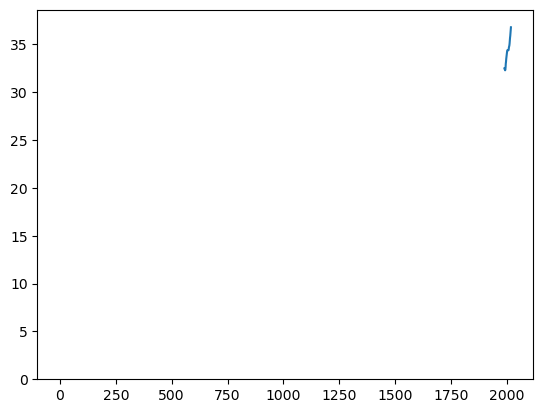

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:                        SARIMAX   Log Likelihood                 156.172
Date:                Sat, 02 Sep 2023   AIC                           -310.345
Time:                        12:48:31   BIC                           -309.013
Sample:                             0   HQIC                          -309.937
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.373e-07   2.11e-07      3.968      0.000    4.24e-07    1.25e-06
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.23   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

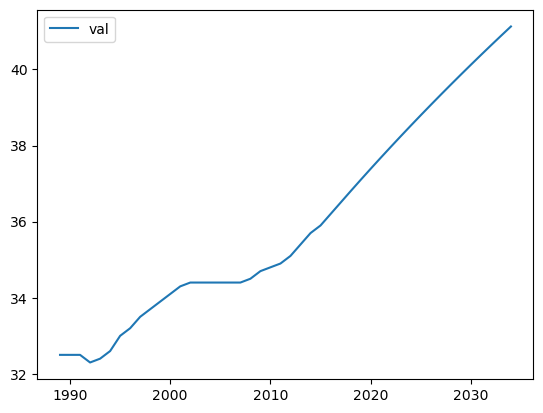

forecasting ulompikaupunki


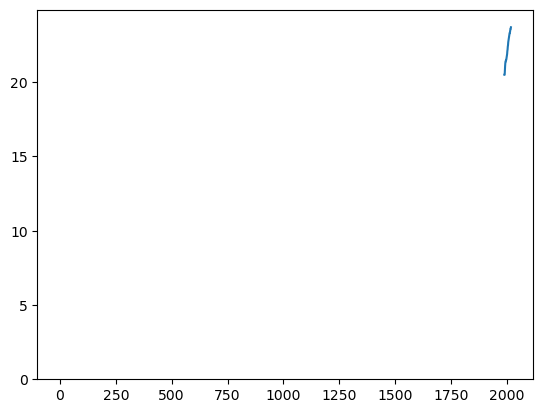

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 179.252
Date:                Sat, 02 Sep 2023   AIC                           -354.505
Time:                        12:48:32   BIC                           -351.841
Sample:                             0   HQIC                          -353.690
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4772      0.210     -2.270      0.023      -0.889      -0.065
sigma2      1.592e-07   3.61e-08      4.408      0.000    8.84e-08     2.3e-07
Ljung-Box (L1) (Q):                   0.02   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28   -0.00014
29    0.00000
30    0.00000
31    0.00000
32    0.00000
33    0.00000
34    0.00000
35    0.00000
36    0.00000
37    0.00000
38    0.00000
39    0.00000
40    0.00000
41    0.00000
42    0.00000
43    0.00000
dtype: float64

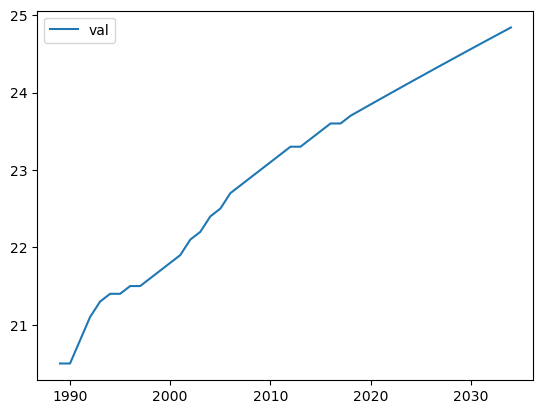

forecasting kehyskaupunki


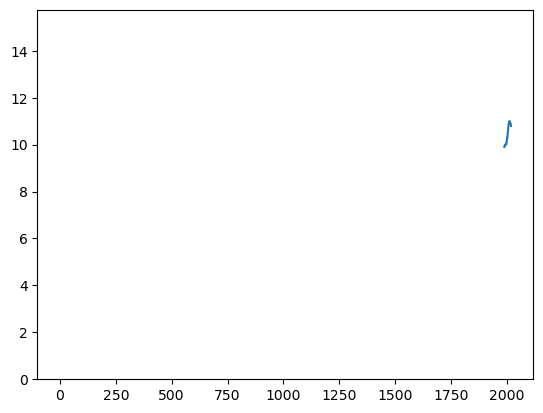

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 212.542
Date:                Sat, 02 Sep 2023   AIC                           -421.084
Time:                        12:48:33   BIC                           -418.420
Sample:                             0   HQIC                          -420.270
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7204   1.05e-17  -6.84e+16      0.000      -0.720      -0.720
sigma2      1.406e-08   4.18e-09      3.362      0.001    5.86e-09    2.22e-08
Ljung-Box (L1) (Q):                   0.01   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    0.000149
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

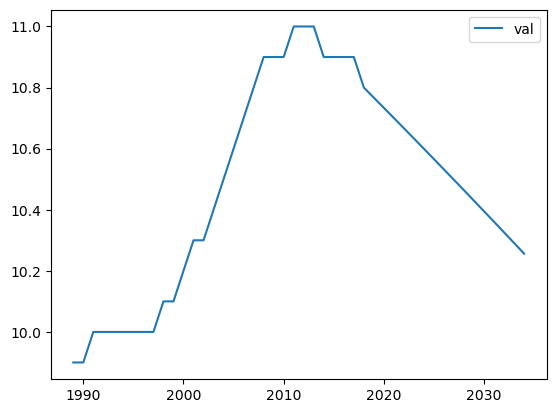

forecasting maaseudulla


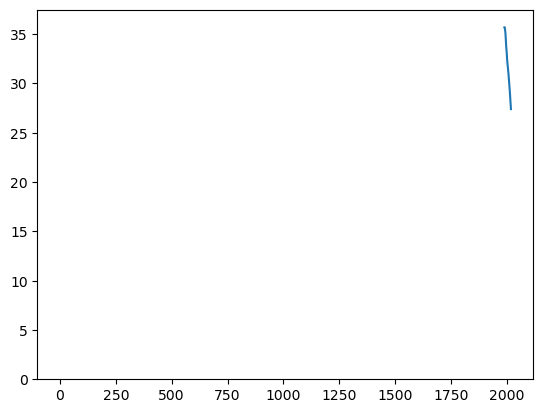

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   28
Model:                        SARIMAX   Log Likelihood                 162.835
Date:                Sat, 02 Sep 2023   AIC                           -323.669
Time:                        12:48:34   BIC                           -322.337
Sample:                             0   HQIC                          -323.262
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.203e-07   1.48e-07      3.521      0.000    2.31e-07     8.1e-07
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.29   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

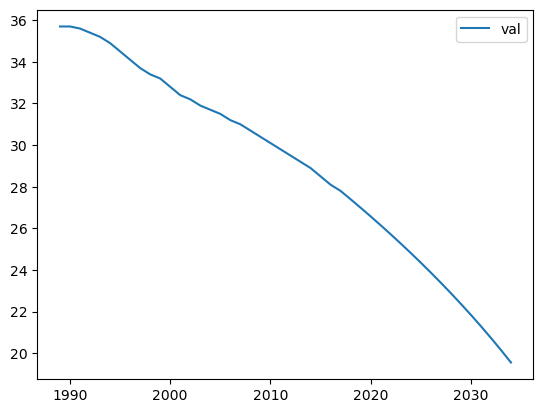

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

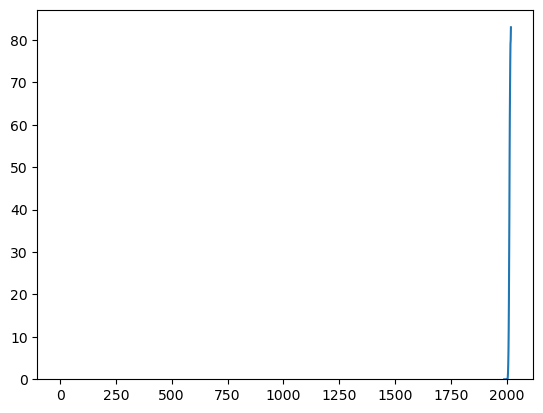

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(3, 0, 0)   Log Likelihood                  35.845
Date:                Sat, 02 Sep 2023   AIC                            -63.689
Time:                        12:48:36   BIC                            -58.220
Sample:                             0   HQIC                           -61.976
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4707      0.149     -3.153      0.002      -0.763      -0.178
ar.L2         -0.2341      0.245     -0.955      0.339      -0.714       0.246
ar.L3          0.5246      0.215      2.443      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29   -0.090917
30   -0.185290
31    0.281815
32   -0.136972
33   -0.098705
34    0.226370
35   -0.155305
36   -0.031672
37    0.170022
38   -0.154092
39    0.016115
40    0.117684
41   -0.140006
42    0.046806
43    0.072482
dtype: float64

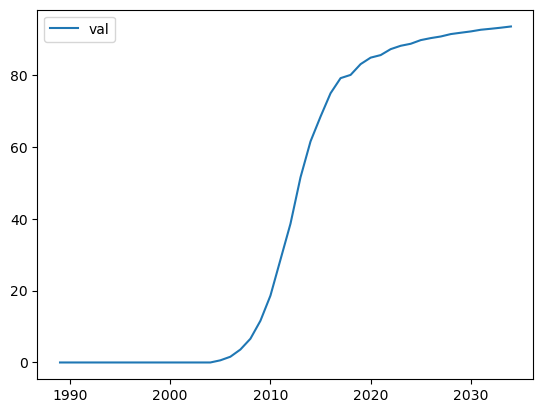

forecasting some_25_34


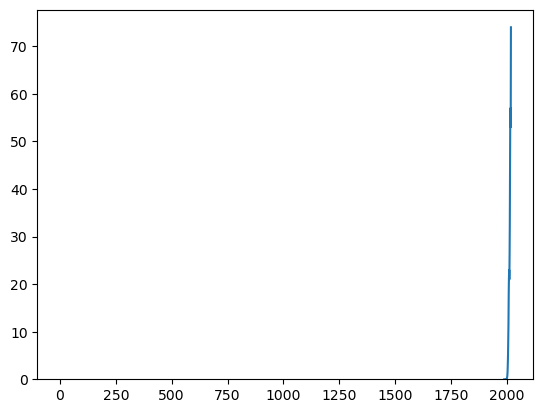

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 0, 4)   Log Likelihood                  21.471
Date:                Sat, 02 Sep 2023   AIC                            -32.943
Time:                        12:48:37   BIC                            -26.106
Sample:                             0   HQIC                           -30.802
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.8951      0.545     -3.474      0.001      -2.964      -0.826
ma.L2          1.7952      1.627      1.104      0.270      -1.393       4.983
ma.L3         -0.7808      2.435     -0.321      0.7

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29   -1.203812
30    0.869884
31   -0.324373
32    0.060336
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

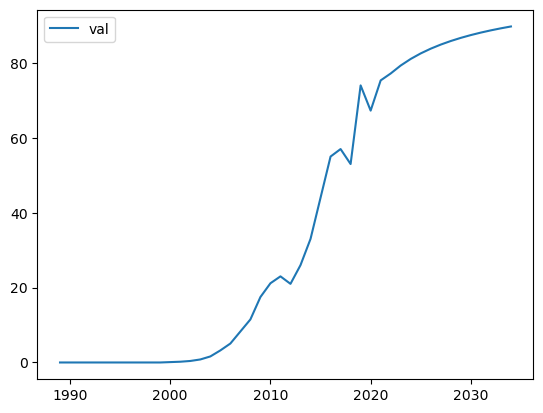

forecasting some_35_44


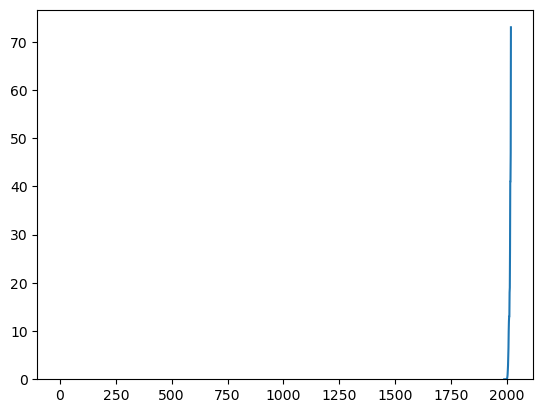

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 4)   Log Likelihood                  29.810
Date:                Sat, 02 Sep 2023   AIC                            -47.619
Time:                        12:48:39   BIC                            -39.416
Sample:                             0   HQIC                           -45.050
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5280      2.558      0.206      0.836      -4.486       5.542
ma.L1          1.6740      2.386      0.702      0.483      -3.003       6.351
ma.L2          0.0714      5.113      0.014      0.9

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29    0.757716
30    0.040985
31   -0.333816
32   -0.261511
33   -0.138068
34   -0.072895
35   -0.038486
36   -0.020319
37   -0.010728
38   -0.005664
39   -0.002990
40   -0.001579
41   -0.000834
42   -0.000440
43   -0.000232
dtype: float64

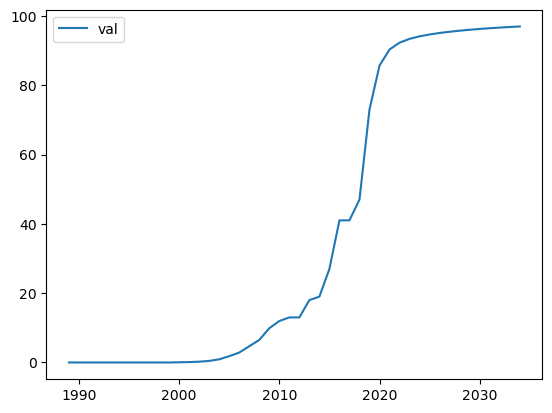

forecasting avioituvuus_25_29


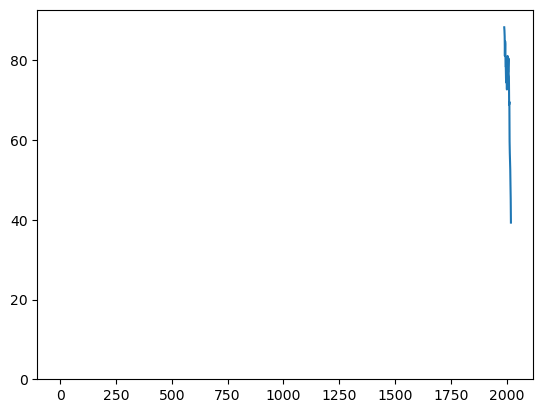

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   7.374
Date:                Sat, 02 Sep 2023   AIC                             -8.748
Time:                        12:48:40   BIC                             -4.646
Sample:                             0   HQIC                            -7.463
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2069      0.224     -5.387      0.000      -1.646      -0.768
ma.L2          0.5428      0.192      2.823      0.005       0.166       0.920
sigma2         0.0333      0.012      2.872      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29    0.178151
30   -0.078566
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

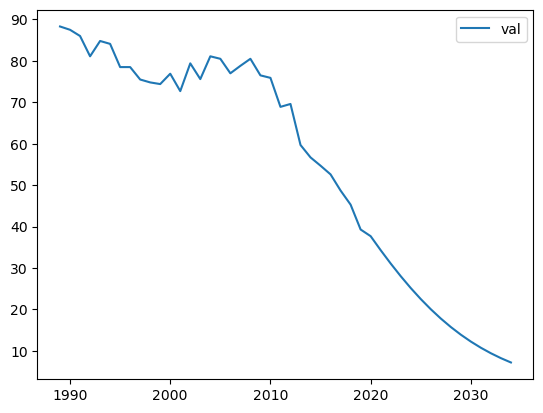

forecasting avioituvuus_30_34


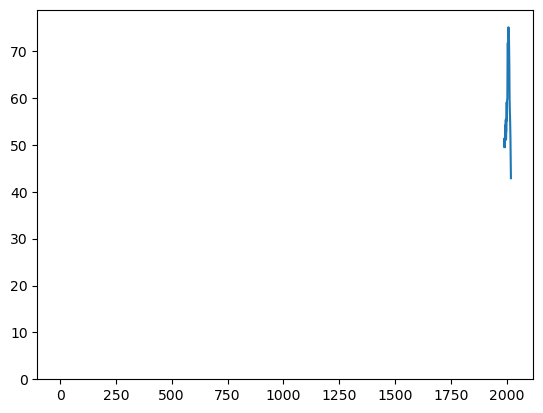

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  13.693
Date:                Sat, 02 Sep 2023   AIC                            -21.385
Time:                        12:48:41   BIC                            -17.284
Sample:                             0   HQIC                           -20.101
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0070      0.007     -1.067      0.286      -0.020       0.006
ma.L1         -0.9328      0.233     -4.009      0.000      -1.389      -0.477
sigma2         0.0212      0.006      3.483      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.125058
31   -0.132094
32   -0.139130
33   -0.146166
34   -0.153203
35   -0.160239
36   -0.167275
37   -0.174311
38   -0.181347
39   -0.188383
40   -0.195420
41   -0.202456
42   -0.209492
43   -0.216528
44   -0.223564
dtype: float64

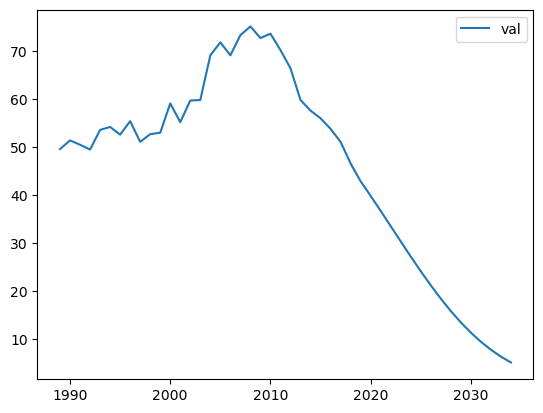

forecasting synnyttajien_keskiika


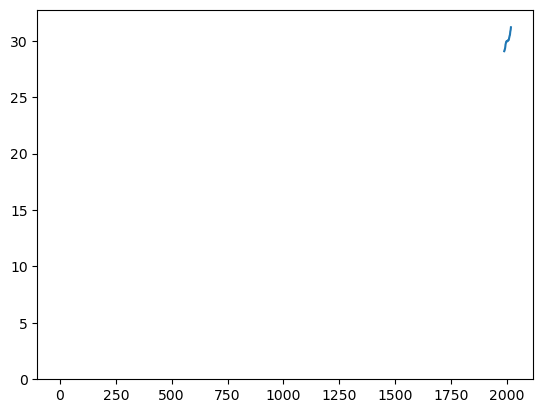

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(1, 0, 4)   Log Likelihood                 136.695
Date:                Sat, 02 Sep 2023   AIC                           -261.390
Time:                        12:48:42   BIC                           -253.187
Sample:                             0   HQIC                          -258.821
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5693      0.468      1.216      0.224      -0.348       1.487
ma.L1         -0.9602      1.268     -0.758      0.449      -3.445       1.524
ma.L2         -0.0597      1.068     -0.056      0.9

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29   -0.001790
30   -0.003449
31    0.001558
32   -0.000865
33   -0.000492
34   -0.000280
35   -0.000160
36   -0.000091
37   -0.000052
38   -0.000029
39   -0.000017
40   -0.000010
41   -0.000005
42   -0.000003
43   -0.000002
dtype: float64

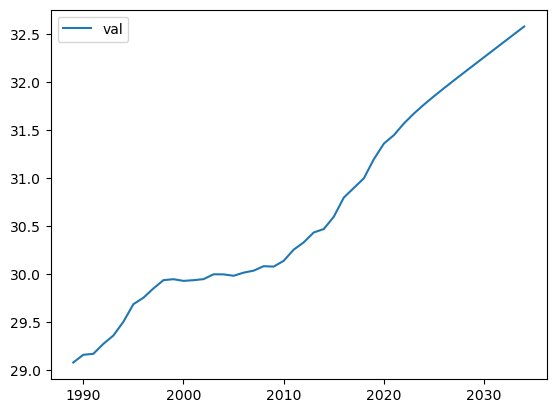

forecasting sisempikaupunki


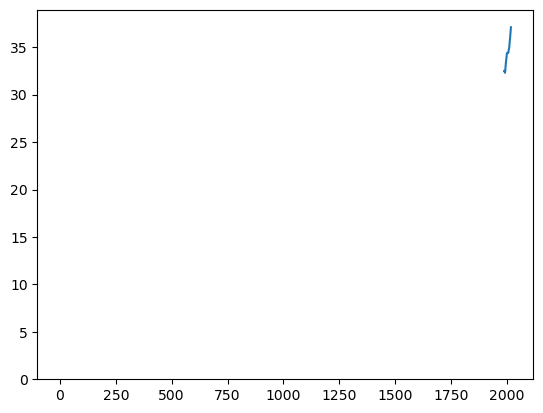

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:                        SARIMAX   Log Likelihood                 162.258
Date:                Sat, 02 Sep 2023   AIC                           -322.516
Time:                        12:48:43   BIC                           -321.148
Sample:                             0   HQIC                          -322.087
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.085e-07   1.95e-07      4.140      0.000    4.26e-07    1.19e-06
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.23   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

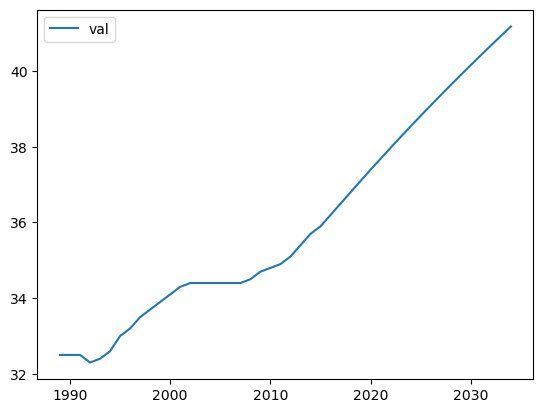

forecasting ulompikaupunki


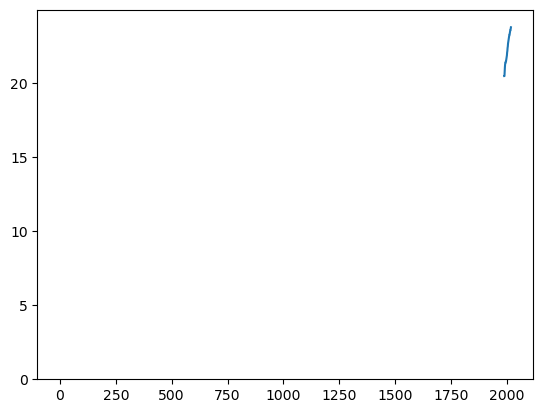

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 186.200
Date:                Sat, 02 Sep 2023   AIC                           -368.400
Time:                        12:48:44   BIC                           -365.665
Sample:                             0   HQIC                          -367.544
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4948      0.204     -2.425      0.015      -0.895      -0.095
sigma2      1.537e-07   3.38e-08      4.549      0.000    8.75e-08     2.2e-07
Ljung-Box (L1) (Q):                   0.07   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29   -0.000071
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

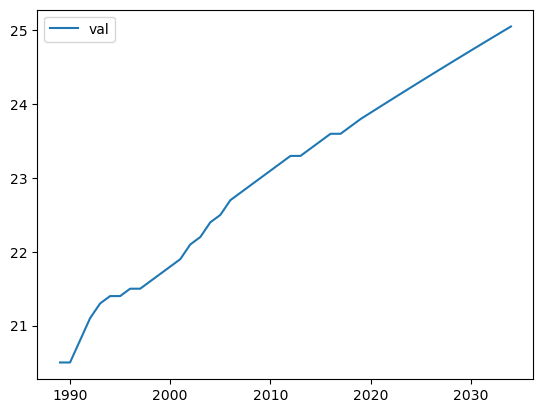

forecasting kehyskaupunki


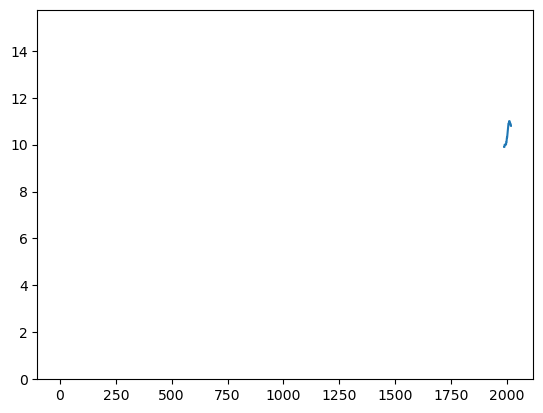

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 220.252
Date:                Sat, 02 Sep 2023   AIC                           -436.504
Time:                        12:48:45   BIC                           -433.770
Sample:                             0   HQIC                          -435.648
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7567   2.01e-17  -3.77e+16      0.000      -0.757      -0.757
sigma2      1.391e-08   3.91e-09      3.560      0.000    6.25e-09    2.16e-08
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29   -0.000044
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

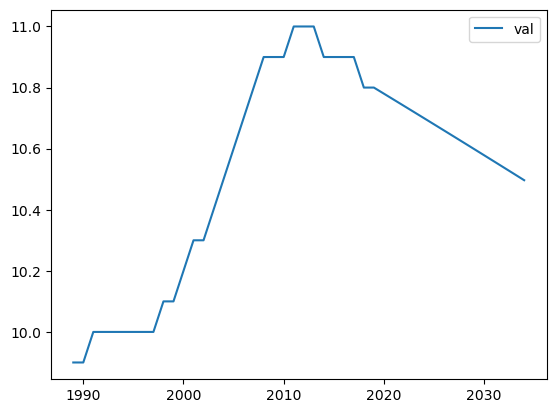

forecasting maaseudulla


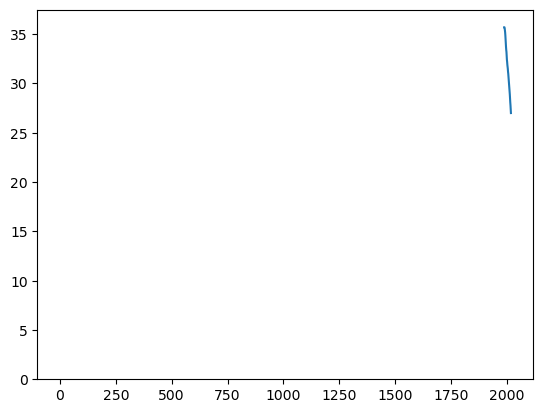

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   29
Model:                        SARIMAX   Log Likelihood                 169.156
Date:                Sat, 02 Sep 2023   AIC                           -336.313
Time:                        12:48:46   BIC                           -334.946
Sample:                             0   HQIC                          -335.885
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.024e-07   1.36e-07      3.681      0.000    2.35e-07     7.7e-07
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.27   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

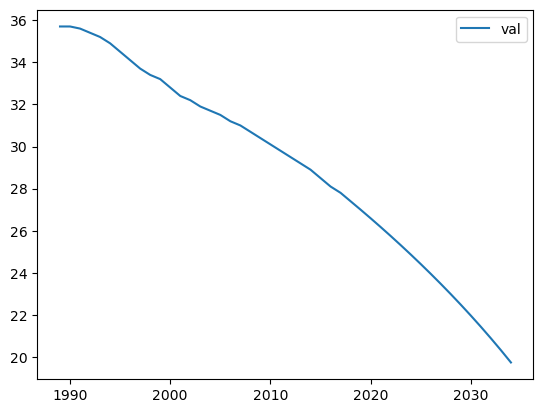

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

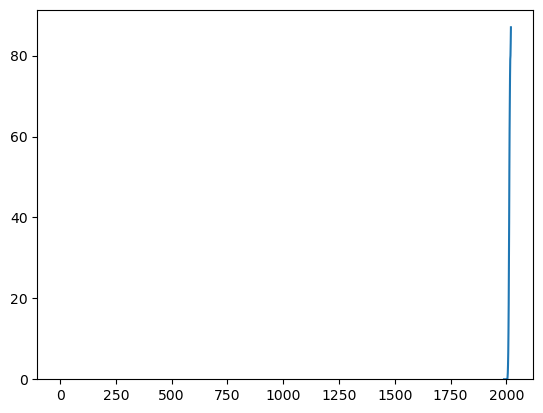

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(5, 0, 0)   Log Likelihood                  34.789
Date:                Sat, 02 Sep 2023   AIC                            -57.579
Time:                        12:48:48   BIC                            -49.171
Sample:                             0   HQIC                           -54.889
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2197      0.166      1.325      0.185      -0.105       0.545
ar.L2         -1.2307      0.196     -6.284      0.000      -1.615      -0.847
ar.L3          1.0320      0.378      2.729      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.510157
31   -0.265796
32    0.754698
33    0.073044
34   -0.722867
35    0.243522
36    0.626189
37   -0.397040
38   -0.358514
39    0.481281
40    0.138177
41   -0.383384
42    0.060610
43    0.244584
dtype: float64

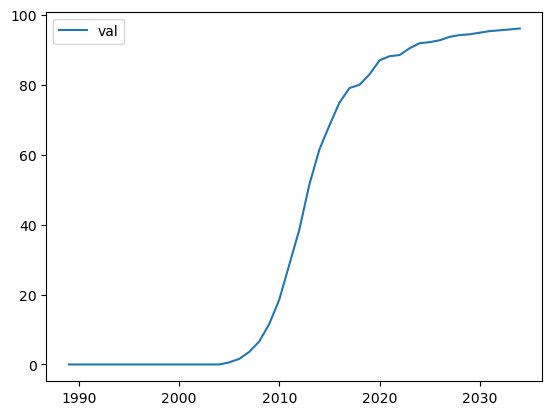

forecasting some_25_34


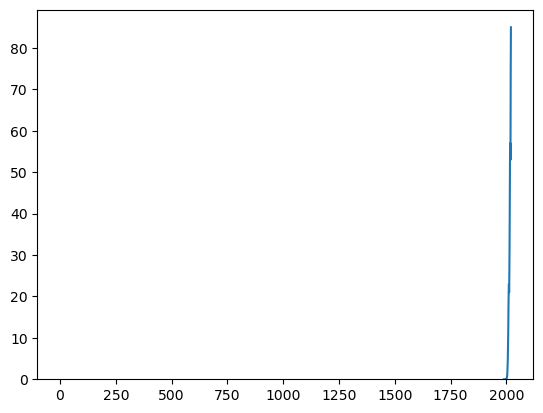

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(2, 0, 1)   Log Likelihood                  13.096
Date:                Sat, 02 Sep 2023   AIC                            -18.192
Time:                        12:48:49   BIC                            -12.587
Sample:                             0   HQIC                           -16.399
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0968      1.356     -0.071      0.943      -2.754       2.560
ar.L2         -0.8425      0.291     -2.900      0.004      -1.412      -0.273
ma.L1          0.6422      1.446      0.444      0.6

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.798098
31   -0.405756
32    0.711673
33    0.272920
34   -0.625999
35   -0.169305
36    0.543786
37    0.089974
38   -0.466840
39   -0.030591
40    0.396265
41   -0.012603
42   -0.332623
43    0.042830
dtype: float64

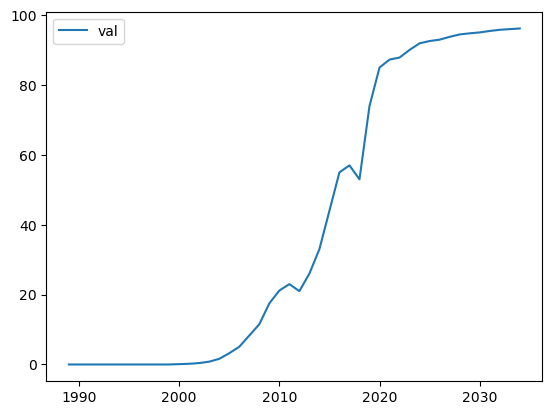

forecasting some_35_44


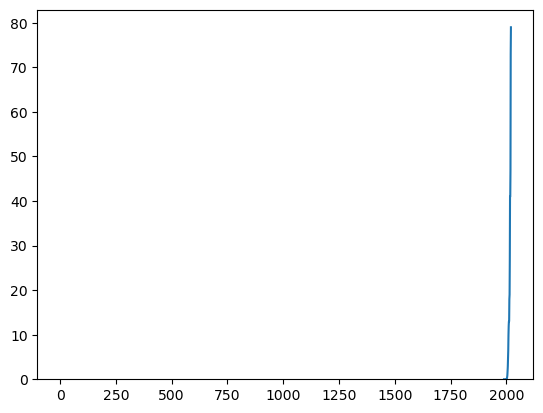

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  17.227
Date:                Sat, 02 Sep 2023   AIC                            -28.454
Time:                        12:48:50   BIC                            -24.250
Sample:                             0   HQIC                           -27.109
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2819      0.401     -0.703      0.482      -1.068       0.504
ar.L2         -0.8159      0.297     -2.743      0.006      -1.399      -0.233
sigma2         0.0172      0.003      5.947      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.537794
31    0.427336
32    0.318332
33   -0.438420
34   -0.136141
35    0.396102
36   -0.000585
37   -0.323028
38    0.091544
39    0.237762
40   -0.141722
41   -0.154044
42    0.159063
43    0.080848
dtype: float64

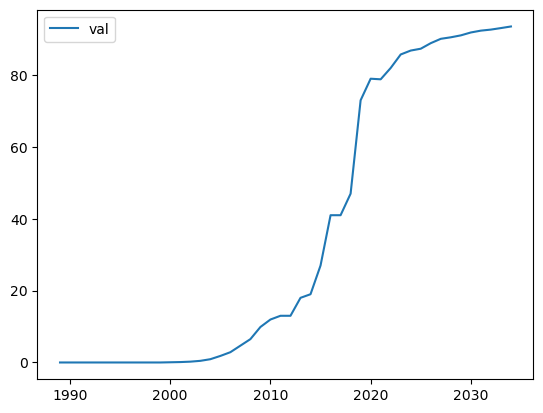

forecasting avioituvuus_25_29


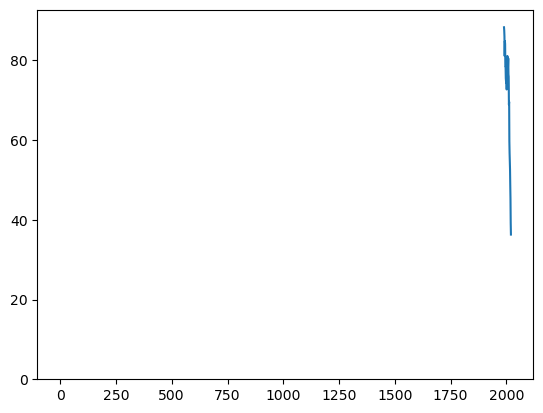

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   8.116
Date:                Sat, 02 Sep 2023   AIC                            -10.233
Time:                        12:48:51   BIC                             -6.029
Sample:                             0   HQIC                            -8.888
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1957      0.221     -5.411      0.000      -1.629      -0.763
ma.L2          0.5228      0.190      2.750      0.006       0.150       0.895
sigma2         0.0323      0.011      2.990      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.010477
31   -0.027252
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

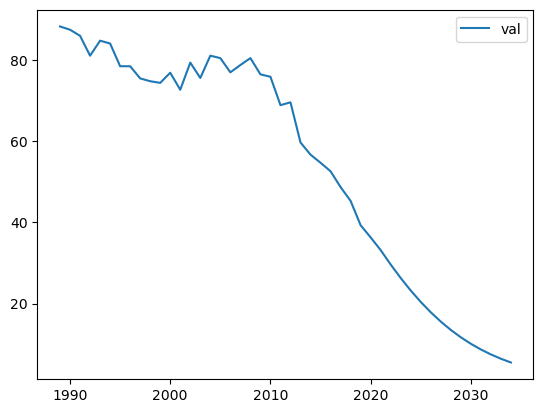

forecasting avioituvuus_30_34


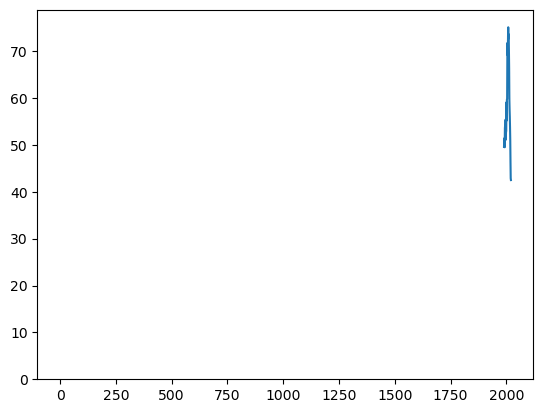

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  15.142
Date:                Sat, 02 Sep 2023   AIC                            -22.284
Time:                        12:48:52   BIC                            -16.679
Sample:                             0   HQIC                           -20.491
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0044      0.010     -0.456      0.649      -0.023       0.015
ma.L1         -0.9606      0.247     -3.894      0.000      -1.444      -0.477
ma.L2          0.3169      0.246      1.290      0.1

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.149288
32   -0.115302
33   -0.119721
34   -0.124140
35   -0.128558
36   -0.132977
37   -0.137396
38   -0.141814
39   -0.146233
40   -0.150651
41   -0.155070
42   -0.159489
43   -0.163907
44   -0.168326
dtype: float64

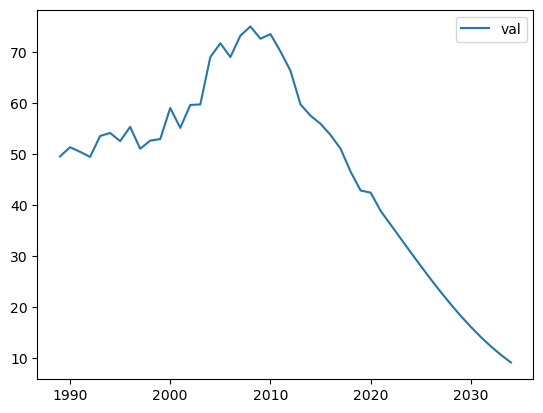

forecasting synnyttajien_keskiika


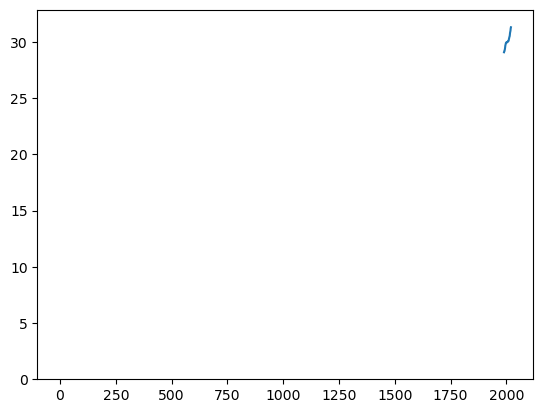

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 137.915
Date:                Sat, 02 Sep 2023   AIC                           -269.831
Time:                        12:48:53   BIC                           -265.627
Sample:                             0   HQIC                          -268.486
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4652      0.191     -2.431      0.015      -0.840      -0.090
ar.L2         -0.4101      0.183     -2.235      0.025      -0.770      -0.051
sigma2      5.852e-06   2.48e-06      2.360      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30    0.000268
31    0.001794
32   -0.000945
33   -0.000296
34    0.000525
35   -0.000123
36   -0.000158
37    0.000124
38    0.000007
39   -0.000054
40    0.000022
41    0.000012
42   -0.000015
43    0.000002
dtype: float64

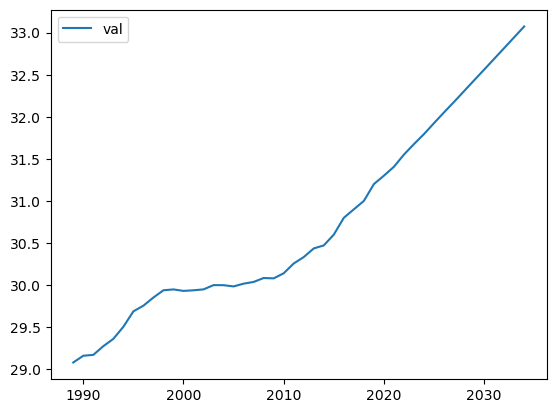

forecasting sisempikaupunki


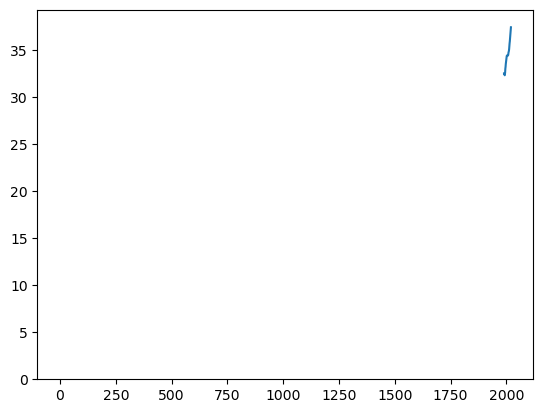

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:                        SARIMAX   Log Likelihood                 168.360
Date:                Sat, 02 Sep 2023   AIC                           -334.721
Time:                        12:48:54   BIC                           -333.320
Sample:                             0   HQIC                          -334.273
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.816e-07   1.81e-07      4.313      0.000    4.26e-07    1.14e-06
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.22   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

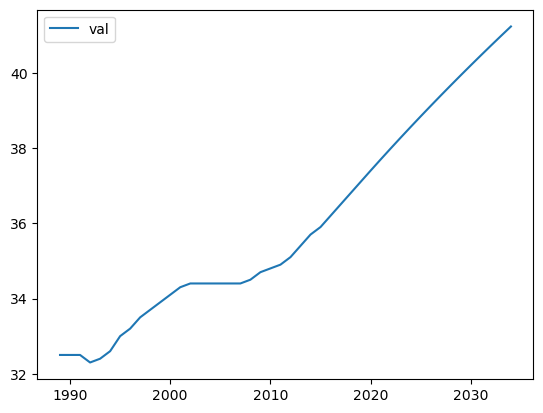

forecasting ulompikaupunki


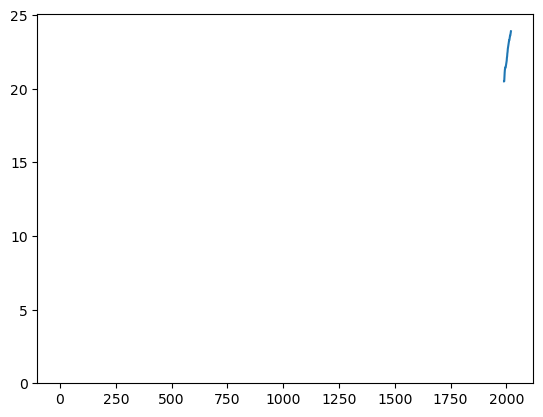

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 193.026
Date:                Sat, 02 Sep 2023   AIC                           -382.052
Time:                        12:48:55   BIC                           -379.250
Sample:                             0   HQIC                          -381.156
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4803      0.193     -2.484      0.013      -0.859      -0.101
sigma2      1.458e-07   3.02e-08      4.821      0.000    8.65e-08    2.05e-07
Ljung-Box (L1) (Q):                   0.05   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.000034
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

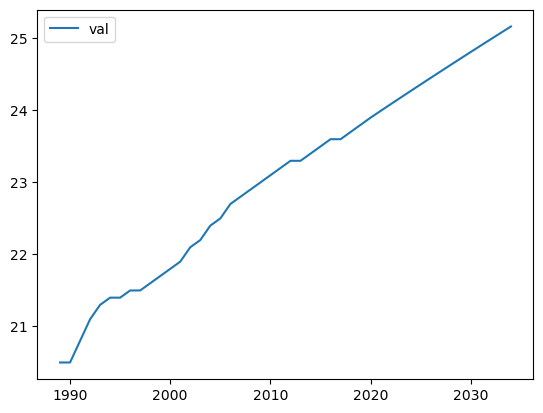

forecasting kehyskaupunki


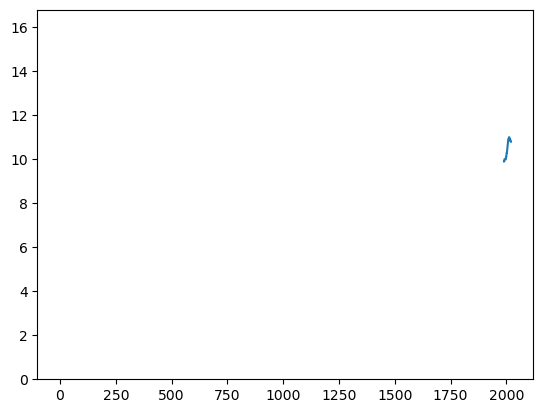

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 228.435
Date:                Sat, 02 Sep 2023   AIC                           -452.869
Time:                        12:48:56   BIC                           -450.067
Sample:                             0   HQIC                          -451.973
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7449   7.87e-18  -9.46e+16      0.000      -0.745      -0.745
sigma2       1.32e-08   3.63e-09      3.631      0.000    6.07e-09    2.03e-08
Ljung-Box (L1) (Q):                   0.02   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30   -0.000034
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

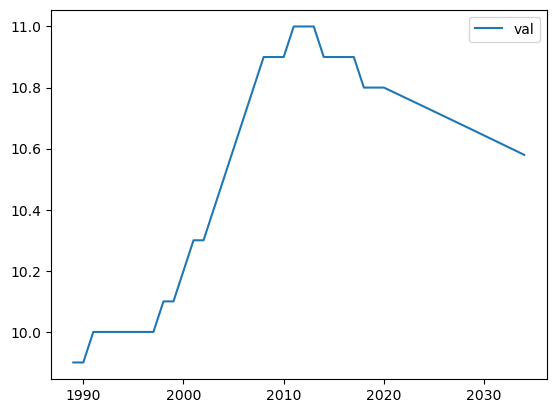

forecasting maaseudulla


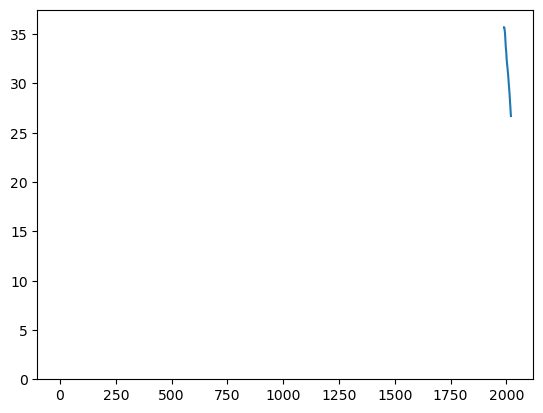

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:                        SARIMAX   Log Likelihood                 175.047
Date:                Sat, 02 Sep 2023   AIC                           -348.095
Time:                        12:48:58   BIC                           -346.694
Sample:                             0   HQIC                          -347.647
                                 - 30                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.005e-07   1.35e-07      3.696      0.000    2.35e-07    7.66e-07
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.30   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

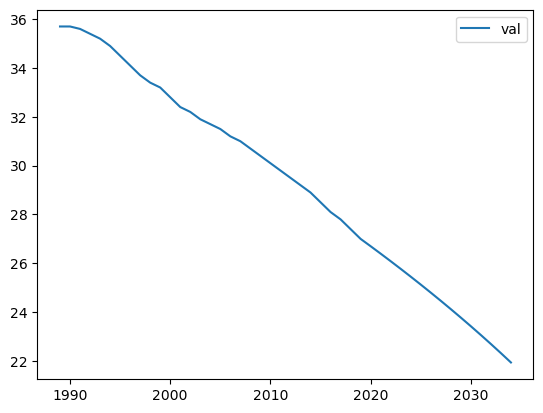

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

forecasting alypuhelin


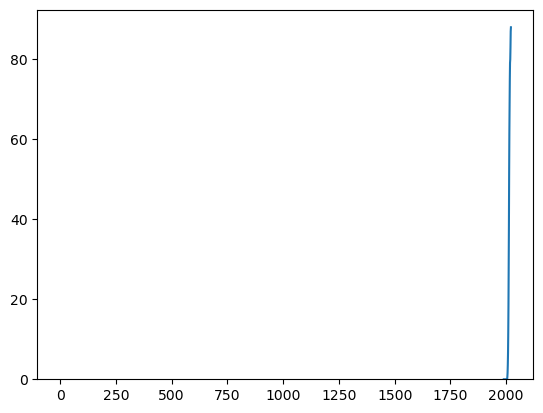

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(5, 0, 0)   Log Likelihood                  36.317
Date:                Sat, 02 Sep 2023   AIC                            -60.634
Time:                        12:48:59   BIC                            -52.030
Sample:                             0   HQIC                           -57.829
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1742      0.148      1.177      0.239      -0.116       0.464
ar.L2         -1.2804      0.164     -7.801      0.000      -1.602      -0.959
ar.L3          1.0385      0.318      3.264      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.276519
32    0.873260
33    0.023564
34   -0.902769
35    0.364872
36    0.804103
37   -0.625004
38   -0.498868
39    0.782298
40    0.179218
41   -0.725294
42    0.128671
43    0.557396
dtype: float64

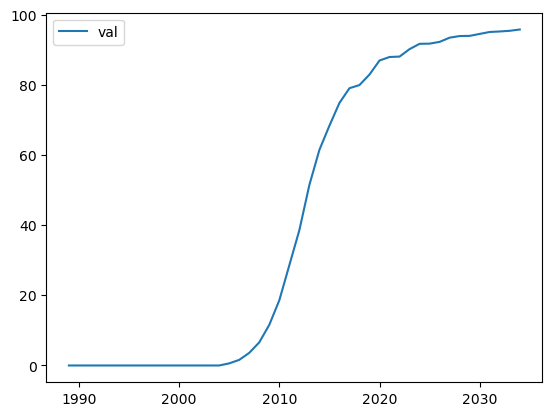

forecasting some_25_34


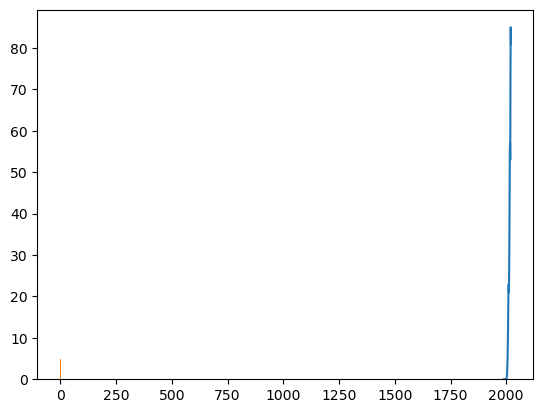

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(4, 0, 1)   Log Likelihood                   6.729
Date:                Sat, 02 Sep 2023   AIC                             -1.459
Time:                        12:49:00   BIC                              7.145
Sample:                             0   HQIC                             1.346
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2718      1.528     -0.178      0.859      -3.267       2.723
ar.L2         -1.8400      0.616     -2.988      0.003      -3.047      -0.633
ar.L3         -0.2542      4.323     -0.059      0.9

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.950475
32    3.164385
33    0.921073
34   -4.014354
35   -0.581334
36    4.558098
37    0.050054
38   -4.761307
39    0.549037
40    4.634521
41   -1.103178
42   -4.226171
43    1.522989
dtype: float64

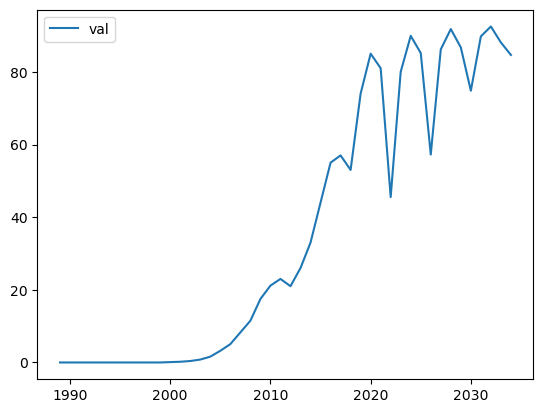

forecasting some_35_44


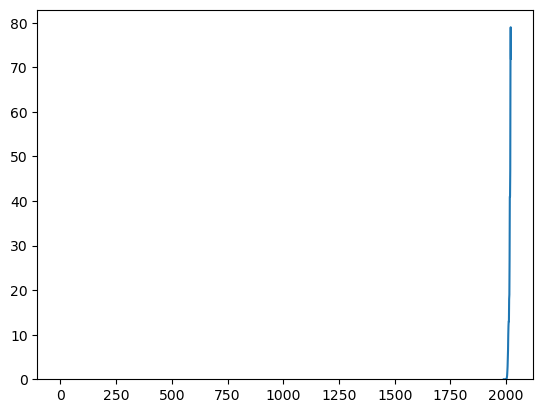

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(4, 0, 1)   Log Likelihood                  20.616
Date:                Sat, 02 Sep 2023   AIC                            -29.232
Time:                        12:49:01   BIC                            -20.628
Sample:                             0   HQIC                           -26.428
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6613      1.493     -0.443      0.658      -3.588       2.265
ar.L2         -1.6206      1.359     -1.192      0.233      -4.285       1.044
ar.L3         -0.5069      3.190     -0.159      0.8

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31    0.832601
32    0.919178
33   -1.184690
34   -0.432169
35    1.214461
36   -0.082141
37   -0.947330
38    0.416630
39    0.535144
40   -0.497053
41   -0.152059
42    0.371961
43   -0.085225
dtype: float64

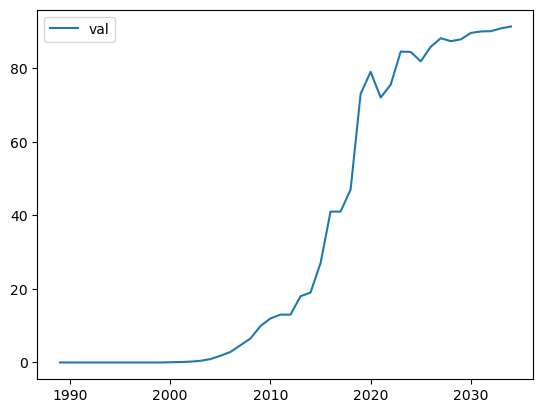

forecasting avioituvuus_25_29


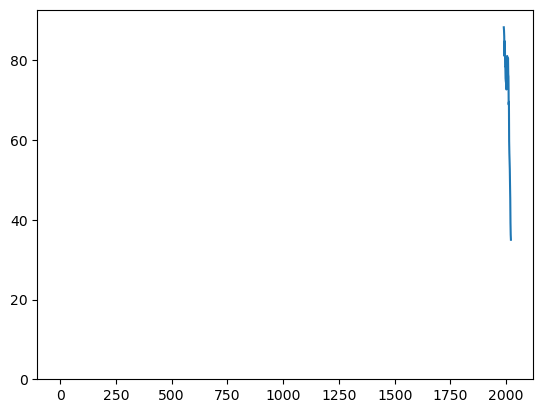

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   8.822
Date:                Sat, 02 Sep 2023   AIC                            -11.644
Time:                        12:49:02   BIC                             -7.342
Sample:                             0   HQIC                           -10.242
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2118      0.211     -5.734      0.000      -1.626      -0.798
ma.L2          0.5407      0.180      2.998      0.003       0.187       0.894
sigma2         0.0314      0.010      3.104      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.124726
32    0.041617
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

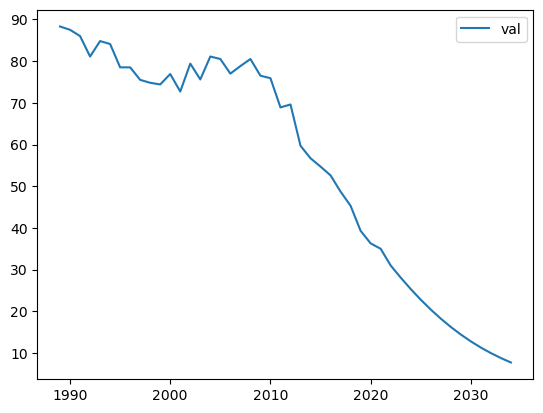

forecasting avioituvuus_30_34


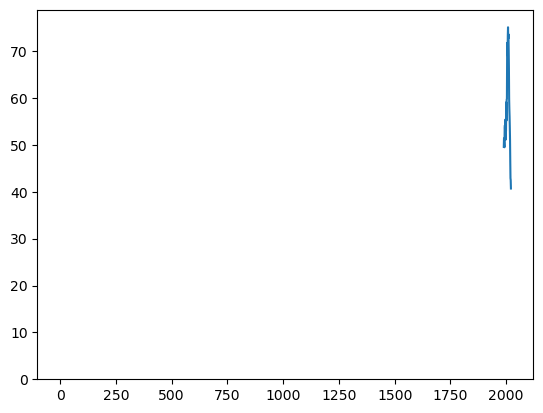

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                        SARIMAX   Log Likelihood                  15.559
Date:                Sat, 02 Sep 2023   AIC                            -29.119
Time:                        12:49:03   BIC                            -27.653
Sample:                             0   HQIC                           -28.633
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0221      0.005      4.049      0.000       0.011       0.033
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 2.61
Prob(Q):                              0.55   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

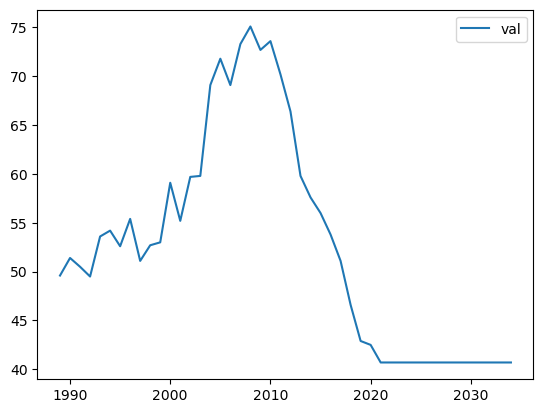

forecasting synnyttajien_keskiika


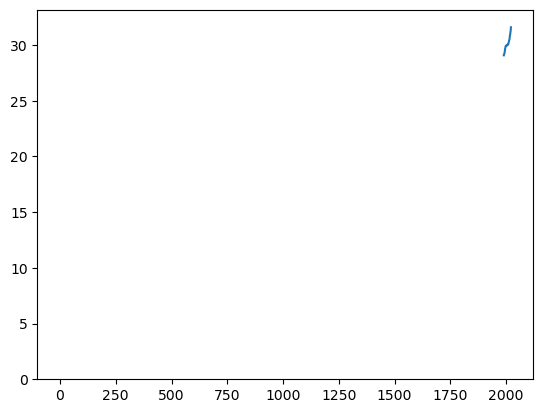

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 137.495
Date:                Sat, 02 Sep 2023   AIC                           -270.989
Time:                        12:49:04   BIC                           -268.122
Sample:                             0   HQIC                          -270.055
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5958      0.205     -2.906      0.004      -0.998      -0.194
sigma2      8.106e-06   2.06e-06      3.930      0.000    4.06e-06    1.21e-05
Ljung-Box (L1) (Q):                   0.09   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.004715
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

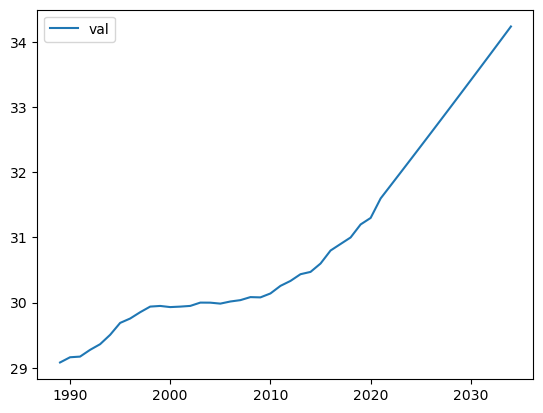

forecasting sisempikaupunki


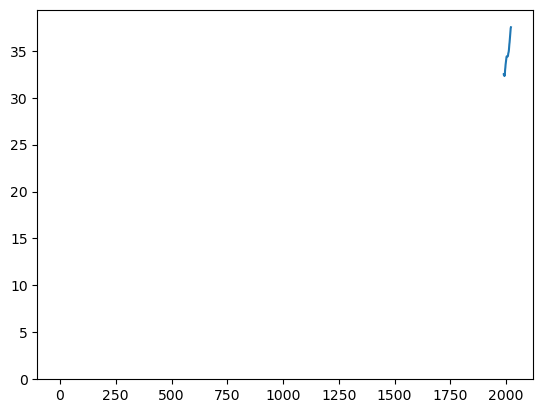

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:                        SARIMAX   Log Likelihood                 172.040
Date:                Sat, 02 Sep 2023   AIC                           -342.079
Time:                        12:49:05   BIC                           -340.645
Sample:                             0   HQIC                          -341.612
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.854e-07   2.11e-07      4.206      0.000    4.73e-07     1.3e-06
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):                 0.11
Prob(Q):                              0.30   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

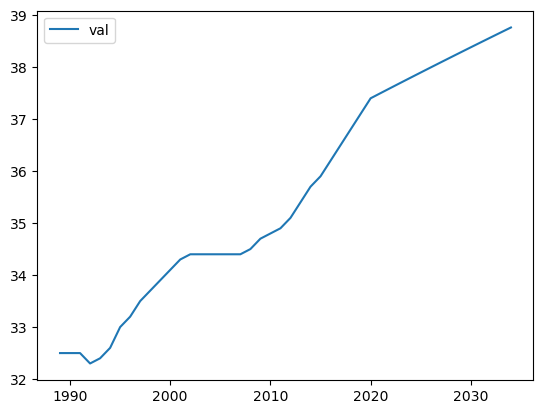

forecasting ulompikaupunki


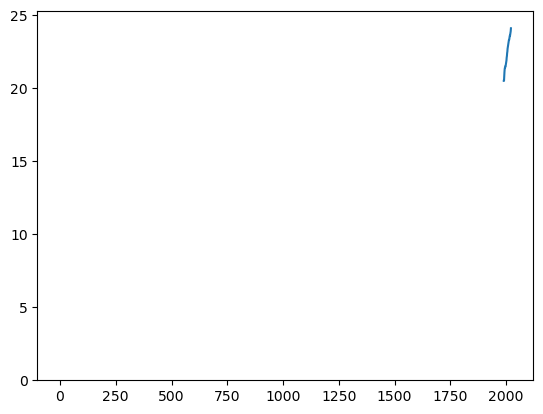

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 198.834
Date:                Sat, 02 Sep 2023   AIC                           -393.669
Time:                        12:49:06   BIC                           -390.801
Sample:                             0   HQIC                          -392.734
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4739      0.202     -2.343      0.019      -0.870      -0.077
sigma2      1.556e-07   3.37e-08      4.615      0.000    8.95e-08    2.22e-07
Ljung-Box (L1) (Q):                   0.06   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.000273
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

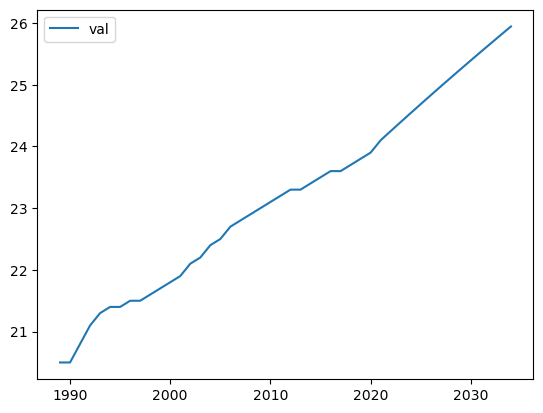

forecasting kehyskaupunki


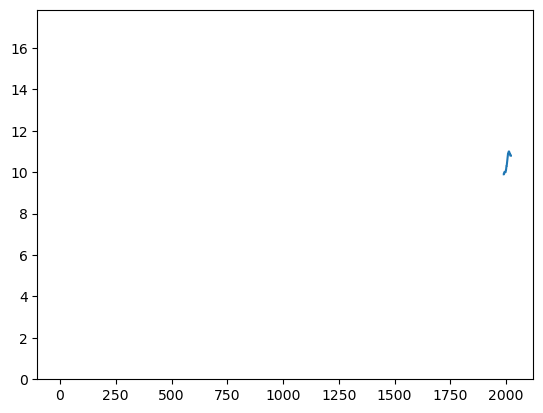

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 236.550
Date:                Sat, 02 Sep 2023   AIC                           -469.100
Time:                        12:49:08   BIC                           -466.232
Sample:                             0   HQIC                          -468.166
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7342    8.4e-18  -8.74e+16      0.000      -0.734      -0.734
sigma2      1.298e-08    3.5e-09      3.711      0.000    6.13e-09    1.98e-08
Ljung-Box (L1) (Q):                   0.03   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31   -0.000025
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

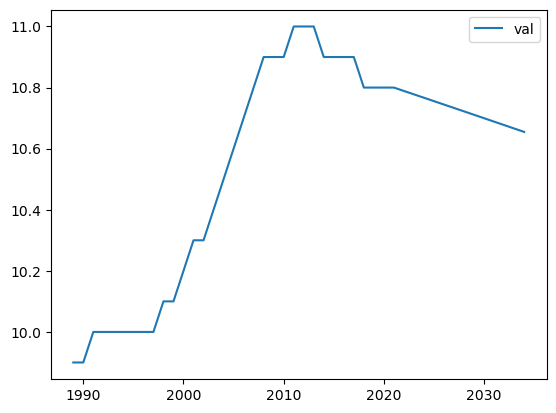

forecasting maaseudulla


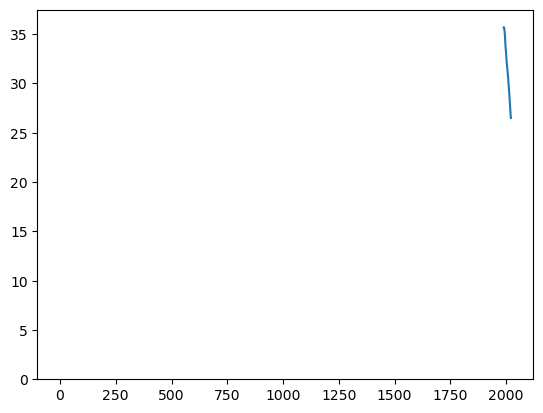

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:                        SARIMAX   Log Likelihood                 180.975
Date:                Sat, 02 Sep 2023   AIC                           -359.950
Time:                        12:49:08   BIC                           -358.516
Sample:                             0   HQIC                          -359.482
                                 - 31                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.975e-07   1.34e-07      3.719      0.000    2.35e-07     7.6e-07
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.40   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

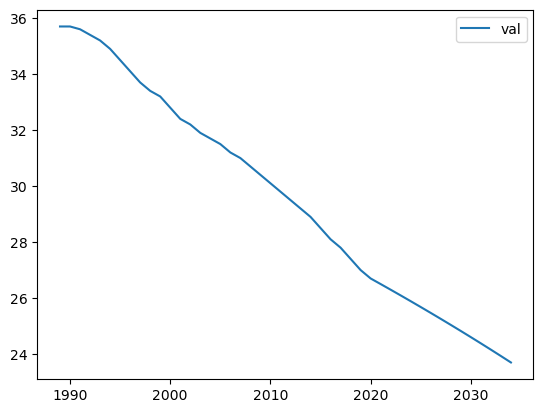

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

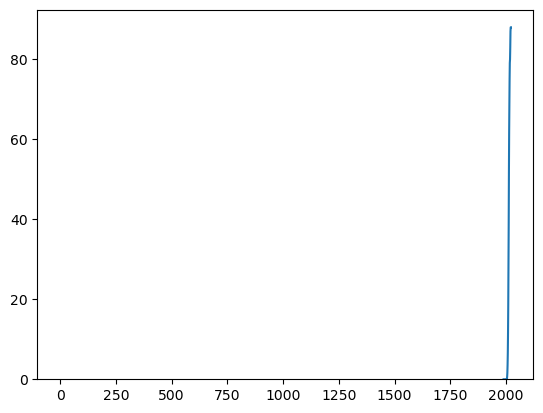

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(5, 0, 0)   Log Likelihood                  38.040
Date:                Sat, 02 Sep 2023   AIC                            -64.081
Time:                        12:49:10   BIC                            -55.286
Sample:                             0   HQIC                           -61.166
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2077      0.145      1.430      0.153      -0.077       0.492
ar.L2         -1.3196      0.166     -7.960      0.000      -1.644      -0.995
ar.L3          1.0430      0.294      3.549      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.866788
33    0.091109
34   -0.935760
35    0.266502
36    0.877271
37   -0.540604
38   -0.628856
39    0.729166
40    0.334316
41   -0.735982
42   -0.029498
43    0.622958
dtype: float64

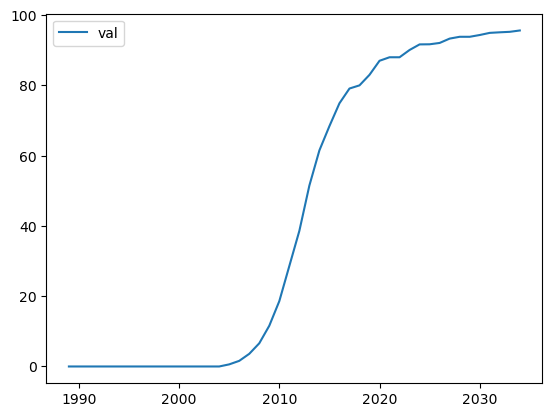

forecasting some_25_34


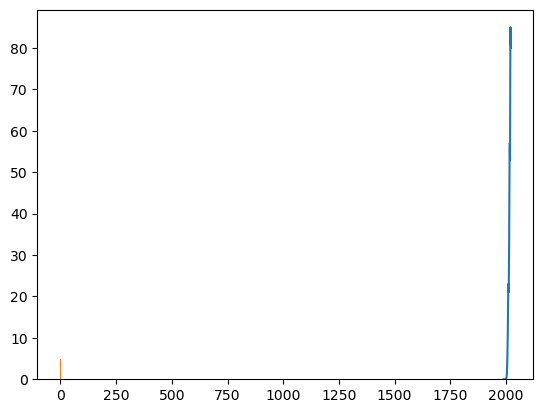

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(4, 0, 0)   Log Likelihood                  -1.510
Date:                Sat, 02 Sep 2023   AIC                             13.021
Time:                        12:49:11   BIC                             20.350
Sample:                             0   HQIC                            15.450
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7298      0.187     -3.897      0.000      -1.097      -0.363
ar.L2         -1.5282      0.248     -6.173      0.000      -2.013      -1.043
ar.L3         -0.4991      0.481     -1.038      0.2

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    2.012883
33   -1.593351
34   -1.093493
35    1.929760
36   -0.003953
37   -1.559691
38    0.757998
39    0.814154
40   -0.971937
41   -0.090324
42    0.744928
43   -0.350024
dtype: float64

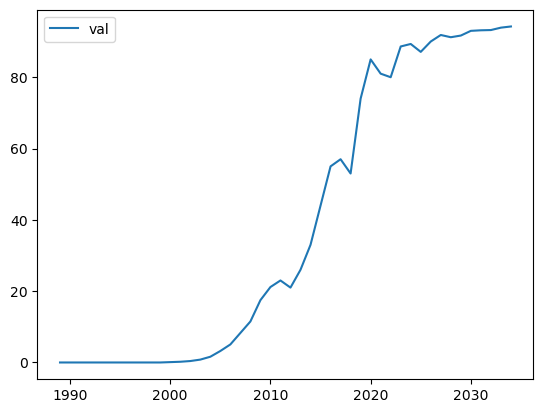

forecasting some_35_44


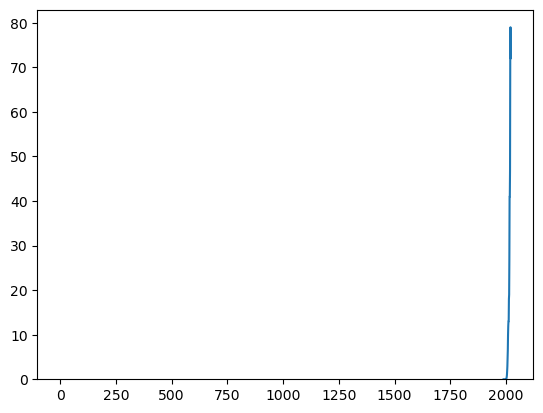

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(4, 0, 1)   Log Likelihood                  21.892
Date:                Sat, 02 Sep 2023   AIC                            -31.784
Time:                        12:49:12   BIC                            -22.990
Sample:                             0   HQIC                           -28.869
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6933      1.126     -0.616      0.538      -2.901       1.514
ar.L2         -1.6461      1.179     -1.397      0.163      -3.956       0.664
ar.L3         -0.5335      2.531     -0.211      0.8

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.907527
33   -1.265842
34   -0.380993
35    1.307129
36   -0.181268
37   -1.017386
38    0.548898
39    0.559208
40   -0.633215
41   -0.126992
42    0.482851
43   -0.143742
dtype: float64

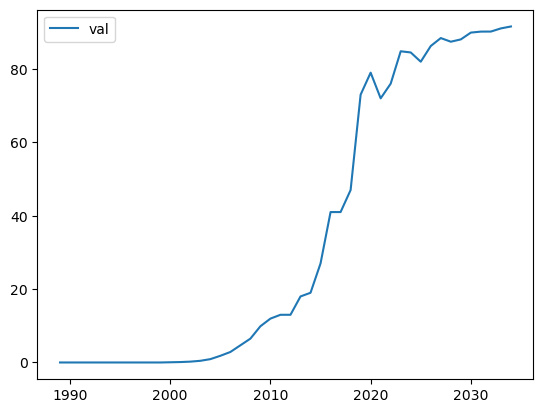

forecasting avioituvuus_25_29


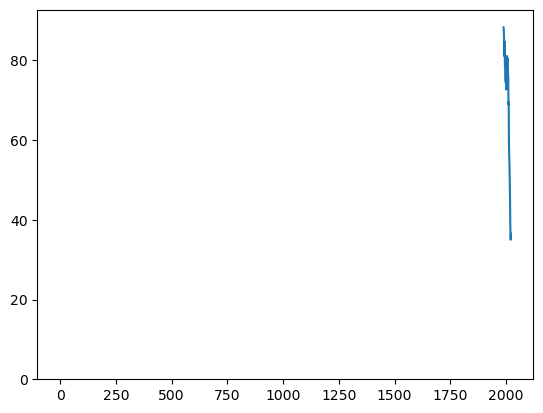

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 0, 2)   Log Likelihood                   8.679
Date:                Sat, 02 Sep 2023   AIC                            -11.357
Time:                        12:49:14   BIC                             -6.960
Sample:                             0   HQIC                            -9.900
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2176      0.220     -5.533      0.000      -1.649      -0.786
ma.L2          0.5351      0.189      2.835      0.005       0.165       0.905
sigma2         0.0323      0.011      3.073      0.0

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32   -0.257109
33    0.131065
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

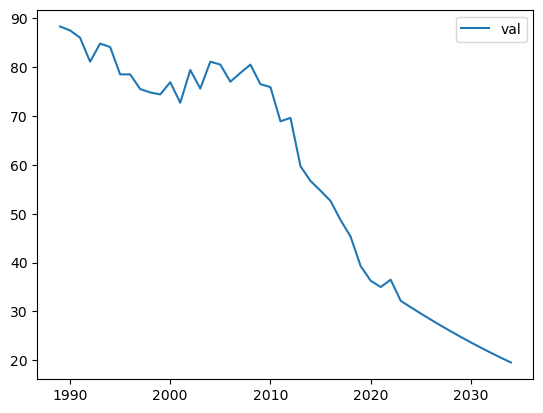

forecasting avioituvuus_30_34


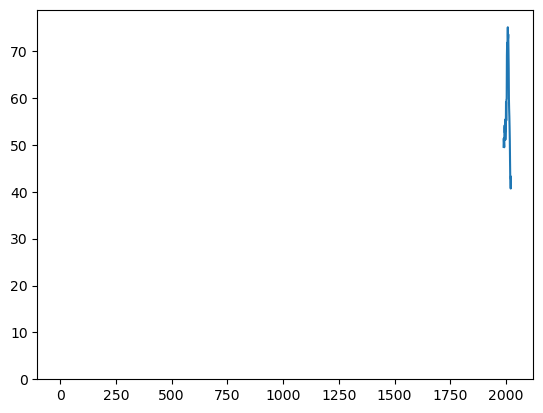

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:                        SARIMAX   Log Likelihood                  16.310
Date:                Sat, 02 Sep 2023   AIC                            -30.619
Time:                        12:49:15   BIC                            -29.123
Sample:                             0   HQIC                           -30.116
                                 - 33                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0218      0.005      4.123      0.000       0.011       0.032
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.59   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
dtype: float64

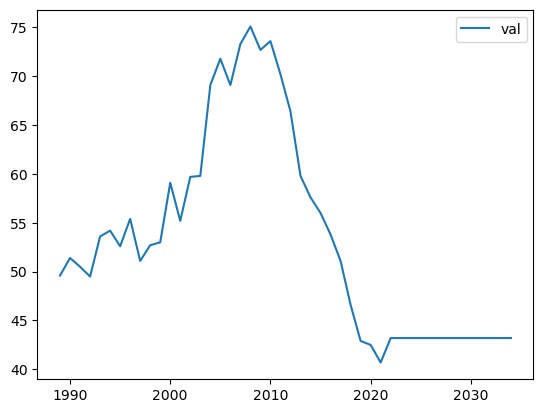

forecasting synnyttajien_keskiika


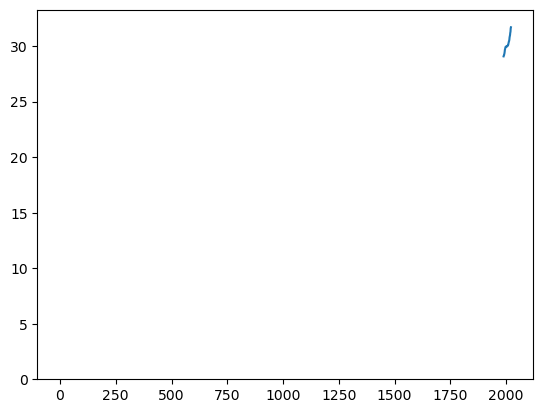

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 141.268
Date:                Sat, 02 Sep 2023   AIC                           -278.535
Time:                        12:49:15   BIC                           -275.604
Sample:                             0   HQIC                          -277.564
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6553      0.136     -4.805      0.000      -0.923      -0.388
sigma2      8.405e-06   2.54e-06      3.313      0.001    3.43e-06    1.34e-05
Ljung-Box (L1) (Q):                   0.60   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.006090
33   -0.003991
34    0.002615
35   -0.001714
36    0.001123
37   -0.000736
38    0.000482
39   -0.000316
40    0.000207
41   -0.000136
42    0.000089
43   -0.000058
dtype: float64

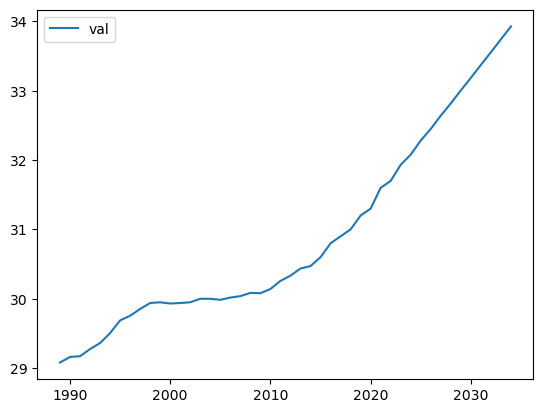

forecasting sisempikaupunki


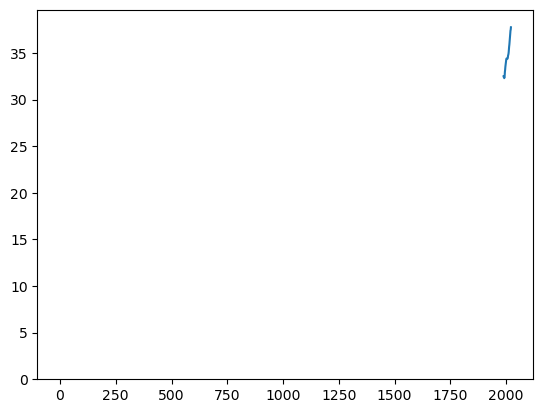

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 177.843
Date:                Sat, 02 Sep 2023   AIC                           -351.686
Time:                        12:49:16   BIC                           -348.754
Sample:                             0   HQIC                          -350.714
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2917      0.138     -2.111      0.035      -0.563      -0.021
sigma2      8.656e-07   2.28e-07      3.795      0.000    4.19e-07    1.31e-06
Ljung-Box (L1) (Q):                   0.00   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32   -4.790122e-04
33    1.397145e-04
34   -4.075083e-05
35    1.188588e-05
36   -3.466781e-06
37    1.011163e-06
38   -2.949282e-07
39    8.602234e-08
40   -2.509032e-08
41    7.318148e-09
42   -2.134500e-09
43    6.225741e-10
dtype: float64

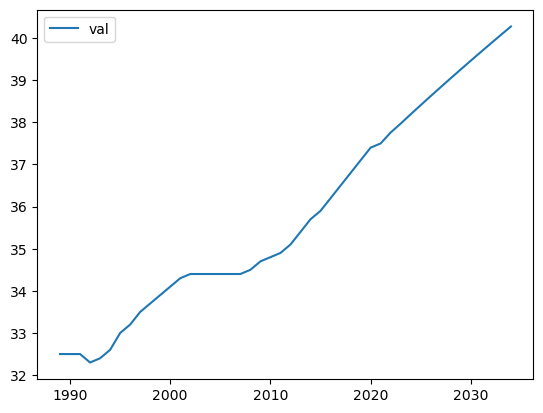

forecasting ulompikaupunki


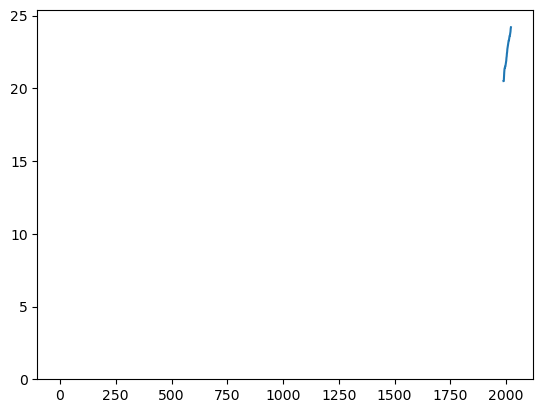

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 205.748
Date:                Sat, 02 Sep 2023   AIC                           -407.496
Time:                        12:49:17   BIC                           -404.565
Sample:                             0   HQIC                          -406.525
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5120      0.195     -2.628      0.009      -0.894      -0.130
sigma2      1.508e-07   3.19e-08      4.733      0.000    8.83e-08    2.13e-07
Ljung-Box (L1) (Q):                   0.04   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.000121
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

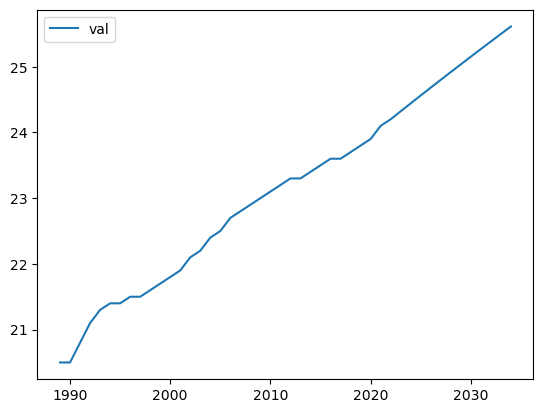

forecasting kehyskaupunki


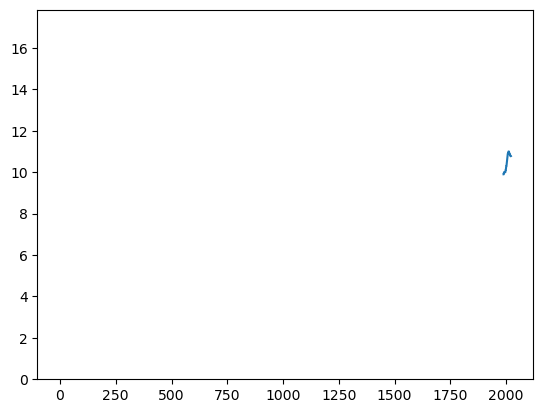

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 244.686
Date:                Sat, 02 Sep 2023   AIC                           -485.372
Time:                        12:49:19   BIC                           -482.440
Sample:                             0   HQIC                          -484.400
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7331   7.45e-18  -9.85e+16      0.000      -0.733      -0.733
sigma2       1.26e-08   3.27e-09      3.851      0.000    6.19e-09     1.9e-08
Ljung-Box (L1) (Q):                   0.04   Jarque-

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.000014
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
dtype: float64

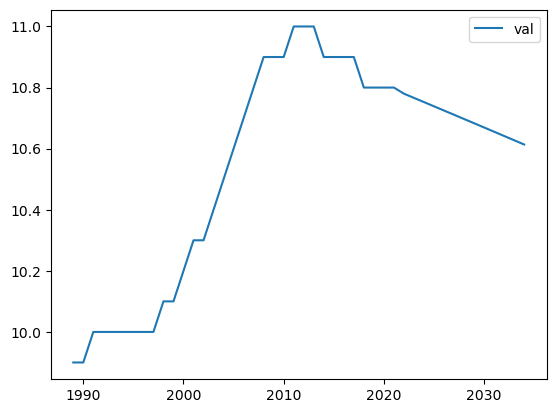

forecasting maaseudulla


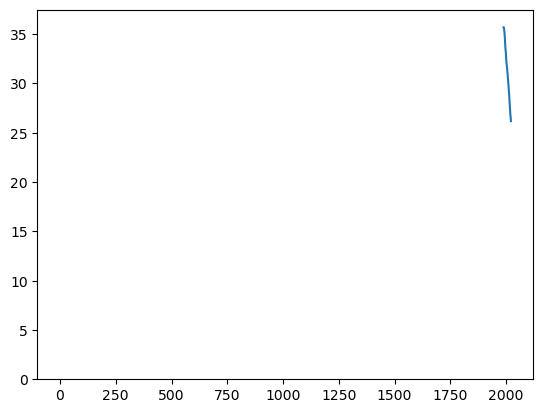

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                        SARIMAX   Log Likelihood                 186.800
Date:                Sat, 02 Sep 2023   AIC                           -371.600
Time:                        12:49:20   BIC                           -370.134
Sample:                             0   HQIC                          -371.114
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.979e-07   1.34e-07      3.716      0.000    2.35e-07    7.61e-07
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.32   Pr

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


'forecast_test_auto'

32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
dtype: float64

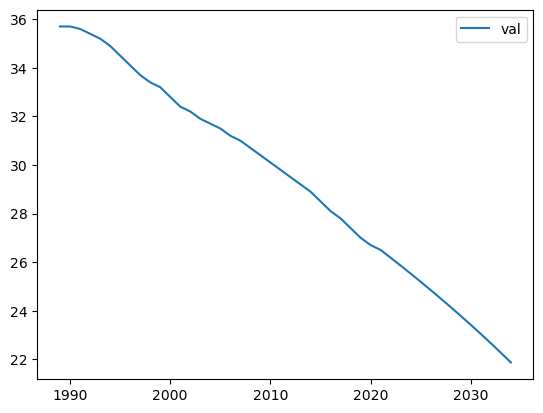

       alypuhelin  some_25_34  some_35_44  avioituvuus_25_29  \
vuosi                                                          
1989     0.000000    0.000000    0.000000          88.300000   
1990     0.000000    0.000000    0.000000          87.500000   
1991     0.000000    0.000000    0.000000          86.000000   
1992     0.000000    0.000000    0.000000          81.100000   
1993     0.000000    0.000000    0.000000          84.800000   
1994     0.000000    0.000000    0.000000          84.100000   
1995     0.000000    0.000000    0.000000          78.500000   
1996     0.000000    0.000000    0.000000          78.500000   
1997     0.000000    0.000000    0.000000          75.500000   
1998     0.000000    0.000000    0.000000          74.800000   
1999     0.000000    0.000000    0.000000          74.400000   
2000     0.000000    0.100625    0.056875          76.900000   
2001     0.000000    0.201250    0.113750          72.700000   
2002     0.000000    0.402500    0.22750

In [7]:
first=True
for y in range(2015,2023):
    data2=predict_arima(data,y,debug=False)
    print(data2)
    sheet=str(y)
    if first:
        update_excel_intensities('data/backtesting_pred.xlsx',data2,sheet,mode='w')
        first=False
    else:
        update_excel_intensities('data/backtesting_pred.xlsx',data2,sheet)